# An antigenic atlas of HIV-1 escape from broadly neutralizing antibodies
### Adam S. Dingens,  Julie Overbaugh, and Jesse D. Bloom

We are performing mutational antigenic profiling of a panel of bnAbs using the BG505.T332N mutant Env libraries, first described and characterized in [Haddox, Dingens et al 2018](https://elifesciences.org/articles/34420). The triplicate mutant libraries examined here correspond to the three BG505 replicates in this paper. Replicates annotated with an additional letter (i.e. "rep 1b") were done on an indepdent day and have their own mock selected control. 

The _fraction surviving_ statistic used in this analysis is explained in detail [here](https://jbloomlab.github.io/dms_tools2/fracsurvive.html). Our first mutational antigenic profiling analysis of escape from PGT151 using the BF520 env libraries was published [here](http://dx.doi.org/10.1016/j.chom.2017.05.003) in June 2017, and this original analysis is located [in this ipython notebook](https://github.com/adingens/BF520_MutationalAntigenicProfiling_PGT151).

We use [dms_tools2](https://jbloomlab.github.io/dms_tools2/) to analyze these data. This notebook processes the Illumina deep sequencing data software package, and then analyzes the selection in the context of the antibody. Experiments and analysis performed by Adam Dingens in the [Bloom lab](http://research.fhcrc.org/bloom/en.html) in 2017-2018. 

## Import `Python` modules, define widely used functions
Set `use_existing` to `yes` below if you want to use any existing output, and `no` if you want to re-generate all output.

In [1]:
import os
import glob
%matplotlib inline
import pandas as pd
from IPython.display import display, HTML
import dms_tools2
import dms_tools2.plot
import dms_tools2.sra
import dms_tools2.utils
import dms_tools2.diffsel
import dms_tools2.prefs
from dms_tools2.ipython_utils import showPDF
import rpy2
import rpy2.robjects 
import dms_tools2.rplot
import string
import Bio.SeqIO
import Bio.Seq
import Bio.SeqRecord
import numpy as np
import pylab as plt
#from colour import Color

print("Using dms_tools2 version {0}".format(dms_tools2.__version__))

# results will go in this directory
resultsdir = './results/' 
if not os.path.isdir(resultsdir):
    os.mkdir(resultsdir)
    
# CPUs to use, -1 means all available
ncpus = 14

# do we use existing results or generate everything new?
use_existing = "yes"

Using dms_tools2 version 2.2.9


_*Note*_:
I updated the alignment between HXB2, BG505, BF520, and LAI from the one used in [Haddox, Dingens et al 2018](https://elifesciences.org/articles/34420). Specifically for BG505 and BF520, there was an insertion at 317a. To better align to the frequency of amino acids in nature, I moved this insertion to 322a. However, the 5fyk structure has this insertion at 321a (this accounted for in structural analyses). 


In [2]:
# the homologs that we are examining
homologs = ['BG505']

# files with codon sequences
wtseqfiles = dict([(env, './data/{0}_env.fasta'.format(env)) for env in homologs])

#the mutagenized codon sites in 1, 2, ... numbering
#for both this is 31-702 in HXB2 numbering
mutagenizedsites = {
        'BG505':list(range(30, 699 + 1)),
        'BF520':list(range(31, 691 + 1)),
        'LAI':list(range(31, 707 + 1))
        }

In [3]:
protalignmentfile = './data/Env_protalign_manualeditAD.fasta'
alignedprots = dict([(seq.name, str(seq.seq)) for seq in 
        Bio.SeqIO.parse(protalignmentfile, 'fasta')])

In [4]:
renumbdir = os.path.join(resultsdir, 'HXB2_numbering')
if not os.path.isdir(renumbdir):
    os.mkdir(renumbdir)

# keyed by homolog, value is renumbering file
renumbfile = {}
    
for env in homologs:
    
    # first build numbering with HXB2 numbers potentially repeated
    hxb2_r = 1
    hxb2_nums = [] # holds HXB2 numbers
    wildtype_aas = []
    nglycan = []
    alignedenv = alignedprots[env]
    envlen = len(alignedenv)
    for (r, (hxb2_aa, aa)) in enumerate(zip(alignedprots['HXB2'], alignedenv)):
        if aa != '-':
            hxb2_nums.append(str(hxb2_r - int(hxb2_aa == '-')))
            wildtype_aas.append(aa)
            if aa == 'N' and r + 2 < envlen and alignedenv[r + 2] in {'S', 'T'}:
                nglycan.append(True)
            elif aa in {'S', 'T'} and alignedenv[r - 2] == 'N':
                nglycan.append(True)
            elif aa != 'P' and r + 1 < envlen and alignedenv[r + 1] in {'S', 'T'} and alignedenv[r - 1] == 'N':
            #elif aa not in {'P'} and alignedenv[r + 1] in {'S', 'T'} and alignedenv[r - 1] == 'N':
                nglycan.append(True)
            else:
                nglycan.append(False)
        if hxb2_aa != '-':
            hxb2_r += 1
            
    # now take all runs of HXB2 numbers and make them 10, 10a, 10b, etc...
    for num in set(hxb2_nums):
        n_num = hxb2_nums.count(num)
        firstnum = hxb2_nums.index(num)
        for i in range(n_num - 1):
            hxb2_nums[firstnum + i + 1] = num + string.ascii_lowercase[i]
                
    # now write renumbering file
    renumbfile[env] = os.path.join(renumbdir, '{0}_to_HXB2.csv'.format(env))
    print("Writing HXB2 renumbering file for {0} to {1}".format(
            env, renumbfile[env]))
    with open(renumbfile[env], 'w') as f:
        f.write('original,new,wildtype,N-glycan\n')
        for (r, new) in enumerate(hxb2_nums):
            if r+1 not in mutagenizedsites[env]:
                continue
            else:
                f.write('{0},{1},{2},{3}\n'.format(r + 1, new, wildtype_aas[r],
                        nglycan[r]))

Writing HXB2 renumbering file for BG505 to ./results/HXB2_numbering/BG505_to_HXB2.csv


## Download the sequencing data from the Sequence Read Archive
Here we download sequencing data for each sample from the [Sequence Read Archive](http://www.ncbi.nlm.nih.gov/sra). Sample names specificy if they are mutant (mut) or wildtype (wt), as well as virus (virus) or DNA (DNA). The _#_ is which replicate.  If a sample is antibody selected, it also has the antibody and `ug/mL` concentration. There is metadata available from the SRA, and the dictionary below also specifies the accession number of each sample.

They reads were submitted as SRA submission [SRP157948](https://www.ncbi.nlm.nih.gov/sra/SRP157948) with SRA accession numbers `SRX4553035-SRX4553088, SRX4614453` on Aug 14 and Aug 27, 2018. The BioProject ID is `PRJNA486029`. 

We download these files using the [dms_tools2.sra.fastqFromSRA](https://jbloomlab.github.io/dms_tools2/dms_tools2.sra.html) function from the dms_tools2 Python API. Note that the call to this function below uses two external programs that are not part of dms_tools2, and which you therefore must install externally on the computer that you are using:
1. The fastq-dump program from the SRA Toolkit. If you do not already have this toolkit installed, you will need to install a relatively recent version.
2. The Aspera Connect program for rapid downloads. You need both the executable ascp and an Aspera Key file. Installing Aspera Connect and a key can be somewhat complex, so if you do not want to do this then just set aspera=None in the command below and fastq-dump will do the downloads (albeit more slowly).

**NOTE before downloading: This is ~95 gb, 214 Gbases of data!**

In [5]:
samples = pd.DataFrame.from_records(
        [('BG505_mut-virus-rep1b','SRR7693968'),
         ('BG505_mut-virus-rep2b-3BNC117-4ug','SRR7693969'),
         ('BG505_wt-virus-rep2b','SRR7693970'),
         ('BG505_mut-virus-rep1-VRC01-11ug','SRR7693971'),
         ('BG505_wt-virus-rep3','SRR7693972'),
         ('BG505_mut-virus-rep2b-PGT121-3-5ug','SRR7693973'),
         ('BG505_mut-virus-rep2b-101074-3ug','SRR7693974'),
         ('BG505_mut-virus-rep2b-PGT121-4-25ug','SRR7693975'),
         ('BG505_mut-virus-rep3','SRR7693976'),
         ('BG505_mut-virus-rep3-3BNC117-1-1ug','SRR7693977'),
         ('BG505_mut-virus-rep2b-3BN-1074-pool-4ug','SRR7693978'),
         ('BG505_mut-virus-rep1b-3BN-1074-pool-3ug','SRR7693979'),
         ('BG505_wt-virus-rep1b','SRR7693980'),
         ('BG505_mut-virus-rep1b-3BN-1074-pool-4ug','SRR7693981'),
         ('BG505_mut-virus-rep3b-3BN-1074-pool-4ug','SRR7693982'),
         ('BG505_wt-virus-rep1','SRR7693983'),
         ('BG505_wt-virus-rep3b','SRR7693984'),
         ('BG505_mut-virus-rep2b-101074-4ug','SRR7693985'),
         ('BG505_mut-DNA-rep1','SRR7693986'),
         ('BG505_mut-DNA-rep3','SRR7694021'),
         ('BG505_mut-virus-rep3-VRC34-33ug','SRR7694020'),
         ('BG505_mut-virus-rep1-smear-PG9-10ug','SRR7694019'),
         ('BG505_mut-virus-rep2b','SRR7694018'),
         ('BG505_wt-DNA-rep3','SRR7694017'),
         ('BG505_mut-virus-rep1-PGT151-0-2ug','SRR7694016'),
         ('BG505_mut-virus-rep2-VRC01-8ug','SRR7694015'),
         ('BG505_mut-virus-rep2b-3BN-1074-pool-3ug','SRR7694014'),
         ('BG505_wt-virus-rep2','SRR7694013'),
         ('BG505_mut-virus-rep1-PGT121-3-5ug','SRR7694012'),
         ('BG505_mut-virus-rep3b-101074-4ug','SRR7694011'),
         ('BG505_mut-virus-rep1b-PGT145-125ug','SRR7694010'),
         ('BG505_mut-virus-rep3b-3BN-1074-pool-3ug','SRR7694009'),
         ('BG505_mut-virus-rep3b-PGT145-125ug','SRR7694008'),
         ('BG505_mut-virus-rep3b-PGT121-3-5ug','SRR7694007'),
         ('BG505_mut-virus-rep1b-3BNC117-4ug','SRR7694006'),
         ('BG505_mut-virus-rep3b-3BNC117-4ug','SRR7694005'),
         ('BG505_mut-virus-rep1b-101074-4ug','SRR7694004'),
         ('BG505_mut-virus-rep3b','SRR7694003'),
         ('BG505_mut-DNA-rep2','SRR7694002'),
         ('BG505_mut-virus-rep3-PG9-10ug','SRR7694001'),
         ('BG505_mut-virus-rep2b-PGT145-125ug','SRR7694000'),
         ('BG505_mut-virus-rep1-PG9-10ug','SRR7693999'),
         ('BG505_wt-DNA-rep2','SRR7693998'),
         ('BG505_mut-virus-rep2','SRR7693997'),
         ('BG505_mut-virus-rep3-VRC01-tr2-11ug','SRR7693996'),
         ('BG505_mut-virus-rep1-10E8-60ug','SRR7693995'),
         ('BG505_mut-virus-rep3-VRC34-11ug','SRR7693994'),
         ('BG505_mut-virus-rep1-VRC34-33ug','SRR7693993'),
         ('BG505_mut-virus-rep3-VRC01-11ug','SRR7693992'),
         ('BG505_mut-virus-rep2-VRC01-11ug','SRR7693991'),
         ('BG505_mut-virus-rep2b-3BNC117-3ug','SRR7693990'),
         ('BG505_wt-DNA-rep1','SRR7693989'),
         ('BG505_mut-virus-rep3-10E8-60ug','SRR7693988'),
         ('BG505_mut-virus-rep1','SRR7693987'),
         ('BG505_mut-virus-rep3-PGT151-0-2ug','SRR7758666')],
        columns=['name', 'run']
        )


fastqdir = './results/FASTQ_files/'
if not os.path.isdir(fastqdir):
    os.mkdir(fastqdir)
print("Downloading FASTQ files from the SRA...")
dms_tools2.sra.fastqFromSRA(
        samples=samples,
        fastq_dump='fastq-dump', # valid path to this program on the Hutch server
        fastqdir=fastqdir,
        aspera=(
            '/app/aspera-connect/3.5.1/bin/ascp', # valid path to ascp on Hutch server
            '/app/aspera-connect/3.5.1/etc/asperaweb_id_dsa.openssh' # Aspera key on Hutch server
            ),
        )
print("Here are the names of the downloaded files now found in {0}".format(fastqdir))
display(HTML(samples.to_html(index=False)))

Here are the names of the downloaded files now found in ./results/FASTQ_files/


## Define samples from FASTQ_files

In [6]:
R1fastqfilelist_df = pd.read_csv("./data/BG505_panel_samples.csv", header =0)
#display(HTML(R1fastqfilelist_df.to_html(index=False)))

## Process the FASTQ files to count the mutations for each sample
We used [barcoded-subamplicon](https://jbloomlab.github.io/dms_tools2/bcsubamp.html) sequencing to obtain high accuracy during the Illumina deep sequencing. We therefore use the [dms2_batch_bcsubamp](https://jbloomlab.github.io/dms_tools2/dms2_batch_bcsubamp.html#dms2-batch-bcsubamp) program to analyze these data.

Running that program requires specifying a `--batchfile` that lists the samples, a wildtype `--refseq` to which we make alignments, and --alignspecs that tell us where the subamplicons should align. 
The batch file that we specify is printed by the cell below. The alignment specs need to be exactly correct for the subamplicons to align. We also do some trimming of the reads using the `--R1trim` and `--R2trim` parameters. 

The wildtype sequence of the BG505.W6.C2.T332N Env used in this experiment is in the file [./data/BG505.W6.C2.T332N_env.fasta](./data/BG505.W6.C2.T332N_env.fasta).
This sequence is based on GenBank accession number [DQ208458.1](https://www.ncbi.nlm.nih.gov/nucleotide/77025198?report=genbank&log$=nuclalign&blast_rank=1&RID=WMZ5XNUG014), with the introduced T332N mutation to knock in the glycan commonly targeted by this class of bnAbs. 

In [7]:
refseq = './data/BG505.W6.C2.T332N_env.fasta'

fastqdir ='./results/FASTQ_files/'
# define subamplicon alignment specifications
alignspecs = ' '.join(['87,375,39,36', 
                       '376,666,36,39',
                       '663,954,33,41',
                       '955,1228,33,37',
                       '1228,1527,34,35',
                       '1527,1815,32,39',
                       '1816,2098,36,41'])

# counts and alignments placed in this directory
countsdir = os.path.join(resultsdir, 'codoncounts')
if not os.path.isdir(countsdir):
    os.mkdir(countsdir)
    
# write sample information to a batch file for dms2_batch_bcsubamplicons
countsbatchfile = os.path.join(countsdir, 'batch.csv')
print("Here is the batch file that we write to CSV format to use as input:")
display(HTML(R1fastqfilelist_df[['name', 'R1']].to_html(index=False)))
R1fastqfilelist_df[['name', 'R1']].to_csv(countsbatchfile, index=False)

print('\nNow running dms2_batch_bcsubamp...')
log = !dms2_batch_bcsubamp \
        --batchfile {countsbatchfile} \
        --refseq {refseq} \
        --alignspecs {alignspecs} \
        --outdir {countsdir} \
        --summaryprefix summary \
        --R1trim 200 \
        --R2trim 170 \
        --minq 15 \
        --fastqdir {fastqdir} \
        --ncpus {ncpus} \
        --use_existing {use_existing} 
print("Completed dms2_batch_bcsubamp.")

Here is the batch file that we write to CSV format to use as input:



Now running dms2_batch_bcsubamp...
Completed dms2_batch_bcsubamp.


Now we look at the summary plots created by `dms2_batch_bcsubamp`. 
All of these files are found in the directory specified by --outdir, and with the prefix specified by summaryprefix. 
So we define them using this plot prefix plus the suffix for each plot.
Note that these files all refer to sites in sequential 1, 2, ... numbering of the BF520 sequence.

In [8]:
countsplotprefix = os.path.join(countsdir, 'summary')

The `*_readstats.pdf` plot below shows the statistics on the reads. This plot shows that most of the reads were retained, and a small fraction discarded because of low-quality barcodes. None failed the Illumina filter as those were already filtered out those when we downloaded from the SRA.

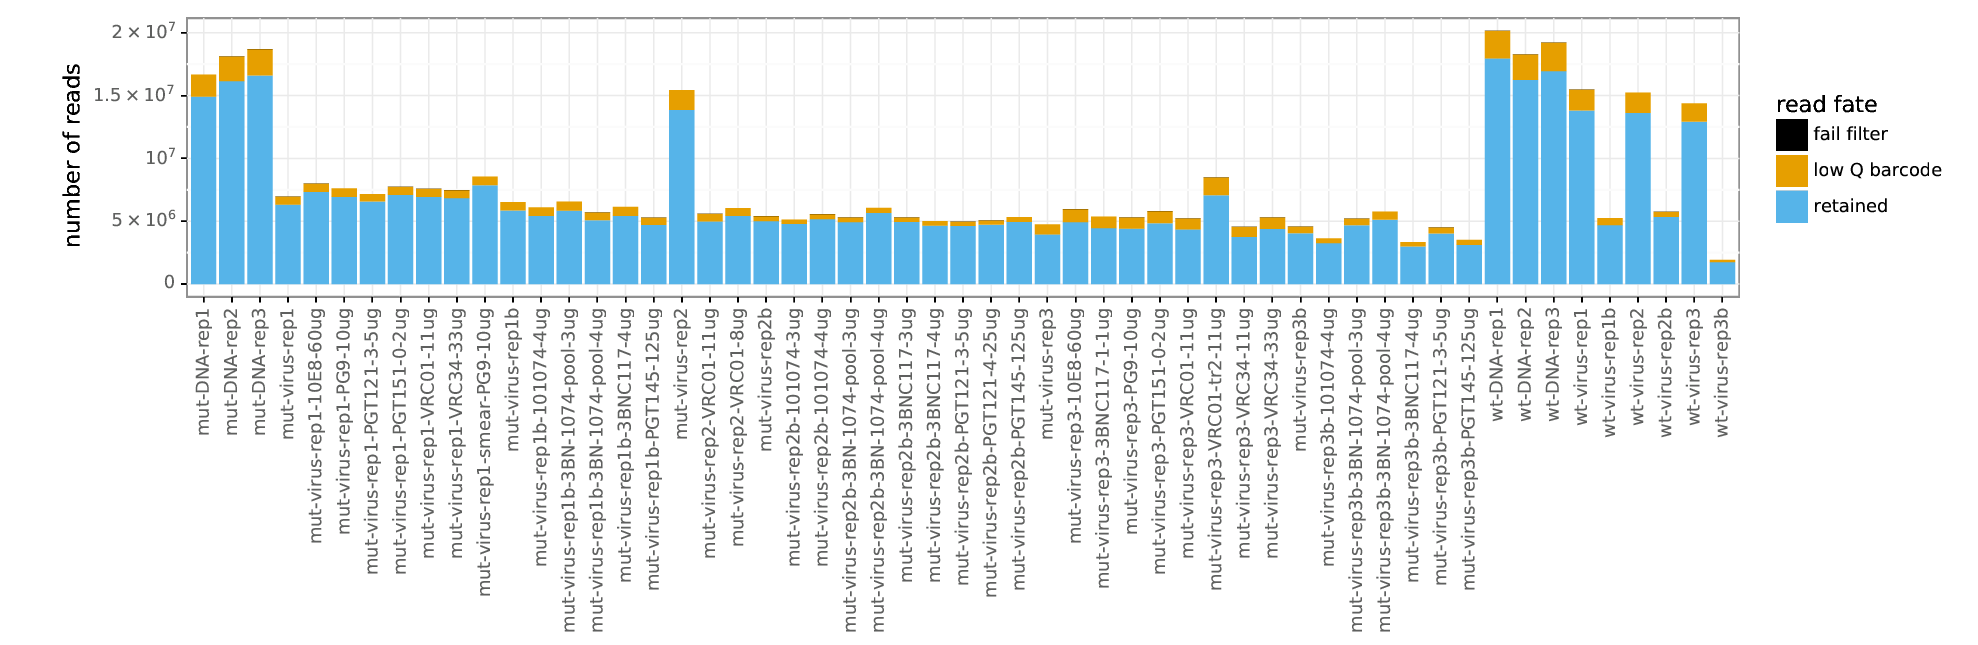

In [9]:
showPDF(countsplotprefix + '_readstats.pdf', width=600)

The `*_readsperbc.pdf` plot below shows how many times different barcodes were observed for each sample. Barcodes need to be observed multiple times to be useful for barcoded-subamplicon sequencing error correction.

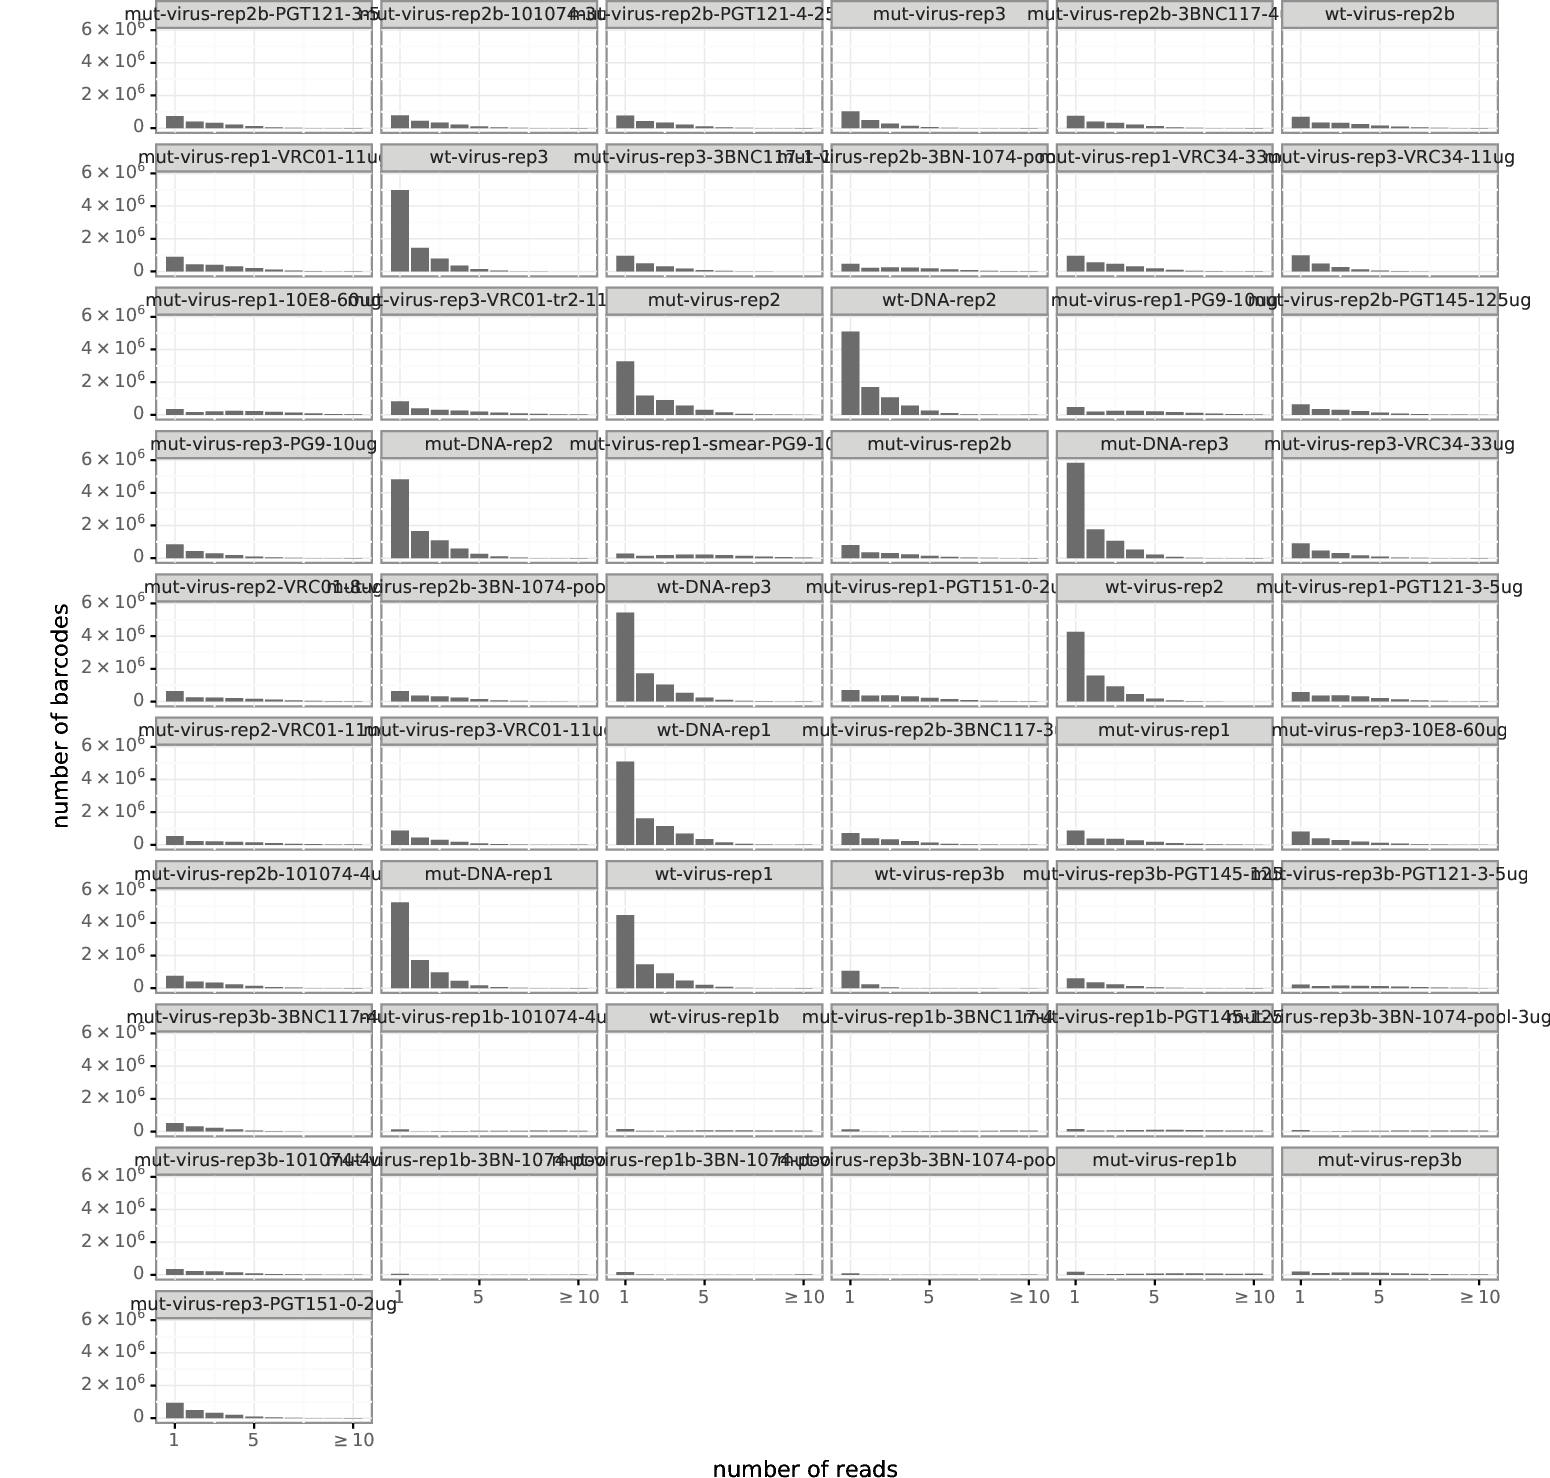

In [10]:
showPDF(countsplotprefix + '_readsperbc.pdf')

The `*_bcstats.pdf` plot below shows statistics on the barcodes. Some of the barcodes had to be discarded because they had too few reads (these are the single-read barcodes in the plot above), a small fraction with adequate reads were not alignable, and the rest aligned to the Env gene properly.
This plot and the one above suggest that probably could have gotten additional depth by sequencing more, since then we would have had more barcodes with multiple reads.

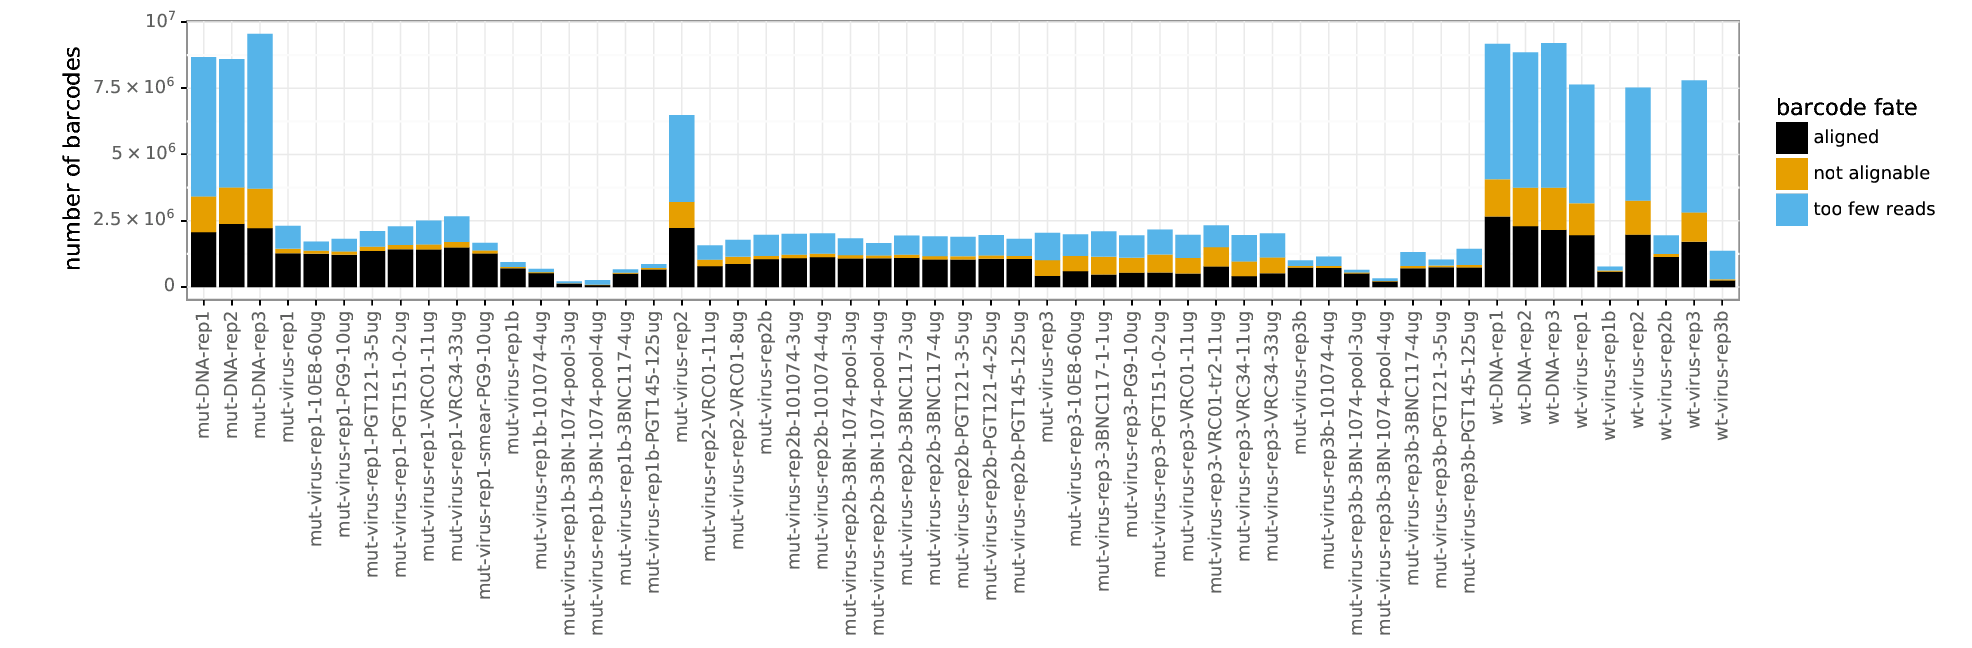

In [11]:
showPDF(countsplotprefix + '_bcstats.pdf', width=600)

The `*_depth.pdf` plot below shows the depth (number of called codons) at each site in the gene. 
For most of the samples, the depth across the gene is fairly uniform, indicating that the subamplicons were pooled fairly evenly.  
Note that some samples (in particular the mock samples) were intentionally sequenced to higher depth than the antibody-selected samples, as we expect to see more diversity in the mock samples. 
Note that the gene was not sequenced past codon site 691, and so there is no coverage there.

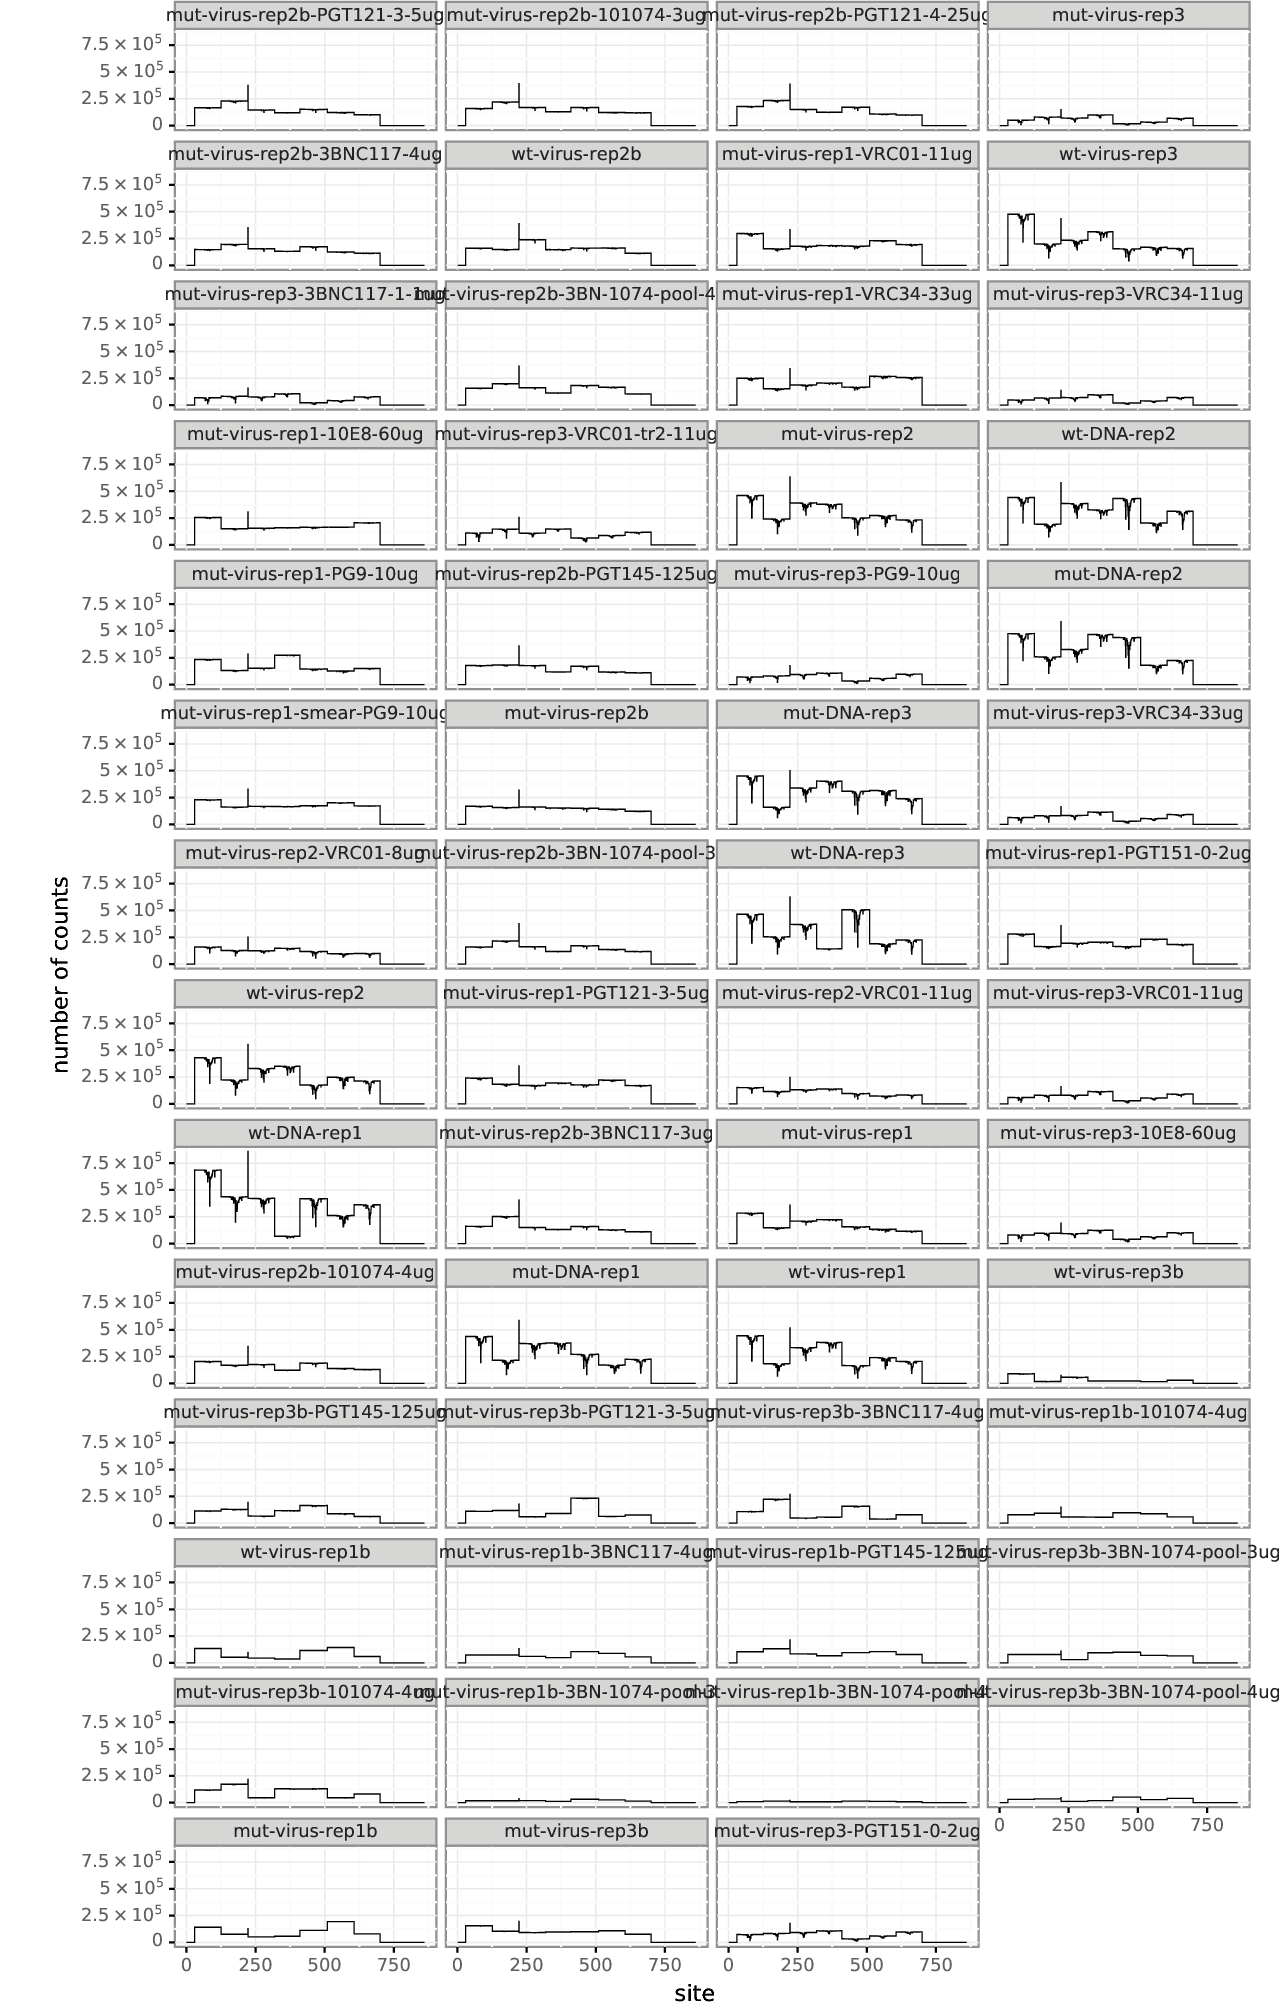

In [12]:
showPDF(countsplotprefix + '_depth.pdf')

The `*_mutfreq.pdf` plot below shows the per-codon frequency of mutations at each site. 
For each PGT151-selected sample, we see a few sites of clear peaks in mutation frequency. 
These peaks tend to occur at the same sites in different replicates, and so presumably represent the sites where antibody-escape mutations are selected. 
There are no such peaks for the mock sample since there is no antibody selection to favor specific mutations.
Note also that the gene was not mutagenized or sequenced past codon site 691, so there are no mutations there.

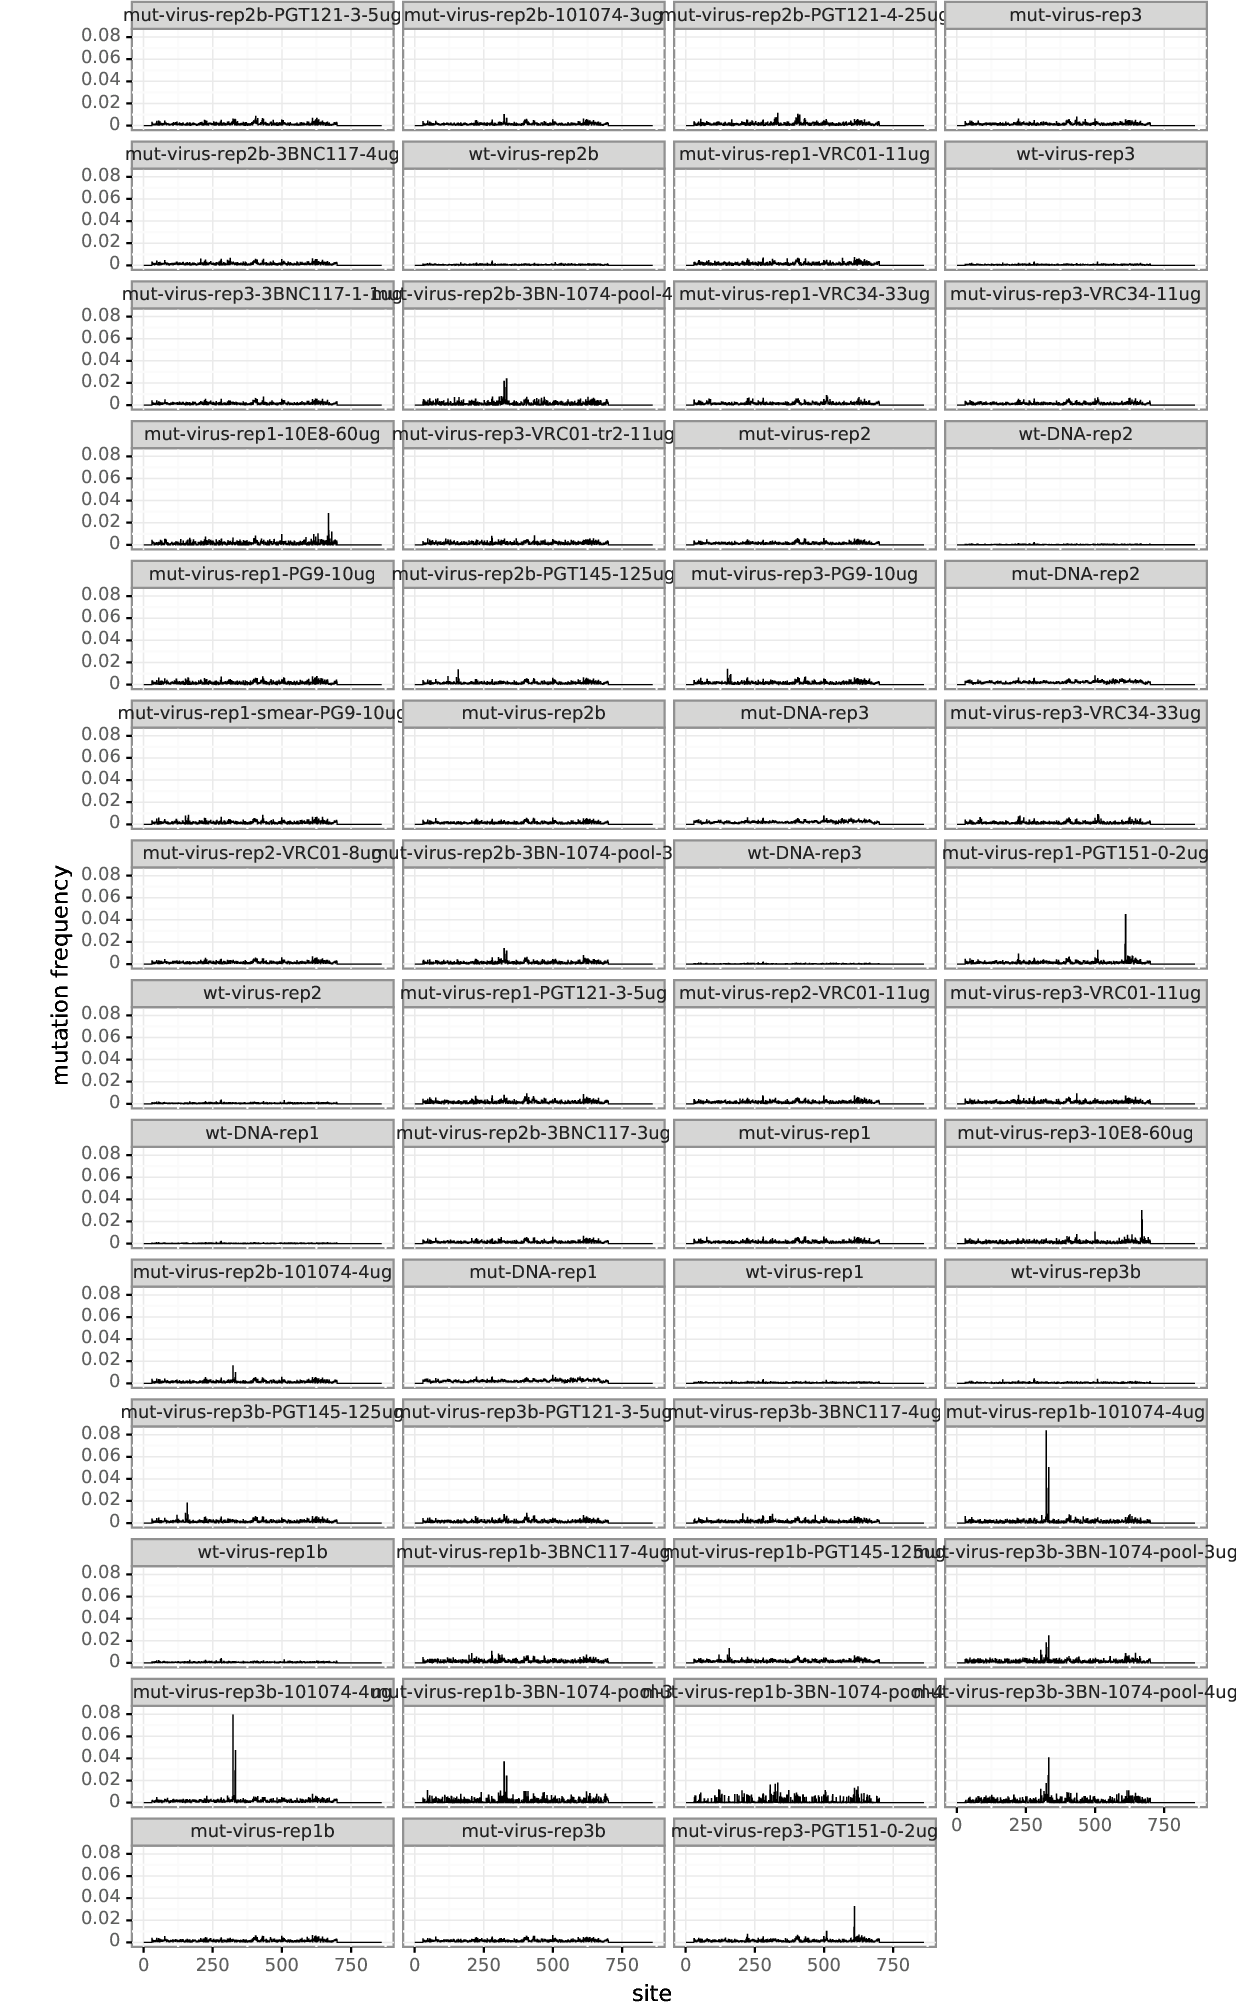

In [13]:
showPDF(countsplotprefix + '_mutfreq.pdf')

The `*_codonmuttypes.pdf` plot below shows the per-codon frequency of nonsynonymous, synonymous, and stop codon mutations across the entire gene. For the PGT151 selected samples, we see an overall increase in the per-codon mutation frequency due to very strong selection for variants with escape mutations.

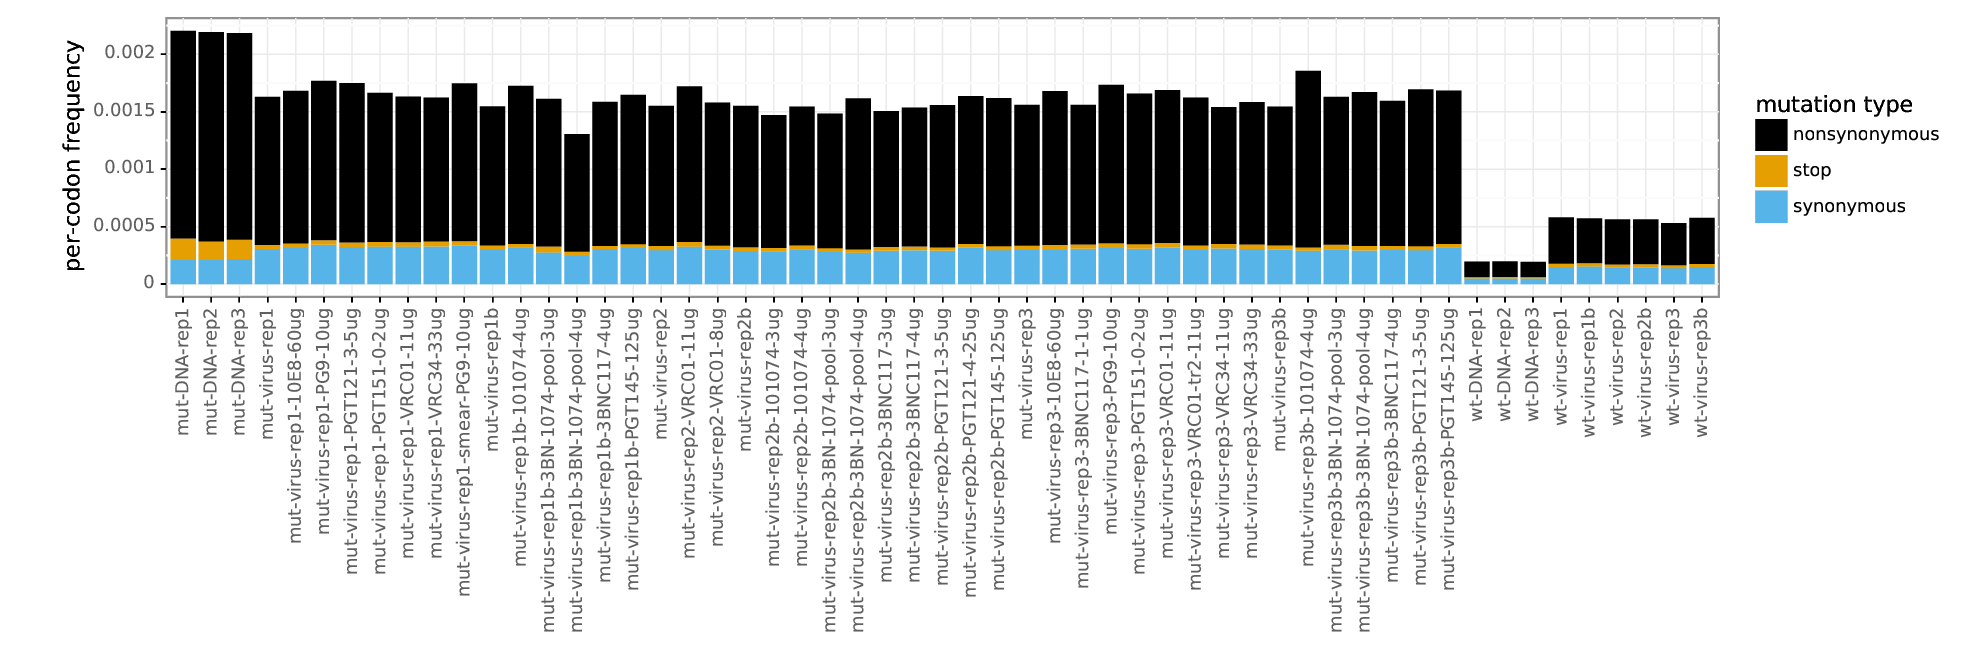

In [14]:
showPDF(countsplotprefix + '_codonmuttypes.pdf', width=600)

The `*_codonntchanges.pdf` plot below shows same data as above but categorizes codon mutations by the number of nucleotides that are changed (e.g., ATG to AAG changes 1 nucleotide, ATG to AAC changes 2 nucleotides, and ATG to CAC changes 3 nucleotides).

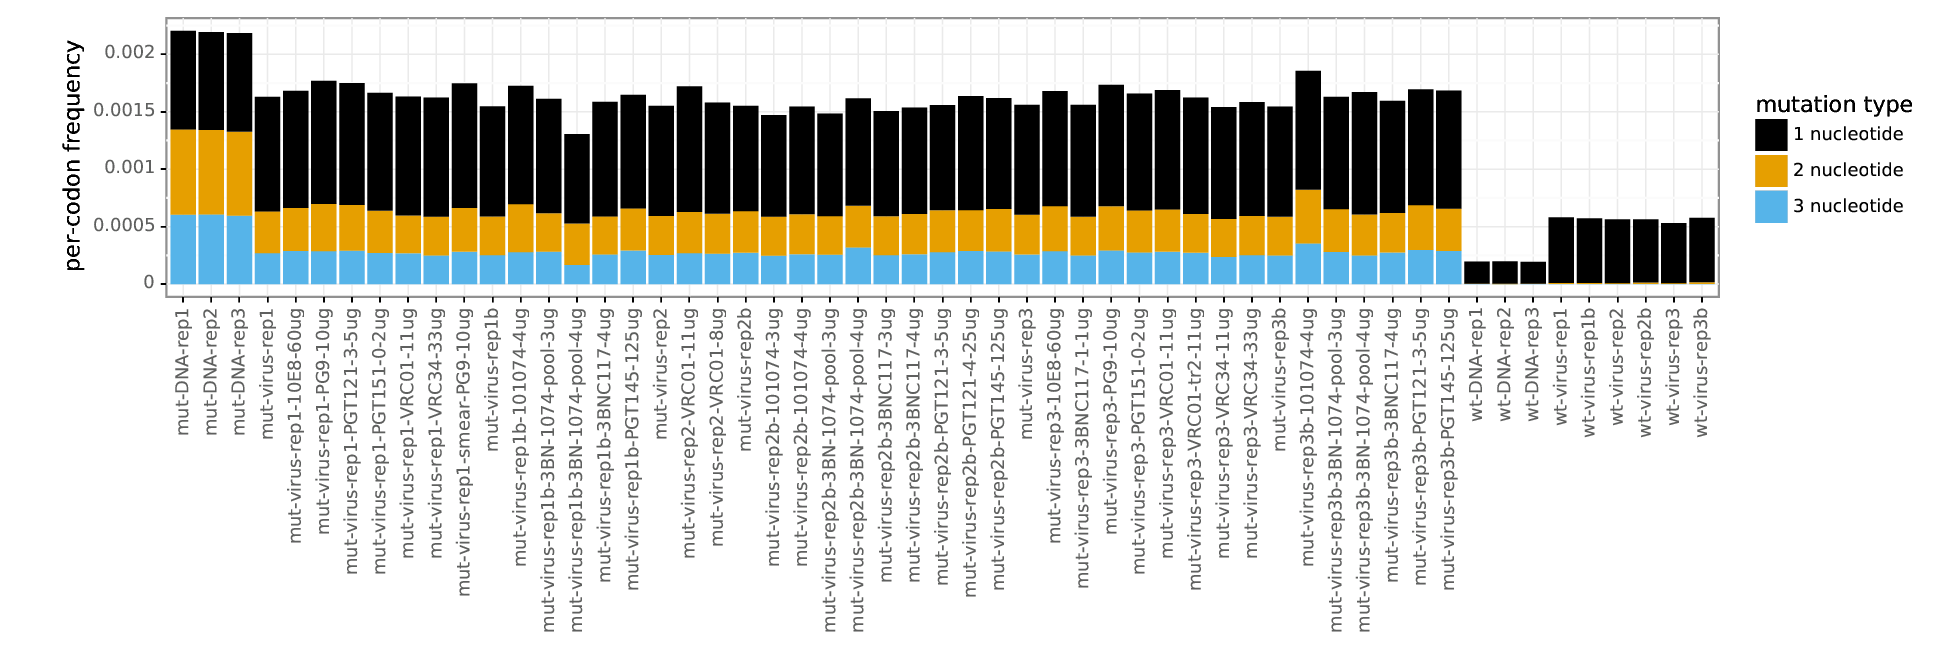

In [15]:
showPDF(countsplotprefix + '_codonntchanges.pdf', width=600)

The `*_singlentchanges.pdf` plot below shows the frequency of each type of nucleotide change among only codon mutations with one nucleotide change. This plot is mostly useful to check if there is a large bias in which mutations appear. In particular, if you are getting oxidative damage (which causes G to T mutations) during the library preparation process, you will see a large excess of C to A or G to T mutations (or both). There is not much oxidative damage in the samples plotted below, which mostly have a fairly even distribution of nucleotide changes.

We do see that transitions (G <-> A and C <-> T) are a bit more common than most of the other types of mutations (all of which are transversions). This is expected, since [PCR based sources of mutations are expected to preferentially introduce transitions](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3720931/). 

This plot would also be important to examine any sign of APOBEC hypermutation (also G <-> A, with preferences for specific motifs) occuring in the HIV genome. One of the reasons we selected the SupT1.R5 cell line was because [there is very little of the APOBEC proteins expressed in  a subclone of SupT1 cells](https://www.ncbi.nlm.nih.gov/pubmed/20308164). In the viral samples, there does appear to be an increase in G to A and C to T mutations. However, we passaged WT virus in these cells and confirmed there were not signs of extensive APOBEC hypermutation in hotspot motifs via deep sequencing of env after passaging. Thus, we do not think there is extensive APOBEC hypermutation in our data, and this increase certain types of mutations in the viral samples is likely due to bias in the viral reverse transcription.

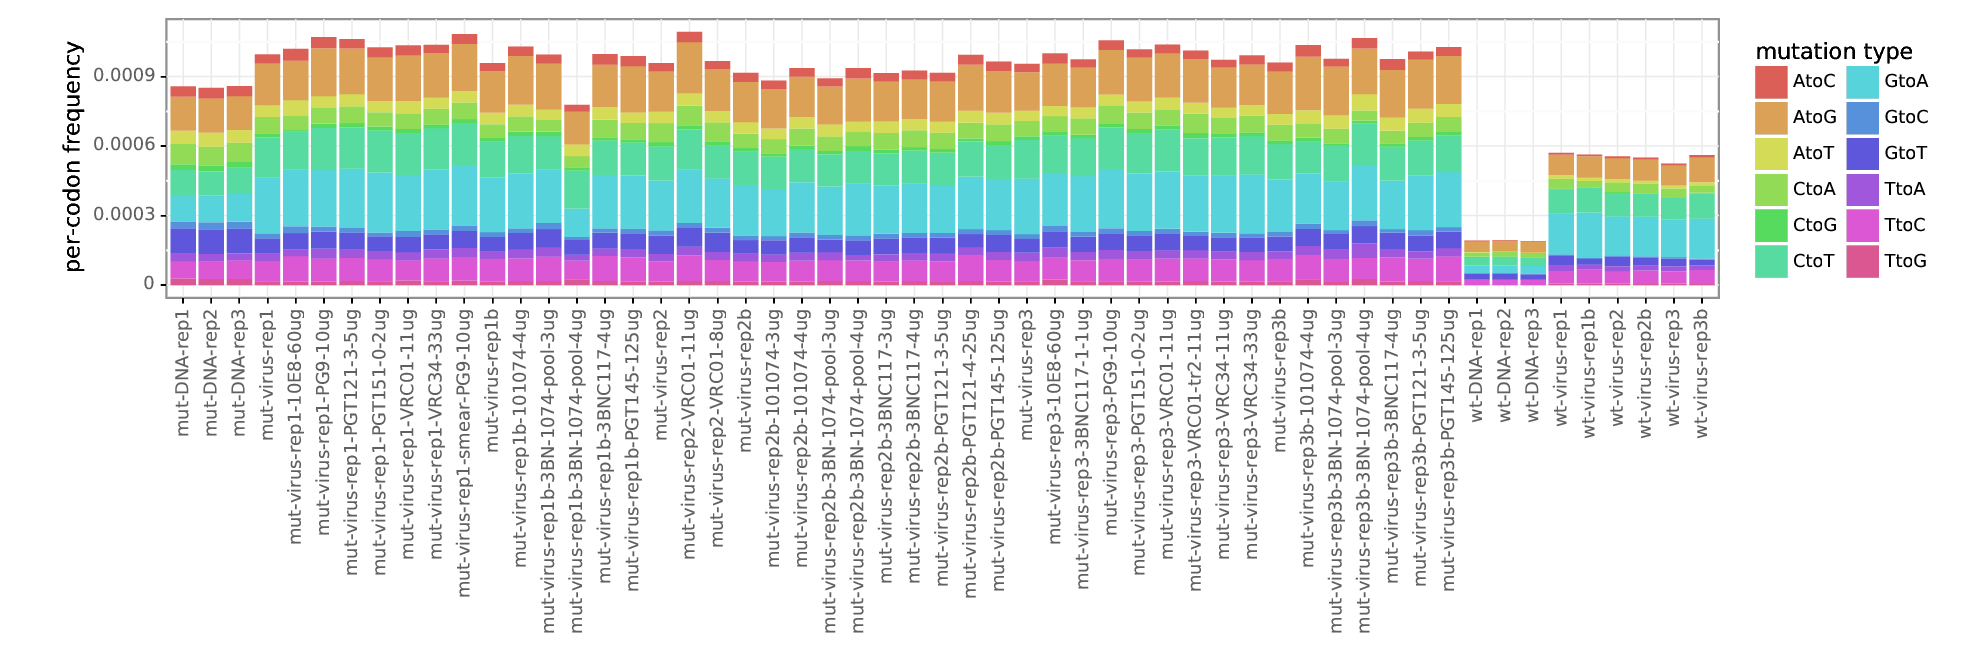

In [16]:
showPDF(countsplotprefix + '_singlentchanges.pdf', width=600)

## Renumber codon counts to HXB2 numbering 
The standard numbering scheme for HIV Env is the [HXB2 numbering scheme](https://www.hiv.lanl.gov/content/sequence/HIV/REVIEWS/HXB2.html).
The file [./data/BF520c2_to_HXB2.csv](./data/BF520c2_to_HXB2.csv) gives the mapping from sequential 1, 2, ... numbering of the BF520 protein sequence to the HXB2 numbering scheme. 
This file was generated by aligning the HXB2 sequence [taken from Genbank](http://www.ncbi.nlm.nih.gov/protein/1906385) with the BF520c2 sequence using the [LANL alignment interface](http://www.hiv.lanl.gov/cgi-bin/VIRALIGN/viralign.cgi) at the protein sequence level. 
Insertions relative to HXB2 are given letter suffixes as [described here](http://www.hiv.lanl.gov/content/sequence/HIV/REVIEWS/HXB2.html).

Additionally, not all residues in BF520 Env were mutagenized. 
The N-terminal signal peptide and the C-terminal cytoplasmic tail were excluded because they seem likely to affect expression level. 
These sites are not listed in the renumbering file, and so are dropped when we do the re-numbering.

To do the re-numbering, we use the [dms_tools2.utils.renumberSites](https://jbloomlab.github.io/dms_tools2/dms_tools2.utils.html#dms_tools2.utils.renumberSites) function from the [dms_tools Python API](https://jbloomlab.github.io/dms_tools2/api.html) to create a new directory that contains all of the re-numbered files with the same name as in the original codon counts directory produced above.

In [17]:
renumberedcountsdir = os.path.join(resultsdir, 'renumberedcounts')

In [18]:
renumberfile = './results/HXB2_numbering/BG505_to_HXB2.csv'

# renumbered counts will go here
renumberedcountsdir = os.path.join(resultsdir, 'renumberedcounts')

# counts files to renumber
countsfiles = glob.glob('{0}/*codoncounts.csv'.format(countsdir))

dms_tools2.utils.renumberSites(renumberfile, countsfiles, missing='drop', 
        outdir=renumberedcountsdir)

## Compute the fraction surviving 
Now we compute the [fraction surviving](https://jbloomlab.github.io/dms_tools2/fracsurvive.html).This caluclation takes into account the level of antibody selection, found in the input file below. We will use mutliple different controls to estimate the error rates to  correct fo, and put the output in its own subdirectory, named according to its control sample. 

This [csv file](/data/BG505_qPCR_master.csv) contains the fraction remaining infectivity for each antibody selected sample, as quatified using pol qPCR and computed based on a standard curve of infecting cells with dilutions of mutant virus (library and experiment specific), with dilutiuons ranging from 0.1 to .0001. 

We first create a batch file to use with [dms2_batch_fracsurvive](https://jbloomlab.github.io/dms_tools2/dms2_batch_fracsurvive.html). 
Note we make the **group** argument the antibody, the **name** argument the replicate, and assign the **sel**, **mock**, and **err** arguments based on the names used for the batch file when generating the counts files above with `dms2_batch_bcsubamp`.
By grouping replicates for the same antibody in the batch file, we tell [dms2_batch_fracsurvive](https://jbloomlab.github.io/dms_tools2/dms2_batch_fracsurvive.html) to analyze these together and take their mean and median.

### Average fraction surviving across multiple antibody dilutions
For select antibodies, we have escape profiles at numerous dilutions. Oftentimes, the antibody concentrations are quite similar (e.g. 3 vs 4 ug/mL), and the single replicate escape profiles look very similar as well. I am averaging across these additional dilutions. 


In [19]:
fracsurvivedir = os.path.join(resultsdir, 'fracsurvive')
if not os.path.isdir(fracsurvivedir):
    os.mkdir(fracsurvivedir)
    
fracsurviveaboveavgdir = os.path.join(resultsdir, 'fracsurviveaboveavg')
if not os.path.isdir(fracsurviveaboveavgdir):
    os.mkdir(fracsurviveaboveavgdir) 

concavg_fracsurvivedir_wtDNActrl = os.path.join(fracsurvivedir, 'concavg_wtDNA_ctrl')
if not os.path.isdir(concavg_fracsurvivedir_wtDNActrl):
    os.mkdir(concavg_fracsurvivedir_wtDNActrl)  
concavg_fracsurviveaboveavgdir_wtDNActrl = os.path.join(fracsurviveaboveavgdir, 'concavg_wtDNA_ctrl')
if not os.path.isdir(concavg_fracsurviveaboveavgdir_wtDNActrl):
    os.mkdir(concavg_fracsurviveaboveavgdir_wtDNActrl)

In [20]:
fracsurvivebatchavg = pd.read_csv("./data/BG505_panel_avgconcentrations_fracsurvive.csv", header =0)
fracsurvivebatchavg = fracsurvivebatchavg.sort_values(by='group')

In [21]:
fracsurvivebatchavgcopy = fracsurvivebatchavg.copy()

#now, add in fracsurvive data
qPCRdata = pd.read_csv('./data/BG505_qPCR_master.csv')
qPCRdata["sel"].replace('virus-', 'virus-rep', regex=True, inplace=True)

qPCRdata  = qPCRdata.sort_values(by='sel')

fracsurvivebatchavg = pd.merge(fracsurvivebatchavgcopy, qPCRdata[['sel', 'libfracsurvive']], 
        left_on = 'sel', right_on= 'sel')
#display(HTML(fracsurvivebatchavg.to_html(index=False)))

names = fracsurvivebatchavg["group"].astype(str) + "-" + fracsurvivebatchavg["name"].astype(str)
names = names.tolist()

We now `run dms2_batch_survive` twice with the following difference:
    1. First we run it simply computing the fraction surviving for each mutation.
    2. Then we run it with the --aboveavg yes option to compute the fraction surviving for each mutation above the overall library average.

Note how the results for these two different runs are output to two different subdirectories.


In [22]:
concavg_fracsurvivebatch_wtDNActrl = fracsurvivebatchavg.copy()
concavg_fracsurvivebatchfile_wtDNA = os.path.join(concavg_fracsurvivedir_wtDNActrl, 'batch.csv')
print("Here is the batch input that we write to the CSV file {0}:".format(concavg_fracsurvivebatchfile_wtDNA))
display(HTML(concavg_fracsurvivebatch_wtDNActrl.to_html(index=False)))
concavg_fracsurvivebatch_wtDNActrl.to_csv(concavg_fracsurvivebatchfile_wtDNA, index=False, encoding='utf-8')


for (arg_aboveavg, outdir) in [('', concavg_fracsurvivedir_wtDNActrl), ('--aboveavg yes', concavg_fracsurviveaboveavgdir_wtDNActrl)]:
    print("\nRunning dms2_batch_fracsurvive {0}and writing output to {1}".format(
            {'':'', '--aboveavg yes':'with `--aboveavg yes` '}[arg_aboveavg], outdir))
    log = !dms2_batch_fracsurvive \
            --summaryprefix summary \
            --batchfile {concavg_fracsurvivebatchfile_wtDNA} \
            --outdir {outdir} \
            --indir {renumberedcountsdir} \
            --use_existing {use_existing} \
            {arg_aboveavg} 
    print("Completed run.")

Here is the batch input that we write to the CSV file ./results/fracsurvive/concavg_wtDNA_ctrl/batch.csv:



Running dms2_batch_fracsurvive and writing output to ./results/fracsurvive/concavg_wtDNA_ctrl
Completed run.

Running dms2_batch_fracsurvive with `--aboveavg yes` and writing output to ./results/fracsurviveaboveavg/concavg_wtDNA_ctrl
Completed run.


Running [dms2_batch_fracsurvive](https://jbloomlab.github.io/dms_tools2/dms2_batch_fracsurvive.html) creates plots showing how the fraction surviving estimates correlate among replicates. 
These plots have names like `summary_*-avgfracsurvivecorr.pdf` and `summary_*-maxfracsurvivecorr.pdf`. 
Note that the plots show the correlations between all pairs, and also on the diagonal show the density of the different selection values for each replicates (most of them are close to zero).

In [23]:
concavg_fracsurviveprefix = os.path.join(concavg_fracsurvivedir_wtDNActrl, 'summary_')
groups = fracsurvivebatchavg['group'].unique()
groups = ['VRC01', '3BNC117', 'PGT121', '101074', 'PG9', 'PGT145', 'PGT151', 'VRC34', '10E8', '3BN-1074-pool']


avgfracsurvive correlations:


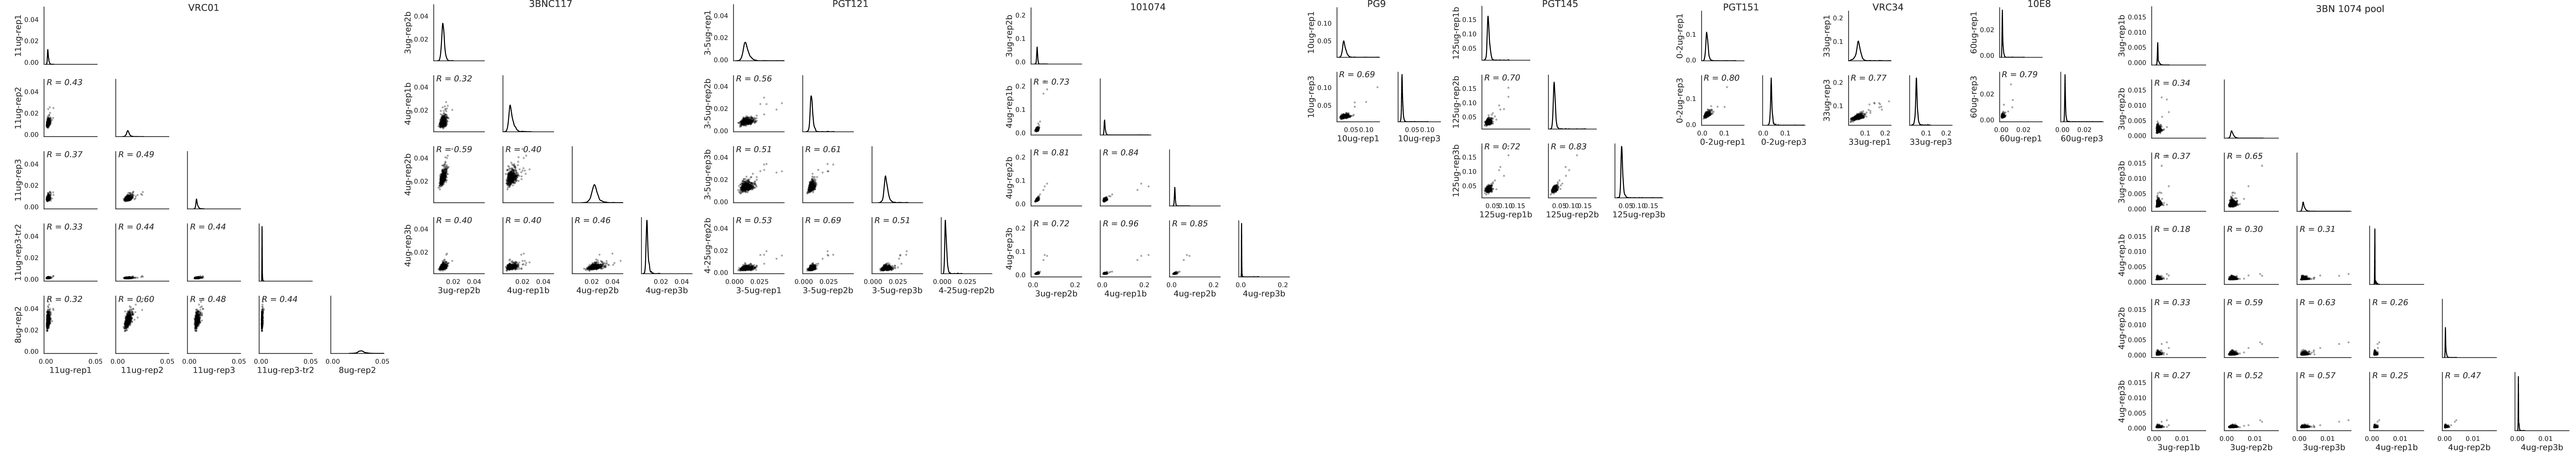


maxfracsurvive correlations:


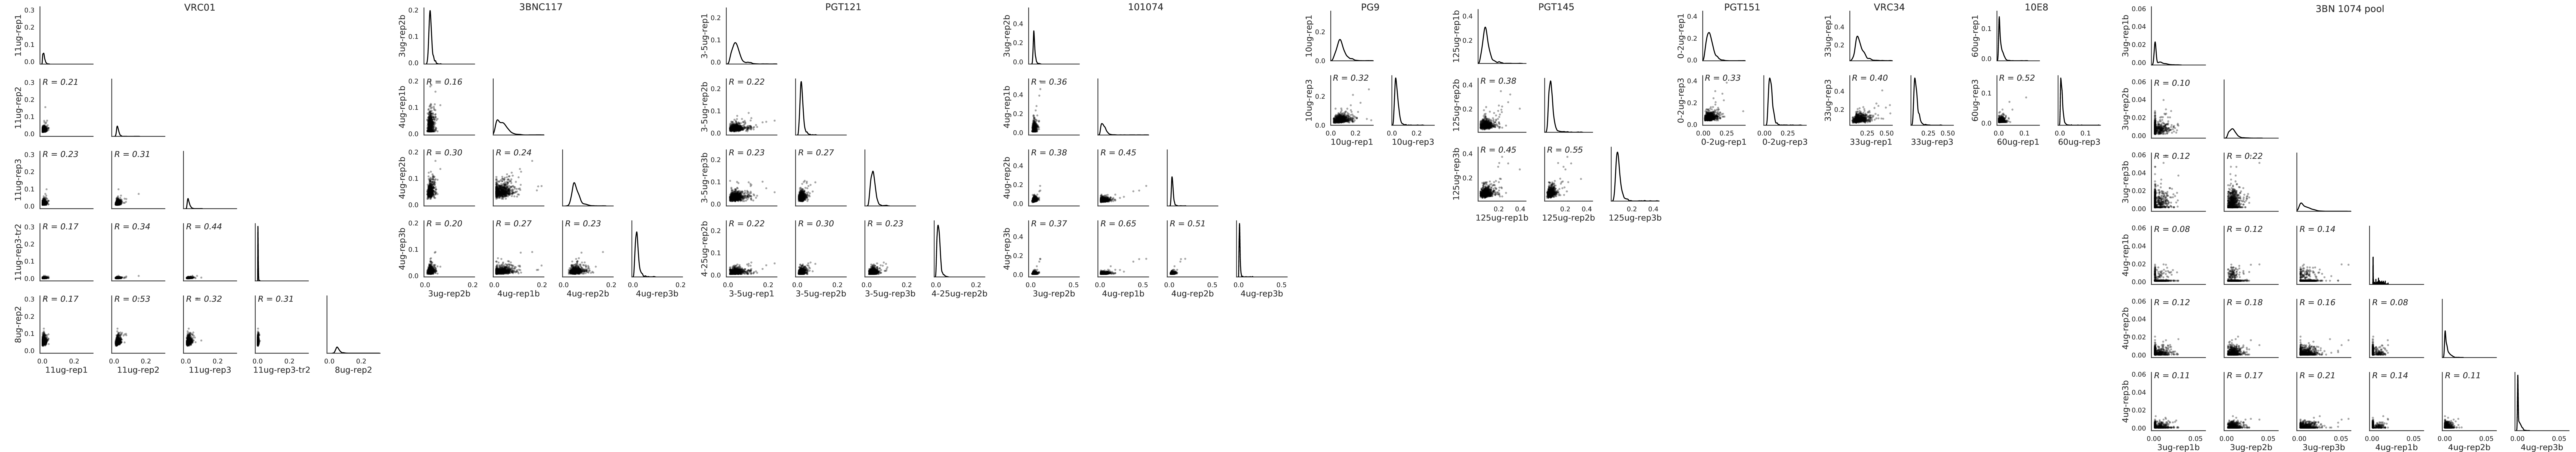

In [24]:
for seltype in ['avgfracsurvive', 'maxfracsurvive']:
    print("\n{0} correlations:".format(seltype))
    plots = []
    for g in groups:
        plot = concavg_fracsurviveprefix + g + '-' + seltype + 'corr.pdf'
        if os.path.isfile(plot):
            plots.append(plot)
        else:
            print("{0} does not exist.".format(plot))
    showPDF(plots, width=1800)

Next, we can look at the correlation for the `fraction surviving above average` values.


avgfracsurvive correlations:


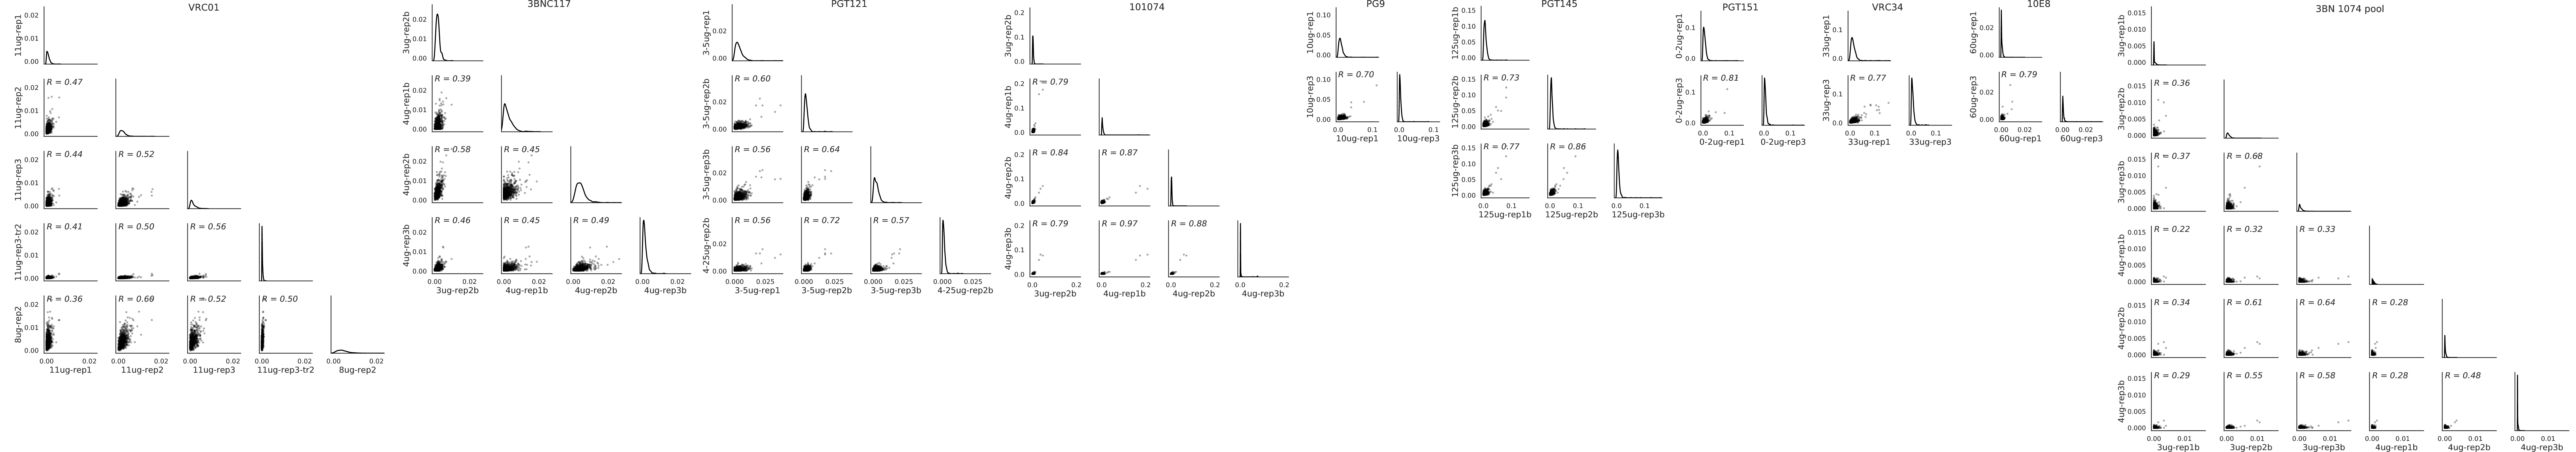


maxfracsurvive correlations:


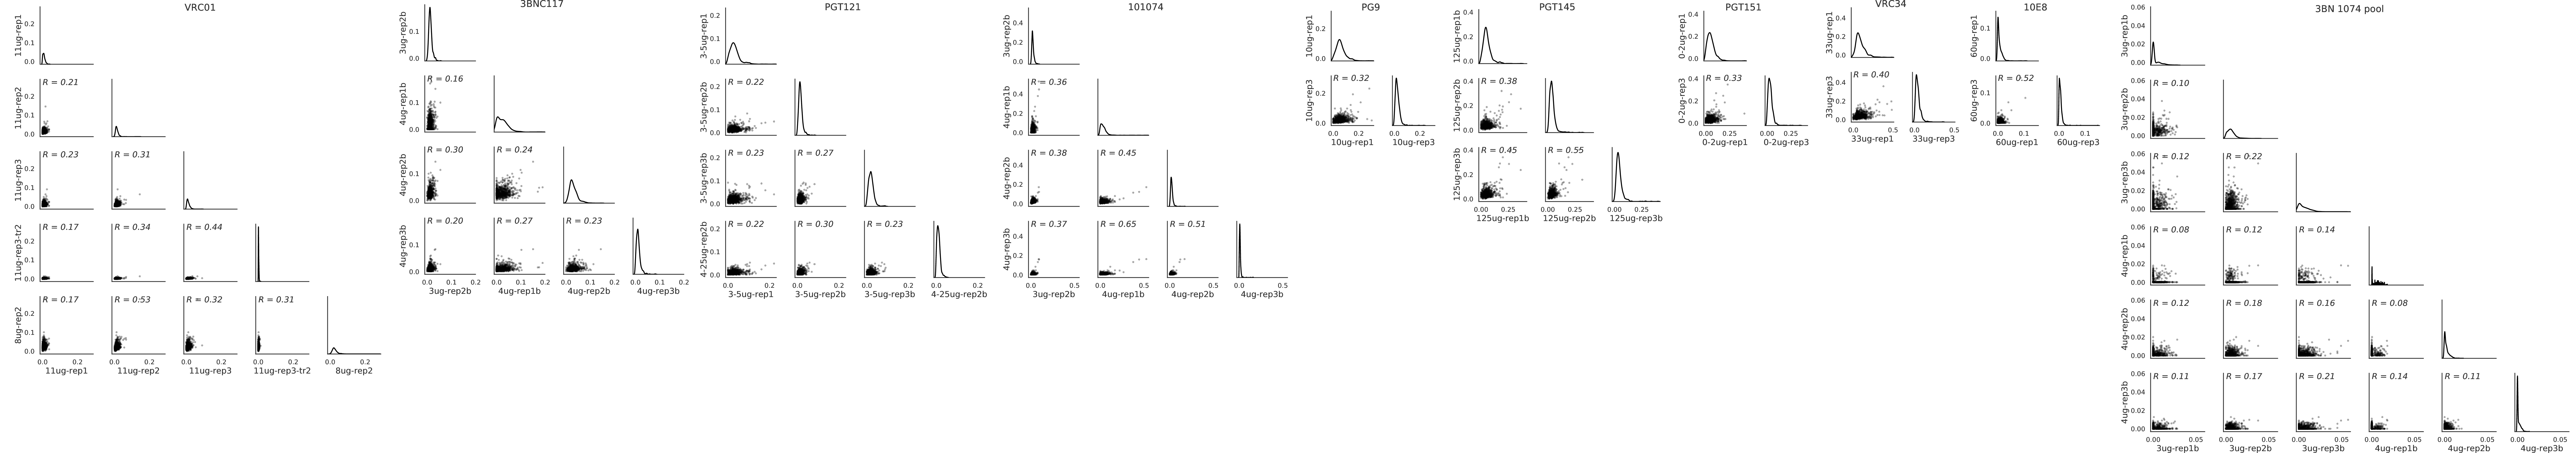

In [25]:
concavg_fracsurviveaboveavgprefix = os.path.join(concavg_fracsurviveaboveavgdir_wtDNActrl, 'summary_')

for seltype in ['avgfracsurvive', 'maxfracsurvive']:
    print("\n{0} correlations:".format(seltype))
    plots = []
    for g in groups:
        plot = concavg_fracsurviveaboveavgprefix + g + '-' + seltype + 'corr.pdf'
        if os.path.isfile(plot):
            plots.append(plot)
        else:
            print("{0} does not exist.".format(plot))
    showPDF(plots, width=1800)

Now, lets look at the median `average fraction suurviving above average` for each antibody.

In [26]:
phiaboveavg_sub_tuple = [
 ('PGT121', './results/fracsurviveaboveavg/concavg_wtDNA_ctrl/summary_PGT121-mediansitefracsurvive.csv'),
 ('VRC01', './results/fracsurviveaboveavg/concavg_wtDNA_ctrl/summary_VRC01-mediansitefracsurvive.csv'),
 ('101074', './results/fracsurviveaboveavg/concavg_wtDNA_ctrl/summary_101074-mediansitefracsurvive.csv'),
 ('3BNC117', './results/fracsurviveaboveavg/concavg_wtDNA_ctrl/summary_3BNC117-mediansitefracsurvive.csv'),
 ('VRC34', './results/fracsurviveaboveavg/concavg_wtDNA_ctrl/summary_VRC34-mediansitefracsurvive.csv'),
 ('PG9', './results/fracsurviveaboveavg/concavg_wtDNA_ctrl/summary_PG9-mediansitefracsurvive.csv'),
 ('PGT151', './results/fracsurviveaboveavg/concavg_wtDNA_ctrl/summary_PGT151-mediansitefracsurvive.csv'),
 ('PGT145', './results/fracsurviveaboveavg/concavg_wtDNA_ctrl/summary_PGT145-mediansitefracsurvive.csv'),
 ('10E8', './results/fracsurviveaboveavg/concavg_wtDNA_ctrl/summary_10E8-mediansitefracsurvive.csv')]

names = []
diffselfiles = []
phiaboveavg_dict = {}
for tup in phiaboveavg_sub_tuple:
    names.append(tup[0])
    diffselfiles.append(tup[1])
    phiaboveavg_dict[tup[0]] = tup[1]

In [27]:
import warnings
warnings.filterwarnings('ignore')

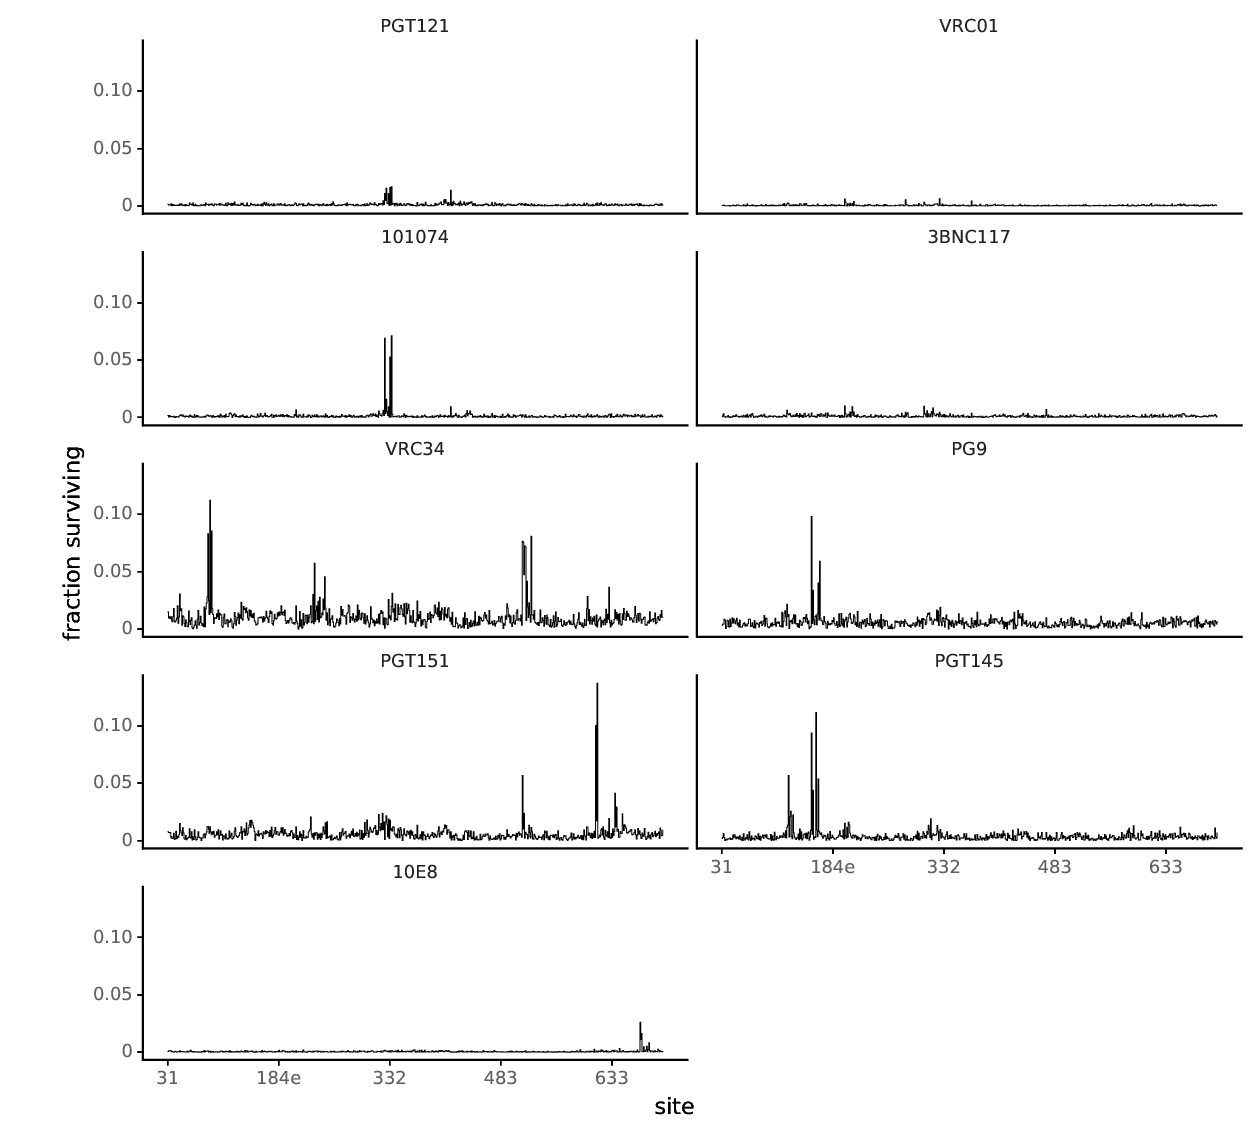

In [28]:
diffseltype = "avgfracsurvive"
plotfile = "./results/fracsurviveaboveavg/concavg_wtDNA_ctrl/Ab_subset_median_avgsitefracsurvive.pdf"
dms_tools2.plot.plotSiteDiffSel(names, diffselfiles, plotfile, diffseltype, maxcol=2, white_bg=True)
showPDF(plotfile)

In [29]:
groups = concavg_fracsurvivebatch_wtDNActrl['group'].unique()
#print(groups)

In [30]:
for antibody in groups:
    mutdiffsel = os.path.join(concavg_fracsurviveaboveavgdir_wtDNActrl, 'summary_{0}-medianmutfracsurvive.csv'.format(antibody))
    logoplot = os.path.join(concavg_fracsurviveaboveavgdir_wtDNActrl, '{0}-median_fracsurvive.pdf'.format(antibody))
        #scale bar unit is maximum effect
    mutdiffseldf = pd.read_csv(mutdiffsel)
    scaleunit = '{0:.1g}'.format(mutdiffseldf['mutfracsurvive'].max())
    scalelabel = '"fraction surviving above avg = {0}"'.format(scaleunit)
    logoname = '{0}-median'.format(antibody)
    print("Creating logo plot for {0} from {1}".format(antibody, mutdiffsel))
    log = !dms2_logoplot \
            --fracsurvive {mutdiffsel} \
            --name {logoname} \
            --outdir {concavg_fracsurviveaboveavgdir_wtDNActrl} \
            --sepline no \
            --nperline 84 \
            --overlay1 {mutdiffsel} wildtype wildtype \
            --scalebar {scaleunit} {scalelabel} \
            --underlay yes \
            --use_existing {use_existing}
    #showPDF(logoplot)
    
    mutdiffsel = os.path.join(concavg_fracsurvivedir_wtDNActrl, 'summary_{0}-medianmutfracsurvive.csv'.format(antibody))
    logoplot = os.path.join(concavg_fracsurvivedir_wtDNActrl, '{0}-median_fracsurvive.pdf'.format(antibody))
        #scale bar unit is maximum effect
    mutdiffseldf = pd.read_csv(mutdiffsel)
    scaleunit = '{0:.1g}'.format(mutdiffseldf['mutfracsurvive'].max())
    scalelabel = '"fraction surviving = {0}"'.format(scaleunit)
    logoname = '{0}-median'.format(antibody)
    print("Creating logo plot for {0} from {1}".format(antibody, mutdiffsel))
    log = !dms2_logoplot \
            --fracsurvive {mutdiffsel} \
            --name {logoname} \
            --outdir {concavg_fracsurvivedir_wtDNActrl} \
            --sepline no \
            --nperline 84 \
            --overlay1 {mutdiffsel} wildtype wildtype \
            --scalebar {scaleunit} {scalelabel} \
            --underlay yes \
            --use_existing {use_existing}
    #showPDF(logoplot)

Creating logo plot for 101074 from ./results/fracsurviveaboveavg/concavg_wtDNA_ctrl/summary_101074-medianmutfracsurvive.csv
Creating logo plot for 101074 from ./results/fracsurvive/concavg_wtDNA_ctrl/summary_101074-medianmutfracsurvive.csv
Creating logo plot for 10E8 from ./results/fracsurviveaboveavg/concavg_wtDNA_ctrl/summary_10E8-medianmutfracsurvive.csv
Creating logo plot for 10E8 from ./results/fracsurvive/concavg_wtDNA_ctrl/summary_10E8-medianmutfracsurvive.csv
Creating logo plot for 3BN-1074-pool from ./results/fracsurviveaboveavg/concavg_wtDNA_ctrl/summary_3BN-1074-pool-medianmutfracsurvive.csv
Creating logo plot for 3BN-1074-pool from ./results/fracsurvive/concavg_wtDNA_ctrl/summary_3BN-1074-pool-medianmutfracsurvive.csv
Creating logo plot for 3BNC117 from ./results/fracsurviveaboveavg/concavg_wtDNA_ctrl/summary_3BNC117-medianmutfracsurvive.csv
Creating logo plot for 3BNC117 from ./results/fracsurvive/concavg_wtDNA_ctrl/summary_3BNC117-medianmutfracsurvive.csv
Creating logo pl

## Compute the differential selection and correlations between replicates
Now we compute the [differential selection](https://jbloomlab.github.io/dms_tools2/diffsel.html) for each replicate, using the *wt-DNA* controls to estimate the error rates.
We also compute the average differential selection across replicates.

We first create a batch file to use with [dms2_batch_diffsel](https://jbloomlab.github.io/dms_tools2/dms2_batch_diffsel.html#dms2-batch-diffsel). 
Note we make the **group** argument the antibody, the **name** argument the replicate, and assign the **sel**, **mock**, and **err** arguments based on the names used for the batch file when generating the counts files above with `dms2_batch_bcsubamp`.
By grouping replicates for the same antibody in the batch file, we tell [dms2_batch_diffsel](https://jbloomlab.github.io/dms_tools2/dms2_batch_diffsel.html#dms2-batch-diffsel) to analyze these together and take their mean and median.

This data differential selection **is not** analyzed in the paper. However, it may of use to other analyses, and is thus included as supplemental data.

In [31]:
# put diffsel values here
diffseldir = os.path.join(resultsdir, 'diffsel')
if not os.path.isdir(diffseldir):
    os.mkdir(diffseldir)

diffsel_wtDNActrl_dir = os.path.join(diffseldir, 'wtDNA_ctrl')
if not os.path.isdir(diffsel_wtDNActrl_dir):
    os.mkdir(diffsel_wtDNActrl_dir)
    

diffselbatch_wtDNActrl = fracsurvivebatchavg.copy()

diffselbatchfile_wtDNActrl = os.path.join(diffsel_wtDNActrl_dir, 'batch.csv')
print("Here is the batch file that we write to CSV format to use as input:")
display(HTML(diffselbatch_wtDNActrl.to_html(index=False)))
diffselbatch_wtDNActrl.to_csv(diffselbatchfile_wtDNActrl, index=False)

Here is the batch file that we write to CSV format to use as input:


In [32]:
log = !dms2_batch_diffsel \
        --summaryprefix summary \
        --batchfile {diffselbatchfile_wtDNActrl} \
        --outdir {diffsel_wtDNActrl_dir} \
        --indir {renumberedcountsdir} \
        --use_existing {use_existing}

## Identifying significant escape sites and mutations.
As explained by Jesse [here](https://github.com/jbloomlab/computational_notebooks/blob/master/jbloom/2018/MAP_Identifying_Significant_Escape/analysis_notebook.ipynb), we will use [dms_tools2.plot.findSigSel](https://jbloomlab.github.io/dms_tools2/dms_tools2.plot.html#dms_tools2.plot.findSigSel) to fit a [gamma distribution](https://en.wikipedia.org/wiki/Gamma_distribution) to binned `avgfracsurvive`, `maxfracsurvive`, or `mutfracsurive` values for each antibody using robust regression. We then identify sites/mutations that are largfer than expected from this distribution at different FDRs. These are significantly higher than expected from a gamma-fit distribution. 

In [33]:
antibodies = []
datafiles = []
for tup in phiaboveavg_sub_tuple:
    antibodies.append(tup[0])
    datafiles.append(tup[1])

fitresultsdir = './results/fracsurvive/concavg_wtDNA_ctrl/SignificantEscape/'
if not os.path.isdir(fitresultsdir):
    os.mkdir(fitresultsdir)
    

def sigSitesDisplay(valcol, fdrs, antibodies, datafiles):
    """Display the significant sites at some FDRs.
    
    Args:
        `valcol` (str): column to use, `maxfracsurvive` or `avgfracsurvive`
        `fdr` (float): FDR
        `antibodies` (list): antibody names
        `datafiles` (list): sitefracsurvive files
    """
    
    for (a, datafile) in zip(antibodies, datafiles):
        print("\n*************************\nAnalyzing antibody {0}".format(a))
        plots = []
        df_printed = True
        for fdr in sorted(fdrs, reverse=True):
            plot = os.path.join(fitresultsdir, '{0}_{1}_{2}_fit.pdf'.format(a, valcol, fdr))
            df = dms_tools2.plot.findSigSel(
                    pd.read_csv(datafile),
                    valcol,
                    plot,
                    fdr=fdr,
                    title='{0} at FDR {1}'.format(a, fdr),
                    )[0]
            plots.append(plot)
            if not df_printed:
                print(df.query('sig').sort_values('Q')[['site', valcol, 'Q']]
                        .reset_index(drop=True))
                df_printed = True # only print for lowest FDR

        showPDF(plots, width=400)

sigsites = {}
def sigSitesDisplaySave(valcol, fdrs, antibodies, datafiles, sigsitedict):
    """Display the significant sites at a single FDR, and saves that list of sites to s dictionary keyed by antibody
    
    Args:
        `valcol` (str): column to use, `maxfracsurvive` or `avgfracsurvive`
        `fdr` (float): FDR
        `antibodies` (list): antibody names
        `datafiles` (list): sitefracsurvive files
    """
    
    for (a, datafile) in zip(antibodies, datafiles):
        print("\n*************************\nAnalyzing antibody {0}".format(a))
        plots = []
        df_printed = False
        for fdr in sorted(fdrs, reverse=True):
            if  len(fdrs)>1:
                raise NameError('only 1 FDR allowed for this function')
            else:
                plot = os.path.join(fitresultsdir, '{0}_{1}_{2}_fit.pdf'.format(a, valcol, fdr))
                df = dms_tools2.plot.findSigSel(
                        pd.read_csv(datafile),
                        valcol,
                        plot,
                        fdr=fdr,
                        title='{0} at FDR {1}'.format(a, fdr),
                        )[0]
                plots.append(plot)
                if not df_printed:
                    print(df.query('sig').sort_values('Q')[['site', valcol, 'Q']]
                            .reset_index(drop=True))
                    df_printed = True # only print for lowest FDR
                    siglist = df.query('sig')['site'].tolist()
                    
                    print(siglist)
                    sigsitedict[a] = siglist
        showPDF(plots, width=400)

In [34]:
notaboveavgdatafiles =[]
for file in datafiles:
    mutfile = file.replace("aboveavg","")
    notaboveavgdatafiles.append(mutfile)

First we look fo sites of significant escape using the `avgfracsurvive` for a site.


We also print the Q-values for all sites found at even the most lenient FDR: the Q values are the minimum FDR at which each site would be called:



*************************
Analyzing antibody PGT121
   site  avgfracsurvive             Q
0   332        0.024310  7.280247e-37
1   334        0.024095  1.602602e-36
2   327        0.023480  7.285786e-35
3   415        0.021166  3.354801e-28
4   330        0.018814  1.315166e-21
5   325        0.017649  1.802771e-18
6   408        0.013142  4.285658e-07
7   406        0.013012  7.434047e-07
8   428        0.011937  1.438264e-04
9   323        0.011859  1.874538e-04
10  443        0.011695  3.683346e-04
11  419        0.011604  4.877624e-04
12  326        0.011598  4.877624e-04
13  471        0.011150  3.368206e-03
14  380        0.011071  4.424757e-03
['332', '334', '327', '415', '330', '325', '408', '406', '428', '323', '443', '419', '326', '471', '380']


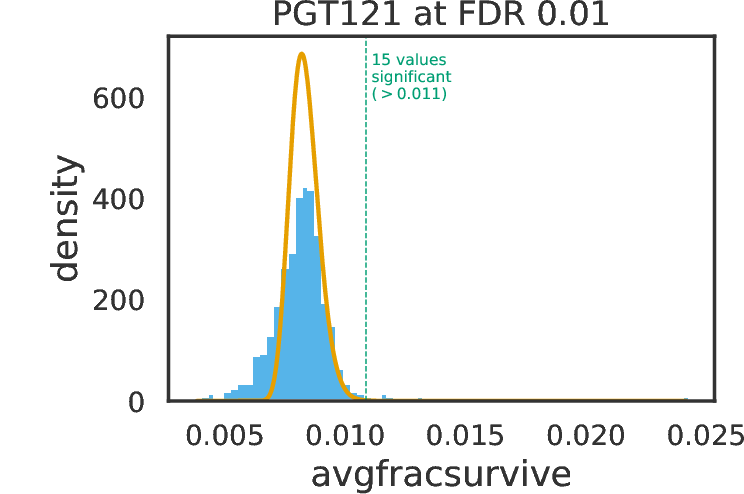


*************************
Analyzing antibody VRC01
  site  avgfracsurvive         Q
0  279        0.013127  0.000001
1  326        0.012705  0.000004
2  369        0.012131  0.000036
3  197        0.011616  0.000227
4  209        0.011280  0.000693
['279', '326', '369', '197', '209']


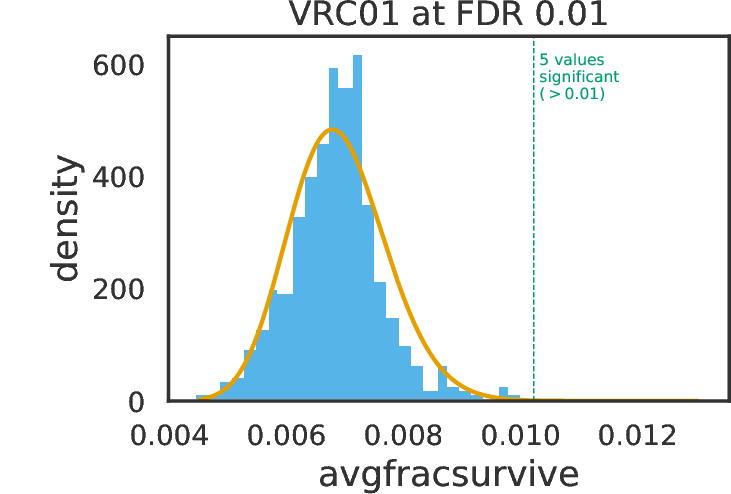


*************************
Analyzing antibody 101074
  site  avgfracsurvive             Q
0  334        0.083565  1.699945e-93
1  325        0.079513  1.616819e-87
2  332        0.065061  1.441350e-65
3  327        0.030080  9.747974e-16
4  415        0.020839  4.714639e-05
5  330        0.020482  9.028978e-05
6  204        0.018541  5.559311e-03
7  441        0.018291  8.161985e-03
8  323        0.018230  8.208745e-03
['334', '325', '332', '327', '415', '330', '204', '441', '323']


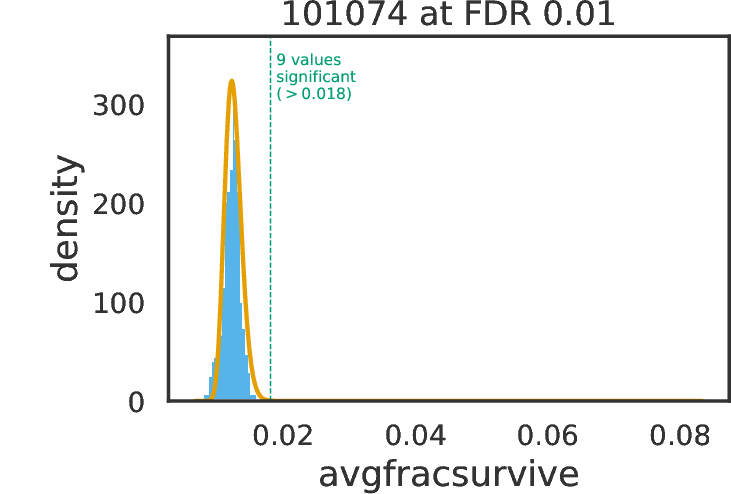


*************************
Analyzing antibody 3BNC117
   site  avgfracsurvive             Q
0   207        0.020230  1.450338e-14
1   304        0.019376  7.479867e-13
2   197        0.017588  4.195616e-09
3   318        0.017310  1.174367e-08
4   471        0.016126  1.888337e-06
5   279        0.015686  9.873693e-06
6   119        0.015012  1.217925e-04
7   308        0.014894  1.599698e-04
8   209        0.014873  1.599698e-04
9   206        0.014474  6.228761e-04
10  182        0.014292  1.076830e-03
11  120        0.014017  2.490804e-03
12  204        0.013997  2.490804e-03
13  369        0.013947  2.736649e-03
14  274        0.013707  5.590962e-03
['207', '304', '197', '318', '471', '279', '119', '308', '209', '206', '182', '120', '204', '369', '274']


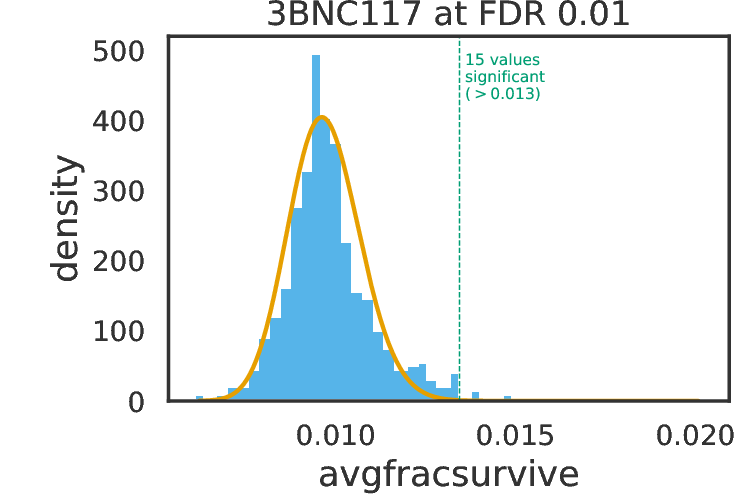


*************************
Analyzing antibody VRC34
   site  avgfracsurvive             Q
0    88        0.168466  4.982772e-46
1    85        0.139939  1.267549e-26
2    90        0.139818  1.267549e-26
3   524        0.137609  2.108522e-25
4   512        0.133032  8.437063e-23
5   513        0.131739  3.861250e-22
6   515        0.128465  2.226130e-20
7   516        0.128058  3.253790e-20
8   229        0.113303  6.729977e-13
9   514        0.101745  3.486680e-08
10  243        0.099620  1.881581e-07
11  518        0.097588  8.819269e-07
12  629        0.088882  4.017079e-04
['88', '85', '90', '524', '512', '513', '515', '516', '229', '514', '243', '518', '629']


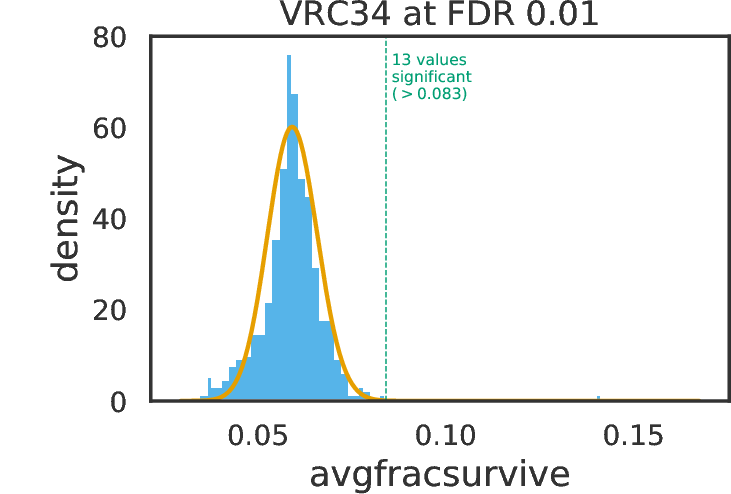


*************************
Analyzing antibody PG9
  site  avgfracsurvive             Q
0  160        0.118743  1.078314e-24
1  171        0.079040  6.917761e-13
2  169        0.059580  2.073216e-07
3  162        0.053581  7.291202e-06
['160', '171', '169', '162']


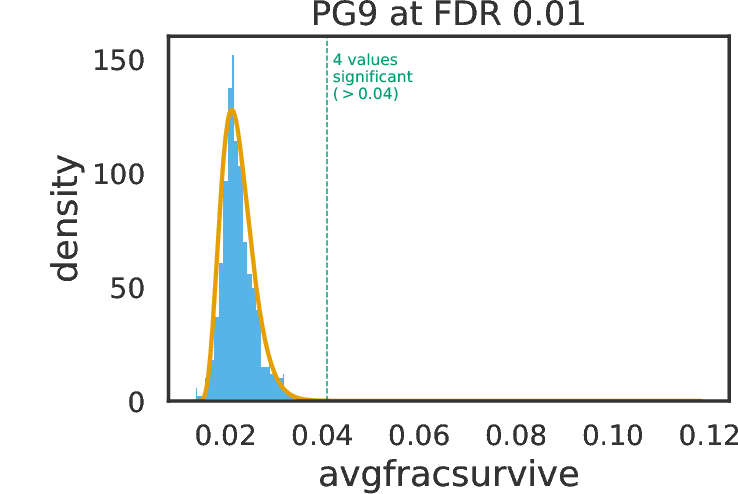


*************************
Analyzing antibody PGT151
    site  avgfracsurvive              Q
0    613        0.164959  4.341711e-119
1    611        0.128221   8.323795e-75
2    512        0.084171   1.383705e-29
3    637        0.068534   6.475910e-17
4    639        0.055386   2.819783e-08
5    514        0.050072   1.756965e-05
6    647        0.049533   2.520633e-05
7   322a        0.049504   2.520633e-05
8    318        0.047968   1.217180e-04
9    327        0.047326   2.166255e-04
10   224        0.045166   1.729260e-03
11   629        0.044612   2.684210e-03
12   142        0.043153   9.344585e-03
['613', '611', '512', '637', '639', '514', '647', '322a', '318', '327', '224', '629', '142']


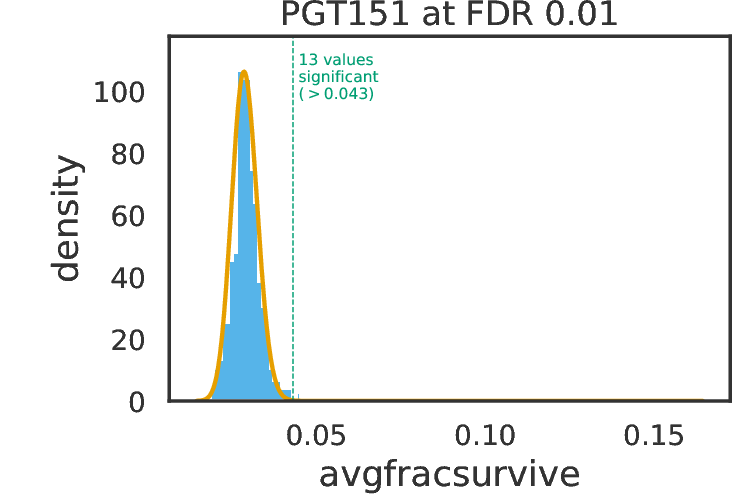


*************************
Analyzing antibody PGT145
   site  avgfracsurvive              Q
0   166        0.141911  3.166184e-108
1   160        0.124549   2.239852e-86
2   121        0.086778   9.237168e-42
3   169        0.081401   4.545322e-36
4   162        0.075164   1.140193e-29
5   127        0.052511   2.245323e-09
6   124        0.052278   2.869238e-09
7   315        0.048625   9.730247e-07
8   123        0.048274   1.484242e-06
9   202        0.045963   4.038539e-05
10  197        0.045278   9.551292e-05
11  312        0.044292   3.317591e-04
12  203        0.043172   1.296733e-03
['166', '160', '121', '169', '162', '127', '124', '315', '123', '202', '197', '312', '203']


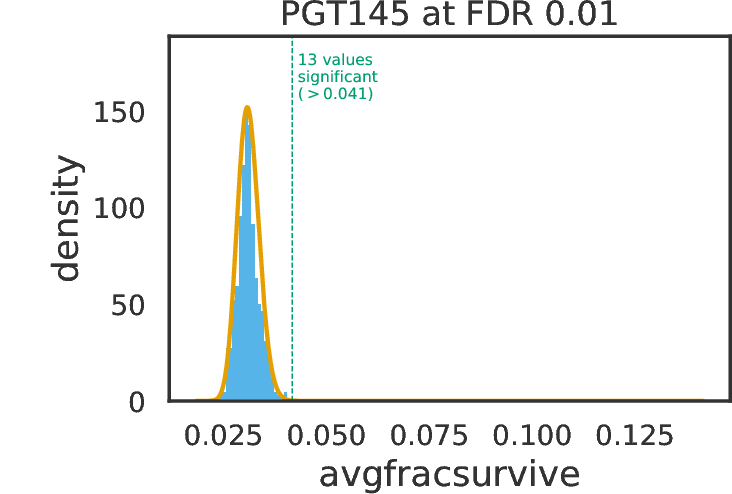


*************************
Analyzing antibody 10E8
  site  avgfracsurvive             Q
0  671        0.027881  9.790832e-58
1  673        0.018049  1.456236e-34
2  672        0.012848  1.824746e-22
3  683        0.009769  2.005994e-15
4  680        0.006969  3.908782e-09
5  676        0.006250  1.314851e-07
6  643        0.004657  3.281406e-04
7  682        0.004029  5.893569e-03
8  609        0.003970  6.908416e-03
['671', '673', '672', '683', '680', '676', '643', '682', '609']


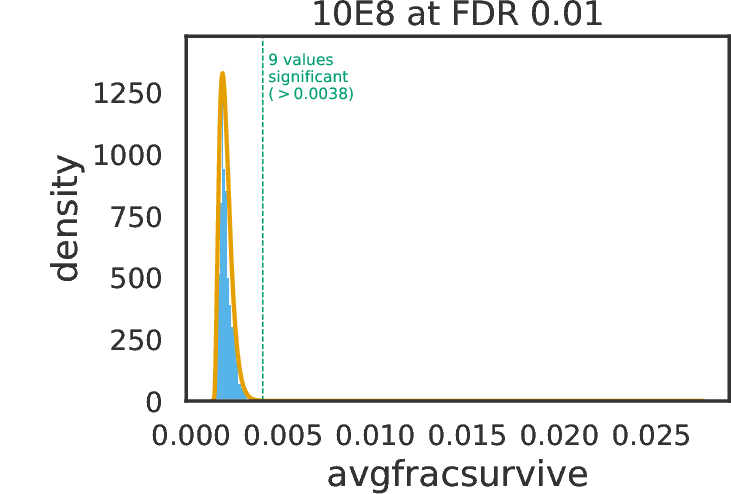

In [35]:
sigsites = {}
fdrs = [0.01]
sigSitesDisplaySave('avgfracsurvive', fdrs, antibodies, notaboveavgdatafiles, sigsites)

Now, lets look at the significant sites of escape in a single table.

In [36]:
from natsort import natsorted
arranged_antibodies = ['VRC01', '3BNC117', '101074', 'PGT121', 'PGT151', 'VRC34', 'PG9', 'PGT145', '10E8']
sigsitestabledict = {}
for ab in sigsites.keys():
    sitelist = sigsites[ab]
    sortedsitelist = natsorted(sitelist)
    sitestring = ', '.join(sortedsitelist)
    sigsitestabledict[ab] = sitestring


sigsitestable = pd.DataFrame.from_dict(sigsitestabledict, orient='index')
#print(sigsitestable)
#display(HTML(sigsitestable.to_html(index=True)))
with pd.option_context('display.max_colwidth', -1): 
    display(HTML(sigsitestable.to_html(index=True)))


*************************
Analyzing antibody 3BN_1074_pool
  site  avgfracsurvive             Q
0  334        0.004397  4.356635e-28
1  332        0.003151  5.470920e-15
2  325        0.002893  1.451838e-12
['334', '332', '325']


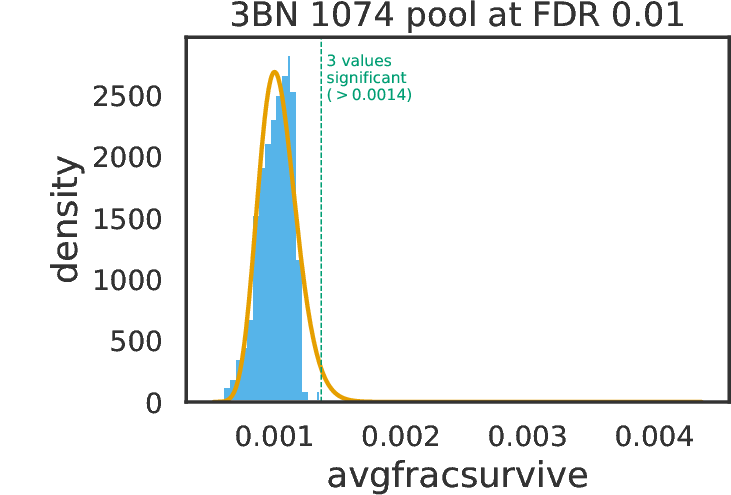

In [37]:
antibodiespool = ['3BN_1074_pool']
notaboveavgdatafilespool = ['./results/fracsurvive/concavg_wtDNA_ctrl/summary_3BN-1074-pool-mediansitefracsurvive.csv']
sigsitespool = {}
fdrs = [0.01]
sigSitesDisplaySave('avgfracsurvive', fdrs, antibodiespool, notaboveavgdatafilespool, sigsitespool)

In [38]:
for antibody in antibodies:
    print(antibody)
    print(sigsites[antibody])

PGT121
['332', '334', '327', '415', '330', '325', '408', '406', '428', '323', '443', '419', '326', '471', '380']
VRC01
['279', '326', '369', '197', '209']
101074
['334', '325', '332', '327', '415', '330', '204', '441', '323']
3BNC117
['207', '304', '197', '318', '471', '279', '119', '308', '209', '206', '182', '120', '204', '369', '274']
VRC34
['88', '85', '90', '524', '512', '513', '515', '516', '229', '514', '243', '518', '629']
PG9
['160', '171', '169', '162']
PGT151
['613', '611', '512', '637', '639', '514', '647', '322a', '318', '327', '224', '629', '142']
PGT145
['166', '160', '121', '169', '162', '127', '124', '315', '123', '202', '197', '312', '203']
10E8
['671', '673', '672', '683', '680', '676', '643', '682', '609']


Here, we need to assign all sig sites of escape associated with a single PNG _that contacts the antibody_ to a single site. I will assign that site as the N of the PNG. If a site in the PNG (such as the third position) is a site of escape but it also contacts the antibody directly, then I leave it as its own site of escape. 

I did this by hand. 

For PGT121:
**significant sites 332 and 334 become just one significant site 332.**

For VRC01:
N197 does not contact Ab (see escape via glycan shift to 195), but does cotnatc site 198 does. I did not alter these sig sites at all. 
glycosylation sites that contact at 7 angstroms: 276, 362, 187, 463


For 101074:
**significant sites 332 and 334 become just one significant site 332.**

For 3BNC117:
N197 glycan does contact Fab (see escape via glycan shift to 195). At site 198, we see escape (but not via P, which would disrupt the N197 PNG). 
glycosylation sites that contact at 7 angstroms: 197, 262, 276, 392, 363
I did not alter these sig sites at all. 


For VRC34:
**significant sites 88 and 90 become one site, 88.**

For PGT151:
**significant sites 611 and 613 become one site, 611.
significant sites 637 and 639 become one site, 637.**

For PGT145:
Ab contacts N160, as well as sites 161 and 162. Escape occurs at site 162, but since this disrupts a contact site and the N160 PNG, I left it as a site of escape.  I did not alter these sig sites at all. 

For PG9:
Ab contacts N160, as well as site 162. Escape occurs at site 162, but since this disrupts a contact site and the N160 PNG, I left it as a site of escape.  I did not alter these sig sites at all. 

for 10E8:
did not alter, glycans not in MPER peptide structure. 


In [39]:
sigsites_collapsePNGs = {}
sigsites_collapsePNGs["PGT121"] = ['332', '327', '415', '330', '325', '408', '406', '428', '323', '443', '419', '326', '471', '380']
sigsites_collapsePNGs["VRC01"] = ['279', '326', '369', '197', '209']
sigsites_collapsePNGs["101074"] = ['325', '332', '327', '415', '330', '204', '441', '323']
sigsites_collapsePNGs["3BNC117"] = ['207', '304', '197', '318', '471', '279', '119', '308', '209', '206', '182', '120', '204', '369', '274']
sigsites_collapsePNGs["VRC34"] = ['88', '85', '524', '512', '513', '515', '516', '229', '514', '243', '518', '629']
sigsites_collapsePNGs["PG9"] = ['160', '171', '169', '162']
sigsites_collapsePNGs["PGT151"] = ['611', '512', '637', '514', '647', '322a', '318', '327', '224', '629', '142']
sigsites_collapsePNGs["PGT145"] = ['166', '160', '121', '169', '162', '127', '124', '315', '123', '202', '197', '312', '203']
sigsites_collapsePNGs["10E8"] = ['671', '673', '672', '683', '680', '676', '643', '682', '609']

In [40]:
#now, lets quickly check how our hand editing worked!
for antibody in antibodies:
    print(antibody)
    print(sigsites[antibody])
    print(sigsites_collapsePNGs[antibody])


PGT121
['332', '334', '327', '415', '330', '325', '408', '406', '428', '323', '443', '419', '326', '471', '380']
['332', '327', '415', '330', '325', '408', '406', '428', '323', '443', '419', '326', '471', '380']
VRC01
['279', '326', '369', '197', '209']
['279', '326', '369', '197', '209']
101074
['334', '325', '332', '327', '415', '330', '204', '441', '323']
['325', '332', '327', '415', '330', '204', '441', '323']
3BNC117
['207', '304', '197', '318', '471', '279', '119', '308', '209', '206', '182', '120', '204', '369', '274']
['207', '304', '197', '318', '471', '279', '119', '308', '209', '206', '182', '120', '204', '369', '274']
VRC34
['88', '85', '90', '524', '512', '513', '515', '516', '229', '514', '243', '518', '629']
['88', '85', '524', '512', '513', '515', '516', '229', '514', '243', '518', '629']
PG9
['160', '171', '169', '162']
['160', '171', '169', '162']
PGT151
['613', '611', '512', '637', '639', '514', '647', '322a', '318', '327', '224', '629', '142']
['611', '512', '637', 

Now, we by import the structural contact sites by hand. Elsewhere, for each residue, we calculated the mimimum distance between any atom in each residue and any antibody atom, excluding hydrogen atoms. We use a distance cutoff or 4 angstroms to determine a contact site. Below, we are importing these sites by hand.

In [41]:
epitope_site_dict_ug = {}
epitope_site_dict_ug["VRC01"] = ["105","198","199","276","278","279","280","281","362","365","366","367","368","371","427","428","455","456","457","458","459","461","467","469","473"]
#Here, we will use 58vm, which has only 3BNC117
epitope_site_dict_ug["3BNC117"] = ["197", "207", "276", "278", "279", "280", "281", "282", "306", "308", "316", "365", "366", "367", "368", "371", "392", "428", "430", "456", "457", "458", "459", "460", "461", "462", "463", "464", "465", "469"]
#For PGT121, I will use the PGT122 structure
epitope_site_dict_ug["PGT121"] = ["135","136","137","156","322","322a","324","325","326","327","328","330","332","417"]
#for this structure, 321a and 322 were within 4 angstroms. I changed these to 322 and 322a, to agree with out MAP data
#there is no 150 site in out BG505 alignment with HXB2. This was a contact to PGT121. Thus, I eliminated it here. 
epitope_site_dict_ug["101074"] = ["135","136","137","156","301","322","322a","324","325","326","327","328","330","332","417"]
#for this structure, 321a and 322 were within 4 angstroms. I changed these to 322 and 322a, to agree with out MAP data numbering. 

epitope_site_dict_ug["10E8"] = ["665","668","669","670","671","672","673","676","677","679","680","683"]
epitope_site_dict_ug["PG9"] = ["156","158","160","162","164","165","166","167","168","169","170","171","172","173"] #TOOK OUT CONTACTS WITH scaffold
epitope_site_dict_ug["PGT151"] = ["82","83","84","245","246","262","448","512","513","514","515","516","517","519","521","522","542","543","549","550","554","58","592","611","637","638","640","641","643","644","647"] 
epitope_site_dict_ug["VRC34"] = ["80","84","85","87","88","229","230","231","241","512","513","514","515","516","517","518","519","520"]
epitope_site_dict_ug["PGT145"] = ["121","124","127","160","161","162","166","167","168","169"]

In [42]:
%matplotlib inline

In [43]:
#here, we use the sigsites dictionary to overlay significant sites that were not collapsed at PNG sites. 
sitesoutdir = './results/fracsurvive/concavg_wtDNA_ctrl/SigSiteOverlays_4angstrom/'
if not os.path.isdir(sitesoutdir):
    os.mkdir(sitesoutdir)

for antibody, site_file in zip(antibodies, diffselfiles):
    site_df = pd.read_csv(site_file)
    significant_sites = sigsites[antibody]
    epitope_sites = epitope_site_dict_ug[antibody]
    sigsites_inepitope = [item for item in significant_sites if item in epitope_sites]
    site_df['epitope_site'] = site_df['site'].isin(epitope_sites)
    site_df['significant_site'] = site_df['site'].isin(significant_sites)
    site_df['sigandepitope_site'] = site_df['site'].isin(sigsites_inepitope)
    site_df = site_df.drop(['avgfracsurvive', 'maxfracsurvive'], axis=1)
    site_df['cs'] = np.where((site_df['significant_site']==True) & (site_df['epitope_site']==True) & (site_df['sigandepitope_site']==True), 'ContactAndSignificant', "NaN")
    site_df['cs'] = np.where((site_df['epitope_site']==True) & (site_df['significant_site']==False) & (site_df['sigandepitope_site']==False), 'Contact', site_df['cs'] )
    site_df['cs'] = np.where((site_df['significant_site']==True) & (site_df['epitope_site']==False) & (site_df['sigandepitope_site']==False), 'Significant', site_df['cs'] )
    site_df = site_df.dropna(subset=["cs"]) 
    site_df = site_df[site_df.cs != "NaN"]
    site_df = site_df.drop(['epitope_site', 'significant_site', 'sigandepitope_site'], axis=1)

    ab_name = antibody.replace("_", "-").replace(".", "-")
    outfile = '{0}{1}_SignificantSitesOverlay.csv'.format(sitesoutdir, ab_name)
    outfile
    site_df.to_csv(outfile,index=False, encoding='utf-8')
    print("Writing significant and epitope site overlays for {0} to {1}".format(antibody, outfile))

    #now, make a logoplot of fracsurvive, breadth, and natseq frew at the above sites. 
    
    labelfile2 = "{0}{1}_SignificantSitesOnlyOverlay.csv".format(sitesoutdir, antibody)
    #make sig_site_df that is all sig
    sig_site_df = pd.read_csv(site_file)
    sig_site_df['sig'] = sig_site_df['site'].isin(significant_sites)
    sig_site_df = sig_site_df.drop(['avgfracsurvive', 'maxfracsurvive'], axis=1)
    #drop false sites
    sig_site_df = sig_site_df[sig_site_df.sig != False]
    
    #replace true with 1
    sig_site_df["sig"].replace(True, 1, inplace=True)
    #rename the columns
    sig_site_df.to_csv(labelfile2,index=False, encoding='utf-8')

    sigsites_inepitope_list = ','.join(map(str, sigsites_inepitope)) 
    significant_sites_list = ','.join(map(str, significant_sites))
    contact_sites_list = ','.join(map(str, epitope_sites))

    sigsitesfile = open("{0}{1}_SignificantSitesList.txt".format(sitesoutdir, antibody), "w")
    sigsitesfile.write("{0}".format(significant_sites_list))
    sigsitesfile.close()
    
    contactsitesfile = open("{0}{1}_ContactSitesList.txt".format(sitesoutdir, antibody), "w")
    contactsitesfile.write("{0}".format(contact_sites_list))
    contactsitesfile.close()
    
    contactandsignificantsitesfile = open("{0}{1}_ContactAndSignificantSitesList.txt".format(sitesoutdir, antibody), "w")
    contactandsignificantsitesfile.write("{0}".format(sigsites_inepitope_list))
    contactandsignificantsitesfile.close()


Writing significant and epitope site overlays for PGT121 to ./results/fracsurvive/concavg_wtDNA_ctrl/SigSiteOverlays_4angstrom/PGT121_SignificantSitesOverlay.csv
Writing significant and epitope site overlays for VRC01 to ./results/fracsurvive/concavg_wtDNA_ctrl/SigSiteOverlays_4angstrom/VRC01_SignificantSitesOverlay.csv
Writing significant and epitope site overlays for 101074 to ./results/fracsurvive/concavg_wtDNA_ctrl/SigSiteOverlays_4angstrom/101074_SignificantSitesOverlay.csv
Writing significant and epitope site overlays for 3BNC117 to ./results/fracsurvive/concavg_wtDNA_ctrl/SigSiteOverlays_4angstrom/3BNC117_SignificantSitesOverlay.csv
Writing significant and epitope site overlays for VRC34 to ./results/fracsurvive/concavg_wtDNA_ctrl/SigSiteOverlays_4angstrom/VRC34_SignificantSitesOverlay.csv
Writing significant and epitope site overlays for PG9 to ./results/fracsurvive/concavg_wtDNA_ctrl/SigSiteOverlays_4angstrom/PG9_SignificantSitesOverlay.csv
Writing significant and epitope site

In [44]:
antibody_subset = ['VRC01', '101074', '3BNC117', 'VRC34', 'PG9', 'PGT151', "PGT145", '10E8', "PGT121"]
import matplotlib.colors

In [45]:
annotate_outdir = './results/fracsurviveaboveavg/concavg_wtDNA_ctrl/SigSiteOverlays_4angstrom/'
if not os.path.isdir(annotate_outdir):
    os.mkdir(annotate_outdir)

In [46]:
#now plot files with those overlays. 

annotate_outdir = './results/fracsurviveaboveavg/concavg_wtDNA_ctrl/SigSiteOverlays_4angstrom/'
if not os.path.isdir(annotate_outdir):
    os.mkdir(annotate_outdir)

            
for antibody in antibody_subset:
    mutdiffsel = os.path.join(concavg_fracsurviveaboveavgdir_wtDNActrl, 'summary_{0}-medianmutfracsurvive.csv'.format(antibody))
    logoplot = os.path.join(concavg_fracsurviveaboveavgdir_wtDNActrl, 'SigSiteOverlays_4angstrom/{0}-median-annotated_fracsurvive.pdf'.format(antibody))
        #scale bar unit is maximum effect
    mutdiffseldf = pd.read_csv(mutdiffsel)
    scaleunit = '{0:.1g}'.format(mutdiffseldf['mutfracsurvive'].max())
    scalelabel = '"fraction surviving above avg = {0}"'.format(scaleunit)
    logoname = '{0}-median-annotated'.format(antibody)
    labelfile = "./results/fracsurvive/concavg_wtDNA_ctrl/SigSiteOverlays_4angstrom/{0}_SignificantSitesOverlay.csv".format(antibody)
    labelfile2 = "./results/fracsurvive/concavg_wtDNA_ctrl/SigSiteOverlays_4angstrom/{0}_SignificantSitesOnlyOverlay.csv".format(antibody)
    labelfile3 = "./results/fracsurvive/concavg_wtDNA_ctrl/SigSiteOverlays_4angstrom/{0}_ContactSitesOnlyOverlay.csv".format(antibody)
    
    print("Creating logo plot for {0} from {1}".format(antibody, mutdiffsel))
    log = !dms2_logoplot \
            --fracsurvive {mutdiffsel} \
            --name {logoname} \
            --outdir {annotate_outdir} \
            --sepline no \
            --nperline 84 \
            --overlay1 {mutdiffsel} wildtype wildtype \
            --overlay2 {labelfile} cs ContactAndOrSignificant \
            --scalebar {scaleunit} {scalelabel} \
            --underlay yes \
            --overlaycolormap viridis \
            --use_existing {use_existing}
    #showPDF(logoplot)
    

Creating logo plot for VRC01 from ./results/fracsurviveaboveavg/concavg_wtDNA_ctrl/summary_VRC01-medianmutfracsurvive.csv
Creating logo plot for 101074 from ./results/fracsurviveaboveavg/concavg_wtDNA_ctrl/summary_101074-medianmutfracsurvive.csv
Creating logo plot for 3BNC117 from ./results/fracsurviveaboveavg/concavg_wtDNA_ctrl/summary_3BNC117-medianmutfracsurvive.csv
Creating logo plot for VRC34 from ./results/fracsurviveaboveavg/concavg_wtDNA_ctrl/summary_VRC34-medianmutfracsurvive.csv
Creating logo plot for PG9 from ./results/fracsurviveaboveavg/concavg_wtDNA_ctrl/summary_PG9-medianmutfracsurvive.csv
Creating logo plot for PGT151 from ./results/fracsurviveaboveavg/concavg_wtDNA_ctrl/summary_PGT151-medianmutfracsurvive.csv
Creating logo plot for PGT145 from ./results/fracsurviveaboveavg/concavg_wtDNA_ctrl/summary_PGT145-medianmutfracsurvive.csv
Creating logo plot for 10E8 from ./results/fracsurviveaboveavg/concavg_wtDNA_ctrl/summary_10E8-medianmutfracsurvive.csv
Creating logo plot f

Here, we use the sigsites_collapsePNGs dictionary, as we are lookin gatthe overlap between significant contact sites and want to say that all singificant sites in PNG (unless also contacting that site directly) count to just one site, the N. 


In [47]:
sig_and_epitope_sites = {}
sig_only_sites = {}
contact_only_sites = {}
sig_and_epitope_sites_overlap = {}

for antibody in antibodies:
    print("\nFor {0}".format(antibody))
    significant_sites = sigsites_collapsePNGs[antibody]
    epitope_sites = epitope_site_dict_ug[antibody]
    sig_and_epitope_sites[antibody] = sorted(list(set(significant_sites + epitope_sites)))
    sig_only_sites[antibody] = sorted(list(set(significant_sites) - set(epitope_sites)))
    contact_only_sites[antibody] = sorted(list(set(epitope_sites) - set(significant_sites)))
    
    len_significant_sites = len(significant_sites)
    sigsites_inepitope = [item for item in significant_sites if item in epitope_sites]
    sig_and_epitope_sites_overlap[antibody] = sigsites_inepitope
    sigsites_not_inepitope = [item for item in significant_sites if item not in epitope_sites]
    print("Of {0} significant sites, {1} are in contact sites and {2} are not within 4 angstroms"
        .format(len(significant_sites), len(sigsites_inepitope), len(sigsites_not_inepitope)))
    print("The significant sites are: \n{0}".format(significant_sites))
    print("The significant sites in the epitope are: \n{0}".format(sigsites_inepitope))
    print("The significant sites NOT in the epitope are: \n{0}".format(sigsites_not_inepitope))



For PGT121
Of 14 significant sites, 5 are in contact sites and 9 are not within 4 angstroms
The significant sites are: 
['332', '327', '415', '330', '325', '408', '406', '428', '323', '443', '419', '326', '471', '380']
The significant sites in the epitope are: 
['332', '327', '330', '325', '326']
The significant sites NOT in the epitope are: 
['415', '408', '406', '428', '323', '443', '419', '471', '380']

For VRC01
Of 5 significant sites, 1 are in contact sites and 4 are not within 4 angstroms
The significant sites are: 
['279', '326', '369', '197', '209']
The significant sites in the epitope are: 
['279']
The significant sites NOT in the epitope are: 
['326', '369', '197', '209']

For 101074
Of 8 significant sites, 4 are in contact sites and 4 are not within 4 angstroms
The significant sites are: 
['325', '332', '327', '415', '330', '204', '441', '323']
The significant sites in the epitope are: 
['325', '332', '327', '330']
The significant sites NOT in the epitope are: 
['415', '204

In [48]:
fracsurviveaboveavg_dict = {}
concavg_wtDNActrldict = "./results/fracsurviveaboveavg/concavg_wtDNA_ctrl"
fracsurviveaboveavg_dict["VRC01"] = "{0}/summary_VRC01-medianmutfracsurvive.csv".format(concavg_wtDNActrldict) 
fracsurviveaboveavg_dict["3BNC117"] = "{0}/summary_3BNC117-medianmutfracsurvive.csv".format(concavg_wtDNActrldict) 
fracsurviveaboveavg_dict["PGT121"] = "{0}/summary_PGT121-medianmutfracsurvive.csv".format(concavg_wtDNActrldict) 
fracsurviveaboveavg_dict["10E8"] = "{0}/summary_10E8-medianmutfracsurvive.csv".format(concavg_wtDNActrldict) 
fracsurviveaboveavg_dict["PG9"] = "{0}/summary_PG9-medianmutfracsurvive.csv".format(concavg_wtDNActrldict) 
fracsurviveaboveavg_dict["PGT151"] = "{0}/summary_PGT151-medianmutfracsurvive.csv".format(concavg_wtDNActrldict) 
fracsurviveaboveavg_dict["VRC34"] = "{0}/summary_VRC34-medianmutfracsurvive.csv".format(concavg_wtDNActrldict) 
fracsurviveaboveavg_dict["101074"] = "{0}/summary_101074-medianmutfracsurvive.csv".format(concavg_wtDNActrldict)
fracsurviveaboveavg_dict["PGT145"] = "{0}/summary_PGT145-medianmutfracsurvive.csv".format(concavg_wtDNActrldict)


In [49]:
#print(antibodies)
from matplotlib import rc

antibodies_arranged = ['VRC01', '3BNC117', 'PGT121', '101074', 'PG9', 'PGT145', 'PGT151', 'VRC34', '10E8']

antibodies_arranged_names = ['VRC01', '3BNC117', 'PGT121', '10-1074', 'PG9', 'PGT145', 'PGT151', 'VRC34.01', '10E8']
NSigsitesList = []
NSigsitesInEpitopeList = []
NEpitopesitesList = []
NEpitopeONLYsitesList = []
for ab in antibodies_arranged:
    nsigsites = len(set(sigsites_collapsePNGs[ab]))
    nsigsitesinepitope = len(set(sig_and_epitope_sites_overlap[ab]))
    NSigsitesList.append(nsigsites)
    NSigsitesInEpitopeList.append(nsigsitesinepitope)
    
    nepitopesites = len(set(epitope_site_dict_ug[ab]))
    NEpitopesitesList.append(nepitopesites)
    
    nepitopeonlysite = len(set(contact_only_sites[ab]))
    NEpitopeONLYsitesList.append(nepitopeonlysite)



In [50]:
dist_outdir = './results/fracsurviveaboveavg/concavg_wtDNA_ctrl/Escape_vs_distance/'
if not os.path.isdir(dist_outdir):
    os.mkdir(dist_outdir)

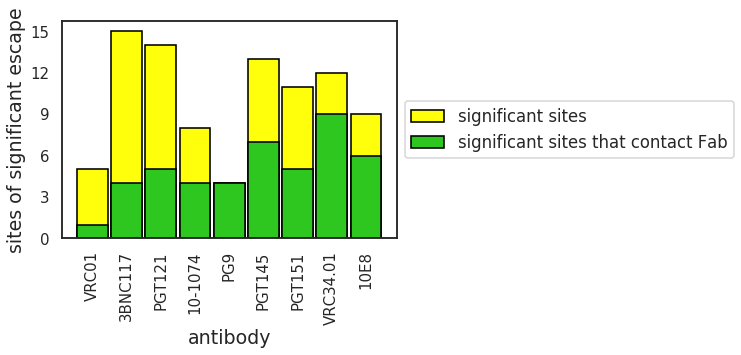

In [51]:
#now we will plot the above data in two ways. 
#first, we will plot the number of significant sites of escape per antibody as a bar plot, colored according to i each site is in or outside of the epitope.
#use same color scheme as above. 
rc('font', weight='normal')
r = [0,1,2,3,4,5,6,7,8]
barWidth = .90
 
# Create brown bars
plt.bar(r, NSigsitesList, color="#ffff0c", edgecolor="black", linewidth=1.6, width=barWidth, label="significant sites") #fde725ff

plt.bar(r, NSigsitesInEpitopeList, color="#2dc71f", edgecolor="black", linewidth=1.6, width=barWidth, label="significant sites that contact Fab") #218f8dff

#plt.bar(r, bars3, bottom=bars, color='#2d7f5e', edgecolor='white', width=barWidth)
 
plt.rcParams["font.family"] = "san-serif"
# Custom X axis
plt.xticks(r, antibodies_arranged_names, rotation='vertical')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("antibody")
x=[0,3,6,9,12,15]
plt.yticks(np.arange(min(x), max(x)+3, 3))
plt.ylabel("sites of significant escape")
plt.savefig("./results/fracsurviveaboveavg/concavg_wtDNA_ctrl/Escape_vs_distance/EscapeSites.png") 
# Show graphic
plt.show()



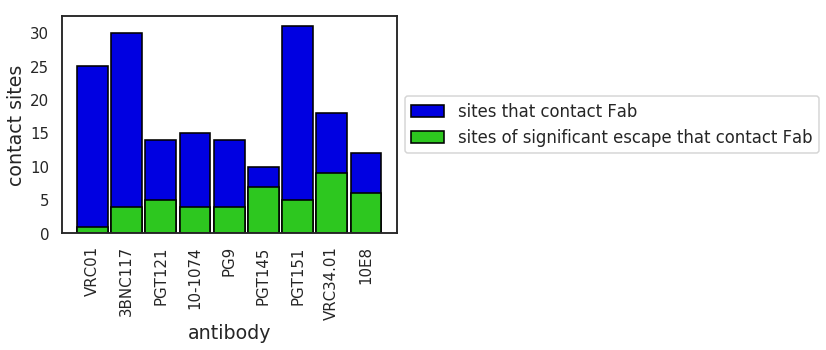

In [52]:
#now we will plot the above data in two ways. 
#first, we will plot the number of significant sites of escape per antibody as a bar plot, colored according to if each site is in or outside of the epitope.
#use same color scheme as above. 

rc('font', weight='normal')


r = [0,1,2,3,4,5,6,7,8]
 
barWidth = .90

plt.bar(r, NEpitopesitesList, color="#0000e1", edgecolor="black", linewidth=1.6, width=barWidth, label="sites that contact Fab") #440154ff

plt.bar(r, NSigsitesInEpitopeList, color="#2dc71f", edgecolor="black", linewidth=1.6, width=barWidth, label="sites of significant escape that contact Fab") #218f8dff
 
# Custom X axis
plt.xticks(r, antibodies_arranged_names, rotation='vertical')
plt.xlabel("antibody")
plt.ylabel("contact sites")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# Show graphic
plt.savefig("./results/fracsurviveaboveavg/concavg_wtDNA_ctrl/Escape_vs_distance/ContactSitesEscape.png") 
plt.show()


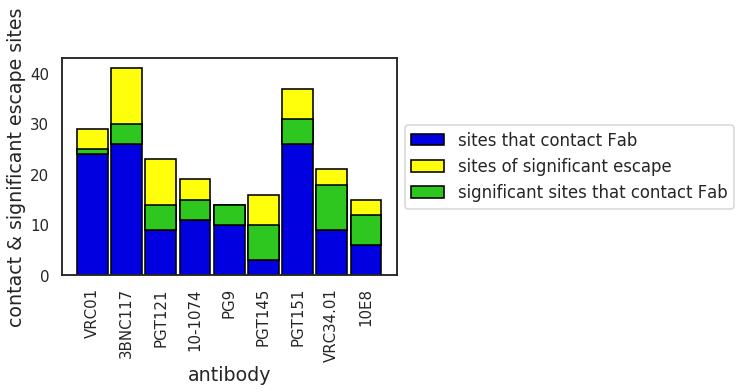

In [53]:
# y-axis in bold
rc('font', weight='normal')


r = [0,1,2,3,4,5,6,7,8]
 
barWidth = .90
 
# plot sites that contact fab but are not in epitope
plt.bar(r, NEpitopeONLYsitesList, color="#0000e1", edgecolor="black", linewidth=1.6, width=barWidth, label="sites that contact Fab")
# Create green bars (middle), on top of the firs ones

# plot significant sites on top of epitope sites
plt.bar(r, NSigsitesList, bottom=NEpitopeONLYsitesList, color="#ffff0c", edgecolor="black", linewidth=1.6, width=barWidth, label="sites of significant escape")

#plot sigandepitope overlap sites overlaid (covering part of) significant sites. 
plt.bar(r, NSigsitesInEpitopeList, bottom=NEpitopeONLYsitesList, color="#2dc71f", edgecolor="black", linewidth=1.6, width=barWidth, label="significant sites that contact Fab")


# Custom X axis
plt.xticks(r, antibodies_arranged_names, rotation='vertical')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("antibody")
plt.ylabel("contact & significant escape sites")
print()
plt.show()



In [54]:
sitefracsurviveaboveavg_dict = {}
sitefracsurviveaboveavg_dict["VRC01"] = "{0}/summary_VRC01-mediansitefracsurvive.csv".format(concavg_fracsurviveaboveavgdir_wtDNActrl) 
sitefracsurviveaboveavg_dict["3BNC117"] = "{0}/summary_3BNC117-mediansitefracsurvive.csv".format(concavg_fracsurviveaboveavgdir_wtDNActrl) 
sitefracsurviveaboveavg_dict["PGT121"] = "{0}/summary_PGT121-mediansitefracsurvive.csv".format(concavg_fracsurviveaboveavgdir_wtDNActrl) 
sitefracsurviveaboveavg_dict["10E8"] = "{0}/summary_10E8-mediansitefracsurvive.csv".format(concavg_fracsurviveaboveavgdir_wtDNActrl) 
sitefracsurviveaboveavg_dict["PG9"] = "{0}/summary_PG9-mediansitefracsurvive.csv".format(concavg_fracsurviveaboveavgdir_wtDNActrl) 
sitefracsurviveaboveavg_dict["PGT151"] = "{0}/summary_PGT151-mediansitefracsurvive.csv".format(concavg_fracsurviveaboveavgdir_wtDNActrl) 
sitefracsurviveaboveavg_dict["VRC34"] = "{0}/summary_VRC34-mediansitefracsurvive.csv".format(concavg_fracsurviveaboveavgdir_wtDNActrl) 
sitefracsurviveaboveavg_dict["101074"] = "{0}/summary_101074-mediansitefracsurvive.csv".format(concavg_fracsurviveaboveavgdir_wtDNActrl)
sitefracsurviveaboveavg_dict["PGT145"] = "{0}/summary_PGT145-mediansitefracsurvive.csv".format(concavg_fracsurviveaboveavgdir_wtDNActrl)

distance_dict = {}
distance_dict["VRC01"] = "./data/MinimumDistances/VRC01_MinDistToAb.csv"
distance_dict["3BNC117"] = "./data/MinimumDistances/3BNC117_5v8m_MinDistToAb.csv"
distance_dict["PGT121"] = "./data/MinimumDistances/PGT122_MinDistToAb.csv"
distance_dict["10E8"] = "./data/MinimumDistances/10E8_MinDistToAb.csv"
distance_dict["PG9"] = "./data/MinimumDistances/PG9_MinDistToAb.csv"
distance_dict["PGT151"] = "./data/MinimumDistances/PGT151_MinDistToAb.csv"
distance_dict["VRC34"] = "./data/MinimumDistances/N123-VRC34_MinDistToAb.csv"
distance_dict["101074"] = "./data/MinimumDistances/101074_MinDistToAb.csv"
distance_dict["PGT145"] = "./data/MinimumDistances/PGT145_MinDistToAb.csv"

In [55]:
import seaborn as sns
from scipy import stats
%matplotlib inline

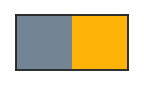

In [56]:
abnames = ['PGT121', 'VRC01', '101074', '3BNC117', 'VRC34', 'PG9', 'PGT151', 'PGT145', '10E8']
abnames2 = ['PGT121', 'VRC01', '10-1074', '3BNC117', 'VRC34.01', 'PG9', 'PGT151', 'PGT145', '10E8']
abnamestest = ['10E8']
BY_colors = ["steel", "amber"]
sns.palplot(sns.xkcd_palette(BY_colors))
palette = sns.xkcd_palette(BY_colors)

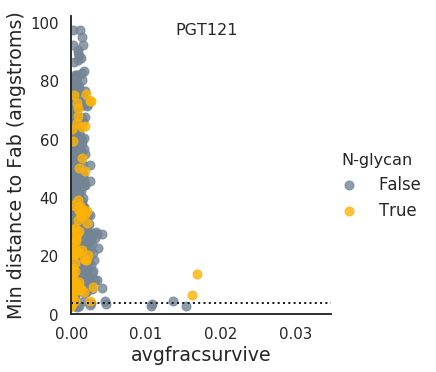

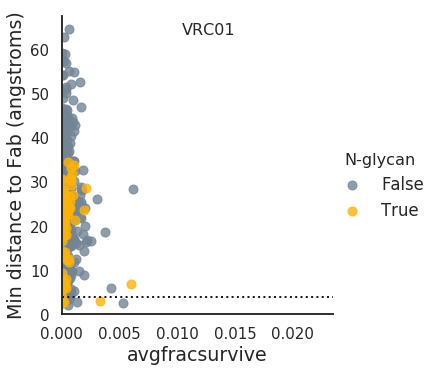

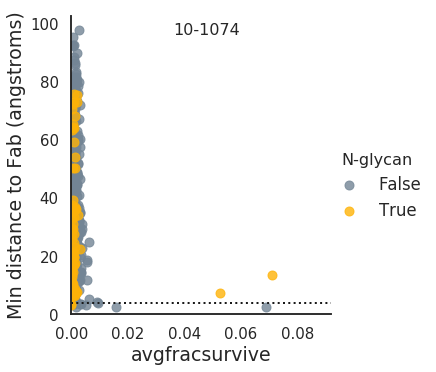

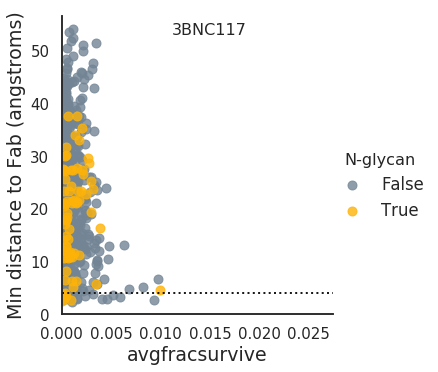

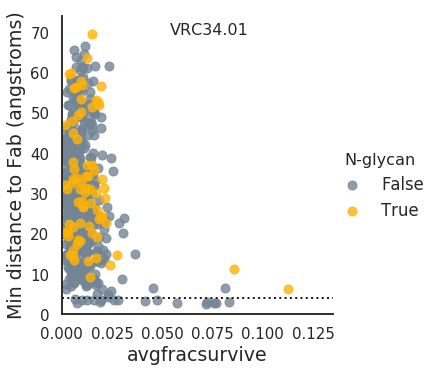

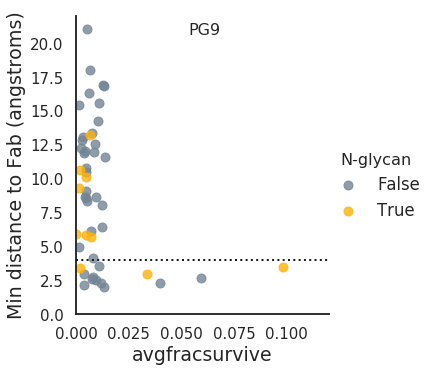

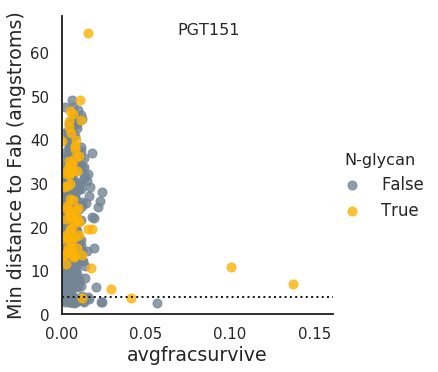

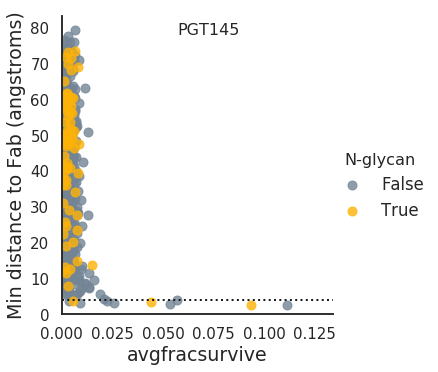

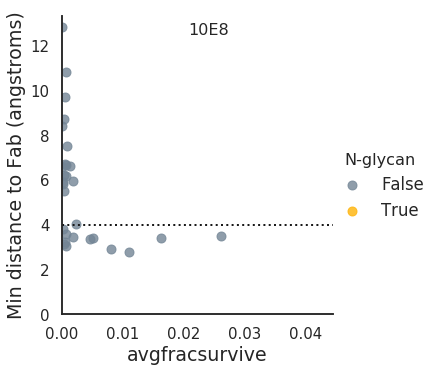

In [57]:
#Now, lets plot the minimum distance of of each residue to any antibody residue vs the site fraction surviving or ma


for antibody, name2 in zip(abnames, abnames2):
    outfilename = "{0}{1}_distance_vs_fracsurviveaboveavg".format(dist_outdir, antibody)
    sitefracsurvive_df = pd.read_csv(sitefracsurviveaboveavg_dict[antibody])#, encoding='utf-8')
    #annotate epitope sites in this df
    epitopesites = epitope_site_dict_ug[antibody]
    sitefracsurvive_df['site'] = sitefracsurvive_df['site'].astype(str)
    sitefracsurvive_df['epitopesite'] = sitefracsurvive_df['site'].isin(epitopesites)
    sitefracsurvive_df['contactsite']= np.where(sitefracsurvive_df['epitopesite']==True , "contact", "non-contact")
    
    #merge in distance df
    dist_df = pd.read_csv(distance_dict[antibody])#, encoding='utf-8')
    #for 5fyk, I know the BG505 insertion is at 321a not 322a. this, we correct this
    dist_df['site'].replace('322', '322a', regex=True, inplace=True)
    dist_df['site'].replace('321a', '322', regex=True, inplace=True)
    dist_df['site'] = dist_df['site'].astype(str)
    merge_df = sitefracsurvive_df.merge(dist_df, left_on='site', right_on='site', how='left')

    #merge in HXB2 to BG505, so we can color by glycan or not. 
    BG505toHXB2_df = pd.read_csv('./results/HXB2_numbering/BG505_to_HXB2.csv')
    merge2_df = merge_df.merge(BG505toHXB2_df, left_on='site', right_on='new', how='left')
    plot = sns.lmplot(data=merge2_df, x='avgfracsurvive', y='MinDist', hue="N-glycan", palette=palette, ci=None, legend=True, fit_reg=False)  
    
    plot.set(ylim=(0, None), xlim=(0, None))
    plt.plot([0,1], [4,4], 'k-', linewidth=2, linestyle=":")

    plt.subplots_adjust(top=1)
    #plt.xlabel("antibody")
    plt.ylabel("Min distance to Fab (angstroms)")
    plot.fig.suptitle("{0}".format(name2), size=16) # can also get the figure from plt.gcf()
    
    plot
    #save this shit!
    plot.savefig(outfilename)   

## Generate figure ready plots 
Now, I will replot the data in a number of ways for paper figures. 

In [58]:
summplotdir = "./results/fracsurviveaboveavg/concavg_SummaryPlots/"
if not os.path.isdir(summplotdir):
    os.mkdir(summplotdir)

In [59]:
epitope_sites_of_interest = {}
CD4bs_sites = ['113', "195", "196",'197', '198', '199', '207', '208', '209', '275', '276', '277', '278', '279', '280', '281', '282', '283', '304', '308', '312', '316', '317', '318', '319', '320', '326', '362', '363', '364', '365', '366', '367', '368', '369', '370', '371', '372', '373', '427', '428', '429', '430', '455', '456', '457', '458', '459', '460', '461', '471']
epitope_sites_of_interest["VRC01"] = CD4bs_sites
epitope_sites_of_interest["3BNC117"] = CD4bs_sites

V3_sites = ['323', '324', '325', '326', '327', '328', '329', '330', '331', '332', '333', '334', '415', '416', '417', '441']
epitope_sites_of_interest["PGT121"] = V3_sites
epitope_sites_of_interest["101074"] = V3_sites

FP_sites = ['229', '230', '231', '241', '242', '243', '244', '245', '246', '512', '513', '514', '515', '516', '517', '518', '519', '520', '521', '522', '523', '524', '611', '612', '613', '637', '638', '639', '640', '641', '642', '643', '644', '647', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90']
epitope_sites_of_interest["PGT151"] = FP_sites
epitope_sites_of_interest["VRC34"] = FP_sites

V2_sites = ["119", "120","121", '122', '123', '124','127', '156', '157','158','159', '160', '161', '162', '163', '164', '165', '166', '167', '168', '169', '170', '171', '172', '173', '199', '200', '201', '202', '203', '204', '312','313', '314','315']
epitope_sites_of_interest["PG9"] = V2_sites
epitope_sites_of_interest["PGT145"] = V2_sites

MPER_sites = ['671', '672', '673', '674', '675', '676', '677', '678', '679', '680', '681', '682', '683']
epitope_sites_of_interest["10E8"] = MPER_sites

In [60]:
import re
import os
import math
import natsort
#import pandas
import numpy
import scipy.stats
import matplotlib
matplotlib.use('pdf')
import matplotlib.pyplot as plt
from matplotlib import rc
from plotnine import *
# set ggplot theme
theme_set(theme_bw(base_size=12)) 

import seaborn


from dms_tools2 import CODONS, AAS, AAS_WITHSTOP
import dms_tools2.utils
COLOR_BLIND_PALETTE = ["#000000", "#E69F00", "#56B4E9", "#009E73",
                       "#F0E442", "#0072B2", "#D55E00", "#CC79A7"]

def plotSiteDiffSel_YLimDiff(names, diffselfiles, plotfile, 
        diffseltype, y_lim=None, highlighted_sites =None, underlay_1 = None, point = None, maxcol=2, white_bg=False):
    """Plot site diffsel or fracsurvive along sequence.
    Despite the function name, this function can be used to
    plot either differential selection or fraction surviving.
    Args:
        `names` (list or series)
            Names of samples for which we plot statistics.
        `diffselfiles` (list or series)
            ``*sitediffsel.csv`` files from ``dms2_diffsel`` or
            ``*sitefracsurvive.csv`` files from ``dms2_fracsurvive``.
        `plotfile` (str)
            Name of created PDF plot file.
        `diffseltype` (str)
            Type of diffsel or fracsurvive to plot:
                - `positive`: positive sitediffsel
                - `total`: positive and negative sitediffsel
                - `max`: maximum mutdiffsel
                - `minmax`: minimum and maximum mutdiffsel
                - `avgfracsurvive`: total site fracsurvive
                - `maxfracsurvive`: max mutfracsurvive at site
        `maxcol` (int)
            Number of columns in faceted plot.
        `white_bg` (bool)
            Plots will have a white background with limited other formatting.
            
        DOCUMENT CHANGES
    """
    assert len(names) == len(diffselfiles) == len(set(names)) > 0
    assert os.path.splitext(plotfile)[1].lower() == '.pdf'

    diffsels = [pd.read_csv(f).assign(name=name) for (name, f) 
            in zip(names, diffselfiles)]
    assert all([set(diffsels[0]['site']) == set(df['site']) for df in 
            diffsels]), "diffselfiles not all for same sites"
    diffsel = pd.concat(diffsels, ignore_index=True)

    ylabel = 'differential selection'
    if diffseltype == 'positive':
        rename = {'positive_diffsel':'above'}
    elif diffseltype == 'total':
        rename = {'positive_diffsel':'above',
                  'negative_diffsel':'below'}
    elif diffseltype == 'max':
        rename = {'max_diffsel':'above'}
    elif diffseltype == 'minmax':
        rename = {'max_diffsel':'above',
                  'min_diffsel':'below'}
    elif diffseltype in ['avgfracsurvive', 'maxfracsurvive']:
        ylabel = 'fraction surviving'
        rename = {diffseltype:'above'}
    else:
        raise ValueError("invalid diffseltype {0}".format(diffseltype))
    diffsel = (diffsel.rename(columns=rename)
                      .melt(id_vars=['site', 'name'], 
                            value_vars=list(rename.values()),
                            value_name='diffsel',
                            var_name='direction')
                      )


    # natural sort by site: https://stackoverflow.com/a/29582718
    diffsel = diffsel.reindex(index=natsort.order_by_index(
            diffsel.index, natsort.index_natsorted(diffsel.site,
            signed=True)))
    # now some manipulations to make site str while siteindex is int
    diffsel['site'] = diffsel['site'].apply(str)
    diffsel['siteindex'] = pd.Categorical(diffsel['site'],
            diffsel['site'].unique()).codes
    
    ncol = min(maxcol, len(names))
    nrow = math.ceil(len(names) / float(ncol))
    y_lim_min = y_lim - (float(y_lim/30))

    # make name a category to preserve order
    diffsel['name'] = diffsel['name'].astype('category', 
            categories=names)
    
    (xbreaks, xlabels) = dms_tools2.plot.breaksAndLabels(diffsel['siteindex'].unique(), 
            diffsel['site'].unique(), n=6)
    
    diffsel['highlight'] = diffsel['site'].isin(highlighted_sites) 
    diffsel['highlight'] =np.where(diffsel['highlight']==True , -0.0092, -1)#-0.0092, -1)#-1)
    #diffsel['underlay_1'] = 0.16
    diffsel['underlay_1'] = diffsel['site'].isin(underlay_1)
    ymin = float(y_lim) *(float(.005/.15))*float(-1)
    diffsel['underlay_1'] =np.where(diffsel['underlay_1']==True , ymin, -1)
    diffsel['point'] = diffsel['site'].isin(point)
    diffsel['point'] =np.where(diffsel['point']==True , -0.0069, -1)
    
    

    if white_bg:
        p = (ggplot(diffsel, aes(x='siteindex', y='diffsel',
                    color='direction', fill='direction'))
             
             + geom_point(aes(y='underlay_1'), color=None, fill="#0000e1", shape="|", size=3, show_legend=False) #light blue - #0072b2 old color: "#440154ff"
             + geom_step(size=0.3)
             + scale_y_continuous(limits=(ymin, y_lim))#-0.0092, y_lim))
             + xlab('site')
             + ylab(ylabel)
             + scale_x_continuous(breaks=xbreaks, labels=xlabels)
             + scale_color_manual(COLOR_BLIND_PALETTE)
             + scale_fill_manual(COLOR_BLIND_PALETTE)
             + guides(color=False)
             + theme(#panel_background=element_rect(fill='white'),
                     axis_line_x=element_line(color='black'),
                     axis_line_y=element_line(color='black'),
                     axis_title_x=element_blank(),
                     axis_title_y=element_blank(),
                     panel_grid=element_blank(),
                     panel_border=element_blank(),
                     strip_background=element_blank()
                     )
            )
    else:
        p = (ggplot(diffsel, aes(x='siteindex', y='diffsel', color='direction'))
             + geom_step(size=0.4)
             + xlab('site')
             + scale_y_continuous(limits=(0, y_lim))
             + ylab(ylabel)
             + scale_x_continuous(breaks=xbreaks, labels=xlabels)
             + scale_color_manual(COLOR_BLIND_PALETTE)
             + guides(color=False)
             )
    if not ((len(names) == 1) and ((not names[0]) or names[0].isspace())):
        p += facet_wrap('~name', ncol=ncol)
    p += theme(figure_size=(4.6 * (0.3 + ncol), 1.9 * (0.2 + nrow)))
    p.save(plotfile, verbose=False, transparent=True)
plt.close()

In [61]:
antibodies = ['PGT121', '101074', 'VRC01', '3BNC117', 'PGT145', 'PG9', 'PGT151', 'VRC34', '10E8']


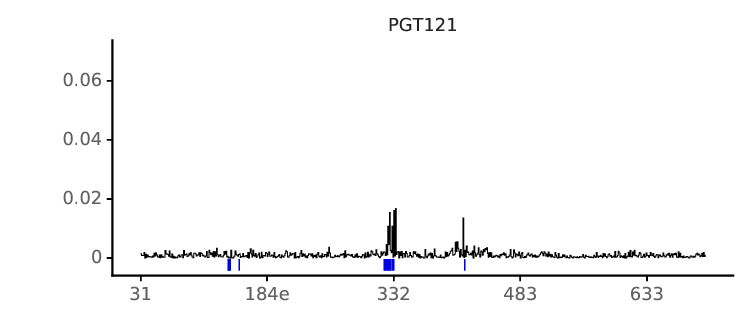

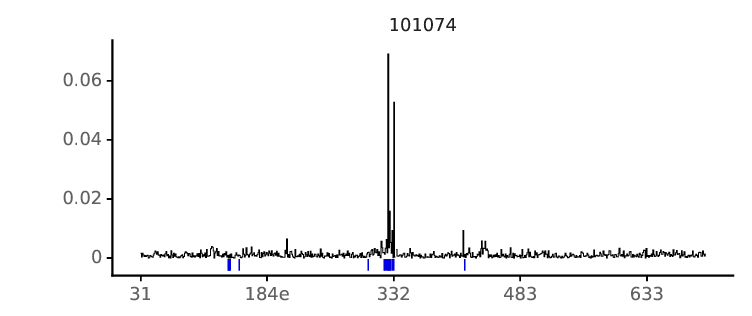

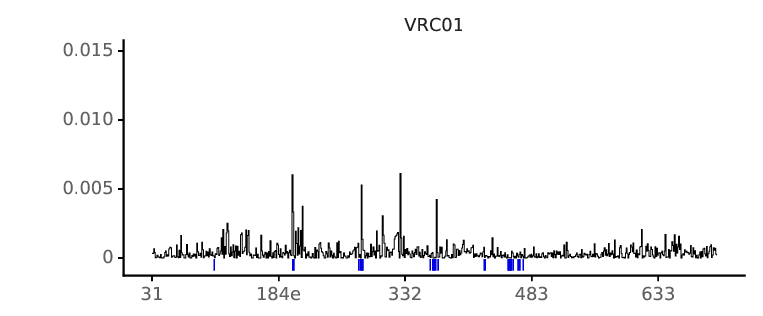

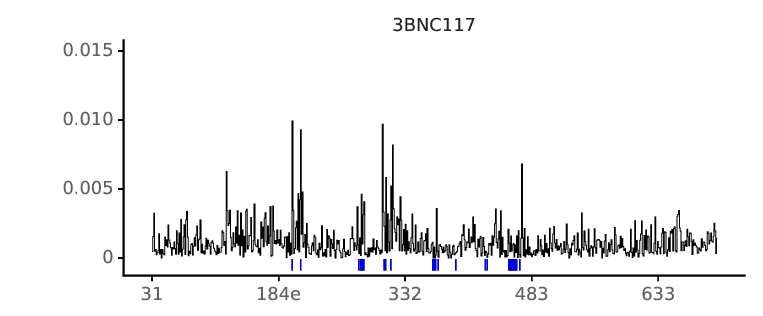

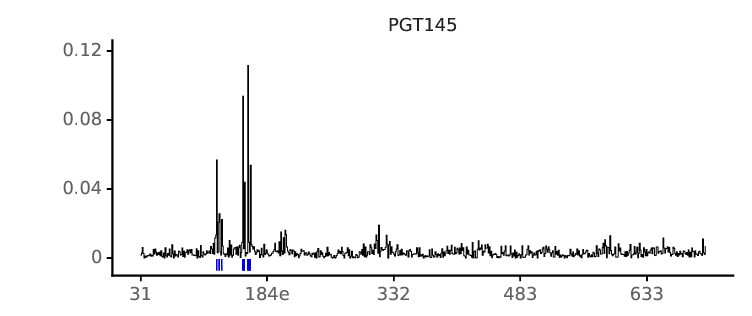

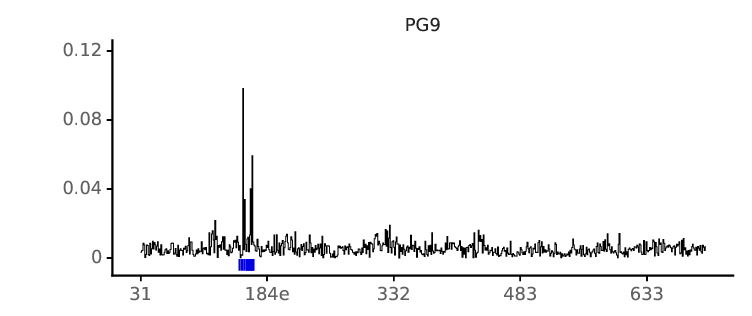

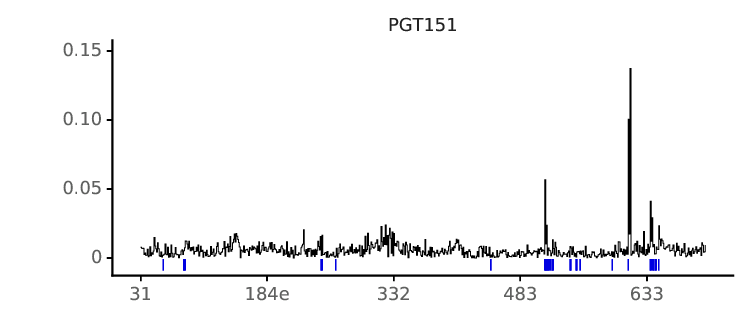

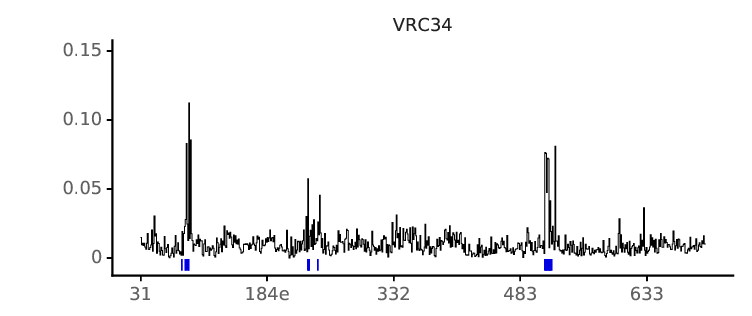

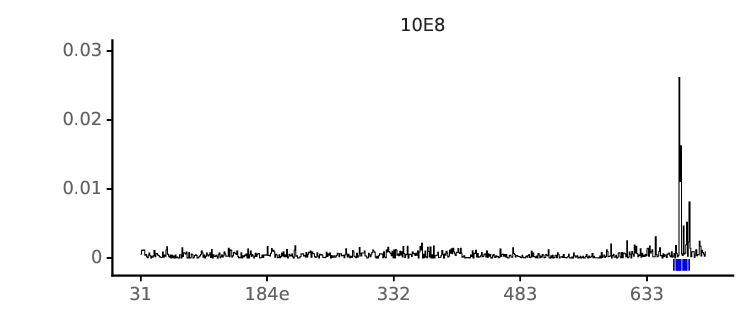

In [62]:
ylimdict = {}
ylimdict['101074'] = 0.07
ylimdict['PGT121'] = 0.07
ylimdict['3BNC117'] = 0.015
ylimdict['VRC01'] = 0.015
ylimdict['PG9'] = 0.12
ylimdict['PGT145'] = 0.12
ylimdict['PGT151'] = 0.15
ylimdict['VRC34'] = 0.15
ylimdict['10E8'] = 0.03
plots = []
diffseltype = "avgfracsurvive"
for antibody in antibodies:
    plotfile = "./results/fracsurviveaboveavg/concavg_SummaryPlots/{0}-median-avgfracsurviveaboveavg-annotated.pdf".format(antibody)
    epitope_sites = epitope_site_dict_ug[antibody]
    significant_sites = sigsites[antibody]
    highlighted_sites = epitope_sites_of_interest[antibody]
    names = [antibody]
    ylimit = ylimdict[antibody]
    diffselfiles = [phiaboveavg_dict[antibody]]
    plotSiteDiffSel_YLimDiff(names, diffselfiles, plotfile, "avgfracsurvive", maxcol=1, underlay_1=epitope_sites, point=significant_sites, highlighted_sites=highlighted_sites, y_lim=ylimit, white_bg=True)
    
    plots.append(plotfile)
    showPDF(plotfile)
#showPDF(plots)

## Make logoplots of key sites
Here, I will plot two sets of sites for each antibody. 

First, I plot the `fraction surviving above average`, `BG505 rescaled preferencs`, and the `frequency in nature` for **structurally defined contact sites**. These figures are not in the paper, but I speculate that some people (like me) will love to examine how these three metrics compare in the epitope of different antibodies. 

Next, I will plot the `fraction surviving above average` for **"sites of interest"** for each epitope. These groups of sites are defined above loosely based on contact sites, sites of significant escape, and prior literature for each antibody that targets that epitope. They are the sites shown in the paper figures. 

In [63]:
epitopelogodir = os.path.join(resultsdir, 'fracsurviveaboveavg/concavg_wtDNA_ctrl/EpitopeLogoplots/')
if not os.path.isdir(epitopelogodir):
    os.mkdir(epitopelogodir)

epitopekeys = epitope_site_dict_ug.keys()
for epitope in epitopekeys:
    specificepitope_dir = os.path.join(epitopelogodir, '{0}'.format(epitope))
    if not os.path.isdir(specificepitope_dir):
        os.mkdir(specificepitope_dir)

In [64]:
import phydmslib.weblogo
AA_COLORS_FG = phydmslib.weblogo.FunctionalGroupColorMapping()[1]

def siteSubsetGGSeqLogo(logodata, chars, plotfile, width, height,
        yname='', char_colors=AA_COLORS_FG, ylimits=None):
    """Creates one-row logo plot with subset of sites.
    Designed to show logo plot for a subset of sites. This
    is useful when you have data for many sites, but only
    want to look at a few of them. 
    Args:
        `logodata` (pandas DataFrame)
            Contains data to plot. Should have the columns
            `site`, `show`, and a column giving the height
            height of each char in `chars`. Only sites
            where `show` is `True` are shown. Sites are 
            shown in the order they occur in this dataframe,
            with spaces every time there is an interspersed
            site with `show` being `False`. 
        `chars` (list)
            Letters for which we plot heights.
        `plotfile` (str)
            Name of created plot.
        `width` (float)
            Width of plot in inches.
        `height` (float)
            Height of plot in inches.
        `yname` (str)
            If set to a non-empty string, is the y-axis label
            and yticks are drawn.
        `char_colors` (dict)
            Values give color for every character in `chars`.
        `ylimits` (`None` or 2-tuple)
            If not `None`, should give the ylimits for the plot
            as `(ymin, ymax)`
    Here is an example that creates a plot for a subset of
    sites for two characters:
    >>> logodata = pandas.read_csv(io.StringIO(
    ...     '''site show    A    C
    ...        A101 True  0.8  0.2
    ...        N102 True  0.7  0.3
    ...        K103 False 0.1  0.9
    ...        L104 True  0.8  0.2
    ...        S105 True  0.5  0.5
    ...        T106 False 0.2  0.8
    ...        G107 False 0.4  0.6
    ...        L108 True  0.7  0.3'''),
    ...     delim_whitespace=True, index_col=False)
    >>> plotfile = '_siteSubsetGGSeqLogo_test_plot.png'
    >>> siteSubsetGGSeqLogo(logodata,
    ...         chars=['A', 'C'],
    ...         plotfile=plotfile,
    ...         width=3.5, height=2
    ...         )
    >>> os.path.isfile(plotfile)
    True
    Here is the plot created by the code block above:
    .. image:: _static/_siteSubsetGGSeqLogo_test_plot.png
       :width: 55%
       :align: center
    """
    if os.path.isfile(plotfile):
        os.remove(plotfile)

    assert set(chars) <= set(char_colors.keys()), \
            "`char_colors` not defined for all chars"

    expectcol = ['site', 'show'] + chars
    assert set(logodata.columns) >= set(expectcol), \
            "`logodata` needs these column: {0}".format(expectcol)

    assert logodata['show'].any(), "no sites to show"

    # for each consecutive set of rows not to show, keep just one
    logodata = logodata[expectcol]
    logodata['keeprow'] = (
            ((logodata['show']) | 
                (logodata['show'] != logodata['show'].shift(1)))
            )
    logodata = logodata.query('keeprow').reset_index()

    # trim first and last row if they are not to be shown
    if not logodata.iloc[0]['show']:
        logodata = logodata.iloc[1 : ].reset_index()
    if not logodata.iloc[-1]['show']:
        logodata = logodata.iloc[ : -1]

    # set site label to empty and data to zero for rows not to show
    logodata.loc[~logodata['show'], 'site'] = ''
    logodata.loc[~logodata['show'], chars] = 0
    vertlines = logodata.query('~show').index.values + 1

    # generate matrix to plot
    sites = logodata['site']
    matrix = r.matrix(logodata.set_index('site')[chars].values.ravel(),
            ncol=len(sites),
            dimnames=[chars, sites]
            )

    if ylimits is None:
        ylimits = rinterface.NULL
    else:
        ylimits = FloatVector(ylimits)

    # make the plot
    with warnings.catch_warnings():
        warnings.simplefilter(SHOW_WARNINGS)
        _RFUNCS.siteSubsetGGSeqLogo(
                mat=matrix,
                plotfile=plotfile,
                width=width,
                height=height,
                xlabels=list(map(str, sites)),
                vertlines=vertlines,
                yname=yname,
                chars=StrVector(chars),
                char_colors=StrVector([char_colors[x] for x in chars]),
                ylimits=ylimits
                )

    if not os.path.isfile(plotfile):
        raise RuntimeError("failed to create {0}".format(plotfile))

### munge the LANL sequence alignment
`HIV1_FLT_2016_env_PRO.fasta` is the filtered web alignment of all HIV-1 sequences, downoaded Jan 3, 2018 from [`LANL`](https://www.hiv.lanl.gov/cgi-bin/NEWALIGN/align.cgi). We convert the alignment with the function below to amino acid frequencies. 
[./data/HXB2_HIV1_FLT_2016_env_PRO_numbering.csv](./data/HXB2_HIV1_FLT_2016_env_PRO_numbering.csv) is a csv file that contains the HXB2 sequence from the alignment (containing the insertions), with the site labeled according to it's site in the alingment. 
["./data/HXB2_alignment_to_HXB2.csv](./data/HXB2_alignment_to_HXB2.csv) contains a conversion between the alignment site and the HXB2 site. note that insertions sites relative to HXB2 are labled with an x rather than the actual notation (i.e. a, b etc). 

In [65]:
#here, I am redefining dms_tools2.prefs.aafreqsFromAlignment such that it gets rid of sequences that:
#are not the same length 
#mask sites that not IUPAC AAs. 
import Bio.SeqIO
def aafreqsFromAlignment_AD(alignmentfile, codon_to_aa,
        ignore_gaps=True, ignore_stop=True):
    """Get amino-acid frequencies at each site in alignment.

    Args:
        `alignmentfile` (str)
            FASTA file with alignment of proteins or coding sequences.
        `codon_to_aa` (bool)
            If `True`, translate codon alignment to amino acids.
        `ignore_gaps` (bool)
            Ignore gaps when calculating frequencies.
        `ignore_stop` (bool)
            Ignore stop codons when calculating frequencies.

    Returns:
        A `pandas.DataFrame` with columns being `site` (1, 2, ...
        numbering) and other columns being amino acids and values
        giving frequencies in alignment.

    >>> with tempfile.NamedTemporaryFile(mode='w') as f:
    ...     x = f.write('>seq1\\n'
    ...                 'ATGGGGCAG\\n'
    ...                 '>seq2\\n'
    ...                 '---AGGCAG\\n'
    ...                 '>seq3\\n'
    ...                 'ATGTGACAG')
    ...     f.flush()
    ...     aafreqs = aafreqsFromAlignment(f.name, codon_to_aa=True)
    >>> aas_counts = ['M', 'G', 'R', 'Q']
    >>> aas_nocounts = [a for a in dms_tools2.AAS if a not in aas_counts]
    >>> (0 == aafreqs[aas_nocounts].values).all()
    True
    >>> expected_counts = pandas.DataFrame.from_items([
    ...         ('site', [1, 2, 3]), ('M', [1.0, 0.0, 0.0]),
    ...         ('G', [0.0, 0.5, 0]), ('R', [0.0, 0.5, 0.0]),
    ...         ('Q', [0.0, 0.0, 1.0])])
    >>> expected_counts.equals(aafreqs[['site'] + aas_counts])
    True
    """
    # read sequences
    seqs = [s.seq for s in Bio.SeqIO.parse(alignmentfile, 'fasta')]
    if codon_to_aa:
        seqs = [s.translate(gap='-', stop_symbol='*') for s in seqs]
    assert seqs, "No sequences"
    seqlen = len(seqs[0])
    #assert seqlen, "sequences have no length" #commented this and line below out. 
    #assert all([seqlen == len(s) for s in seqs]), "seqs not same length"
    # get character sets
    aas = dms_tools2.AAS.copy()
    skipchars = ["#","?","X","$"] #here I added these other characters
    if ignore_gaps:
        skipchars.append('-')
    else:
        aas.append('-')
    if ignore_stop:
        skipchars.append('*')
    else:
        aas.append('*')
    # tally amino-acid frequencies
    aafreqs = dict([(col, [0] * seqlen) for col in aas])
    aafreqs['site'] = list(range(1, seqlen + 1))
    for s in seqs:
        for (r, aa) in enumerate(s):
            if aa in skipchars:
                continue
            else:
                aafreqs[aa][r] += 1
    # convert to dataframe and change counts to freqs
    aafreqs = pd.DataFrame(aafreqs)
    ncounts = aafreqs[aas].sum(axis=1).astype('float')
    for aa in aas:
        aafreqs[aa] = aafreqs[aa] / ncounts
    return aafreqs[['site'] + aas].fillna(0)

In [66]:
groupM_alignmentfile = "./data/HIV1_FLT_2016_env_PRO.fasta" 
groupM_df = aafreqsFromAlignment_AD(groupM_alignmentfile , codon_to_aa=False, ignore_gaps=True, ignore_stop=True)
alginment_to_HXB2 = pd.read_csv("./data/HXB2_alignment_to_HXB2.csv")
AnnotatedAlignment_df = alginment_to_HXB2.merge(groupM_df, left_on='alignment_site', right_on='site')
AnnotatedAlignment_df = AnnotatedAlignment_df.drop('site', 1)
AnnotatedAlignment_df = AnnotatedAlignment_df.drop('HXB2_AA', 1)
AnnotatedAlignment_df = AnnotatedAlignment_df.drop('alignment_site', 1)
AnnotatedAlignment_df = AnnotatedAlignment_df.rename(columns={'HXB2_site': 'site'})
AnnotatedAlignment_DropInserts_df = AnnotatedAlignment_df[AnnotatedAlignment_df.site.str.contains("x") == False].copy()

In [67]:
import natsort
def EpitopeFracsurviveLogoplot(mutfracsurvivefile, keysites, outfile, max_sitefracsurvive):
    pandadf = pd.read_csv(mutfracsurvivefile)
    df = dms_tools2.diffsel.tidyToWide(pandadf, valuecol='mutfracsurvive')

    #sort sites 
    df = df.reindex(index=natsort.order_by_index(df.index,natsort.index_natsorted(df.site)))
    df['show'] = df['site'].isin(keysites)
    df['site'] = df['wildtype'] + df['site']
    width = len(keysites) / 2.5
    dms_tools2.rplot.siteSubsetGGSeqLogo(
        logodata=df,
        chars=dms_tools2.AAS,
        plotfile=outfile,
        width= width,
        height=2.5,
        yname='frac surviving',
        ylimits=(0,max_sitefracsurvive),
    )
    
def EpitopePrefLogoplot(preffile, keysites, outfile):
    df = pd.read_csv(preffile)
    df = df.reindex(index=natsort.order_by_index(df.index,natsort.index_natsorted(df.site)))
    df['show'] = df['site'].isin(keysites)
    #df['site'] = df['wildtype'] + df['site']
    width = len(keysites) / 2.5
    dms_tools2.rplot.siteSubsetGGSeqLogo(
            logodata=df,
            chars=dms_tools2.AAS,
            plotfile=outfile,
            width=width,
            height=2,
            yname='preference',
            ylimits=(0,1.1),
            )
    
def EpitopeNatSeqLogoplot(HXB2annotated_df, keysites, outfile):
    df = HXB2annotated_df
    df = df.reindex(index=natsort.order_by_index(df.index,natsort.index_natsorted(df.site)))
    df['show'] = df['site'].isin(keysites)
    width = len(keysites) / 2.5
    dms_tools2.rplot.siteSubsetGGSeqLogo(
            logodata=df,
            chars=dms_tools2.AAS,
            plotfile=outfile,
            width=width,
            height=2,
            yname='freq in nature',
            ylimits=(0,1.1),
            )

In [68]:
epitope_site_dict = epitope_site_dict_ug

PGT121
Here are the fraction surviving, preferences, and frequency in nature of PGT121 at sites within 4 angstroms of PGT121


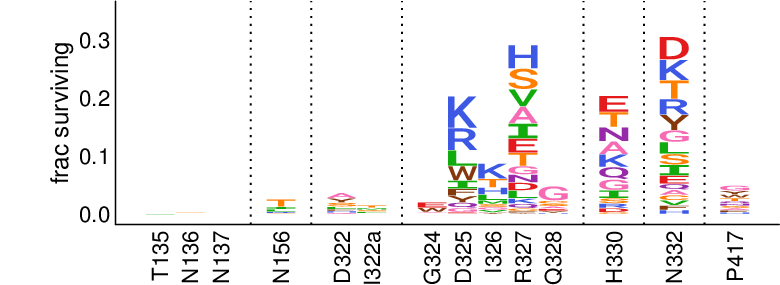

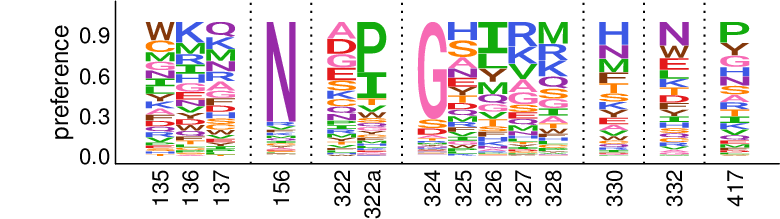

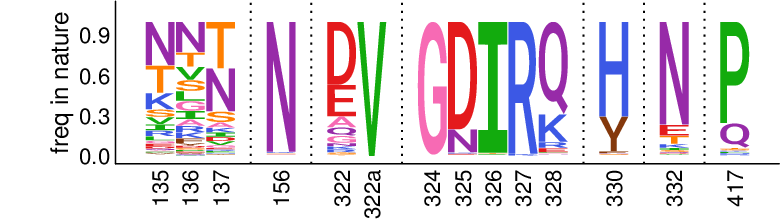

101074
Here are the fraction surviving, preferences, and frequency in nature of 101074 at sites within 4 angstroms of 101074


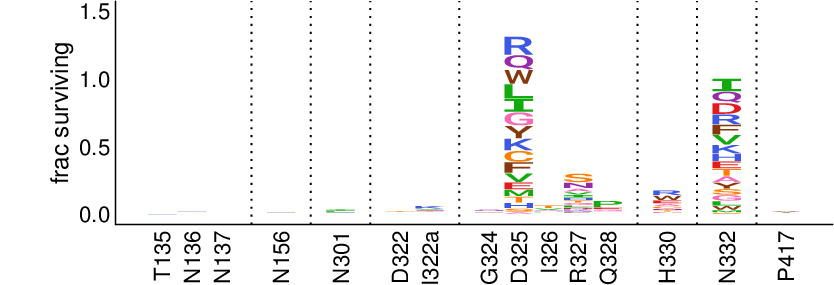

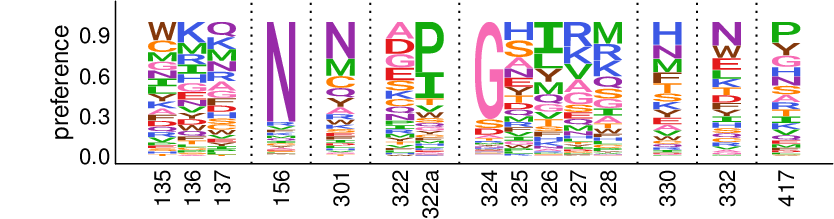

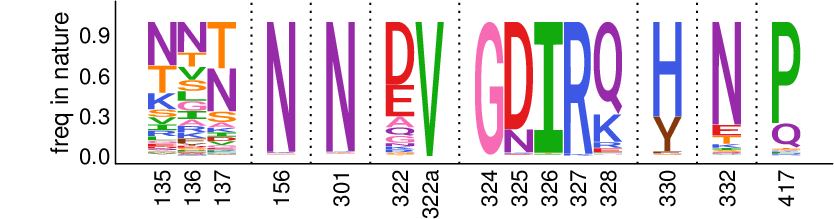

VRC01
Here are the fraction surviving, preferences, and frequency in nature of VRC01 at sites within 4 angstroms of VRC01


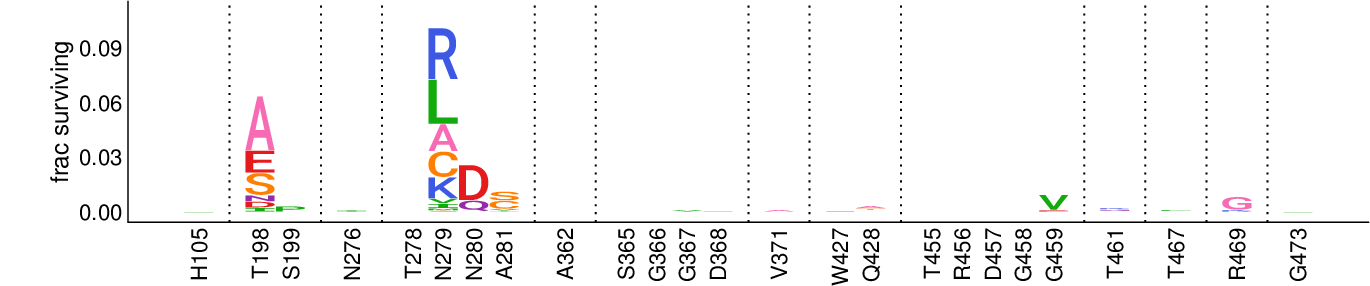

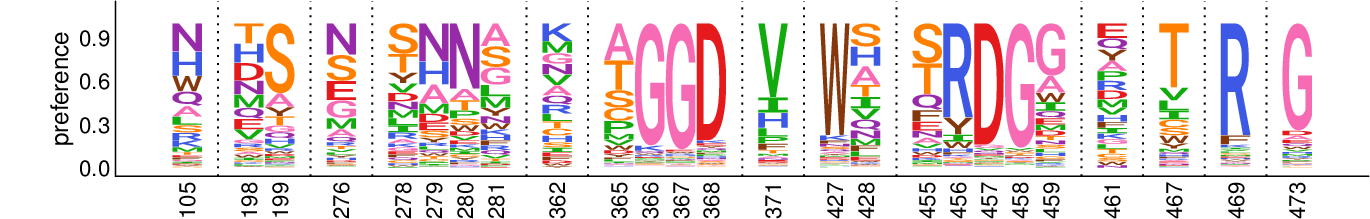

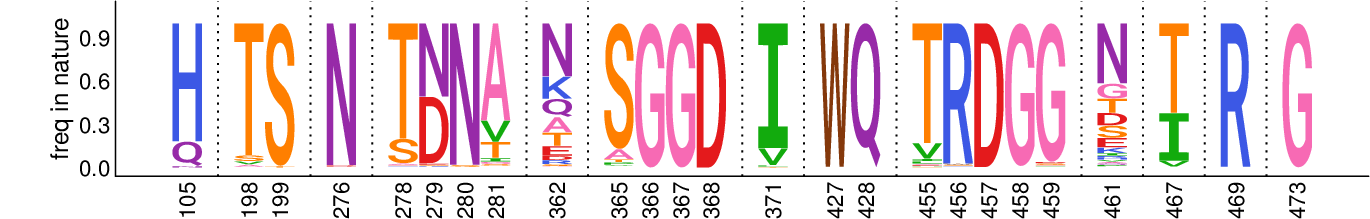

3BNC117
Here are the fraction surviving, preferences, and frequency in nature of 3BNC117 at sites within 4 angstroms of 3BNC117


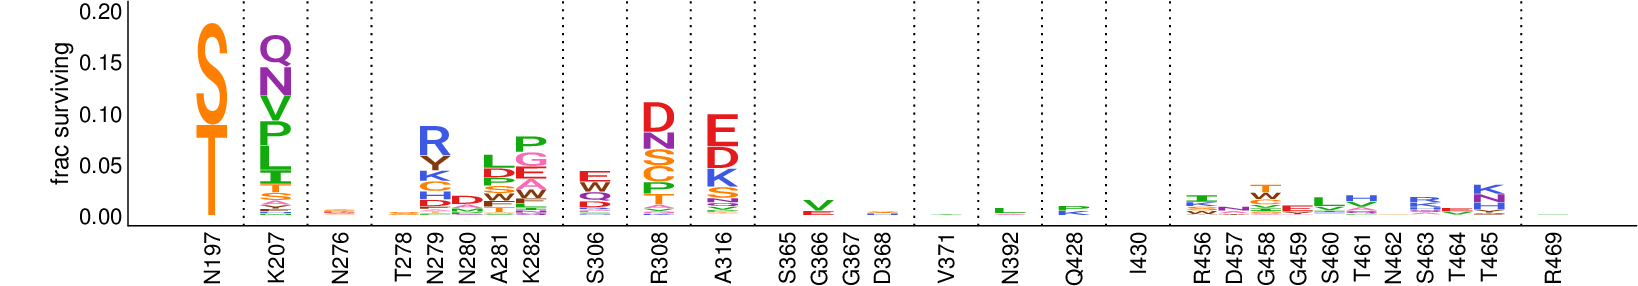

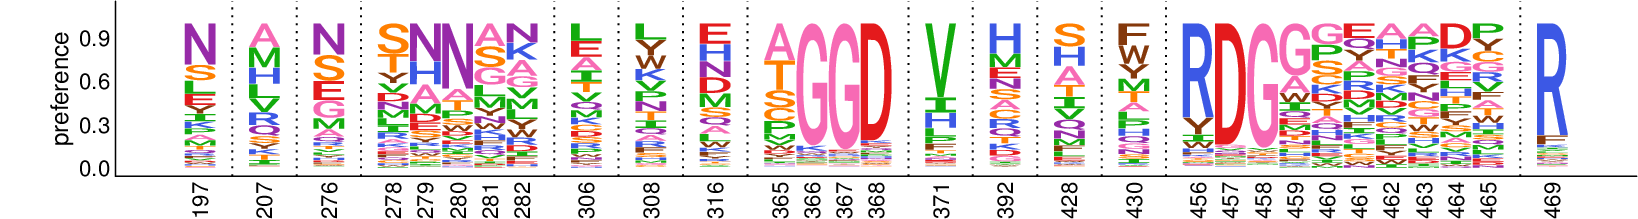

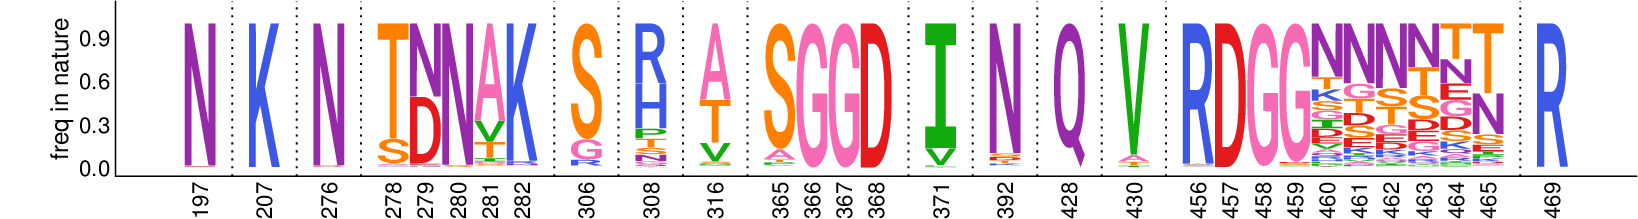

PGT145
Here are the fraction surviving, preferences, and frequency in nature of PGT145 at sites within 4 angstroms of PGT145


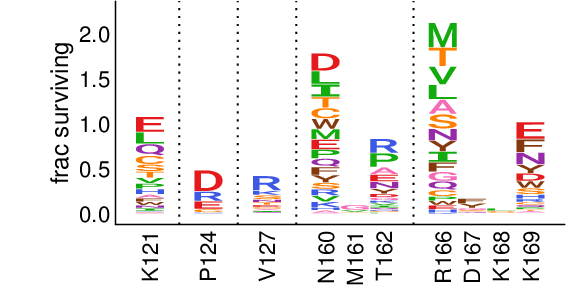

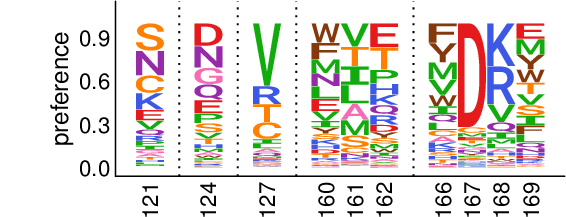

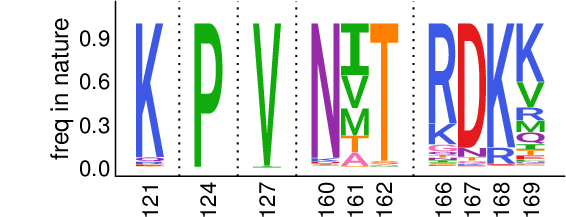

PG9
Here are the fraction surviving, preferences, and frequency in nature of PG9 at sites within 4 angstroms of PG9


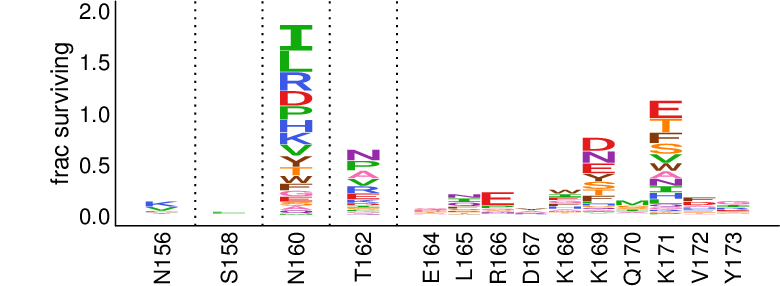

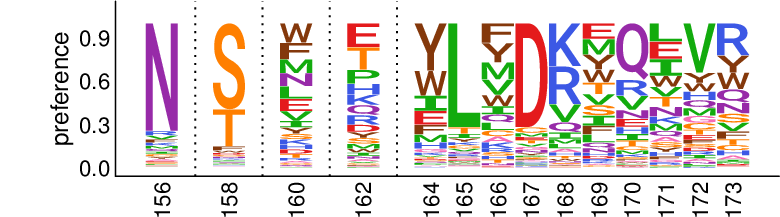

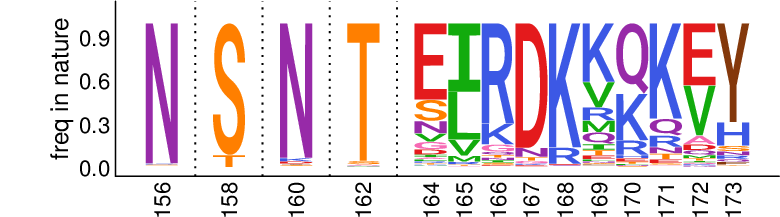

PGT151
Here are the fraction surviving, preferences, and frequency in nature of PGT151 at sites within 4 angstroms of PGT151


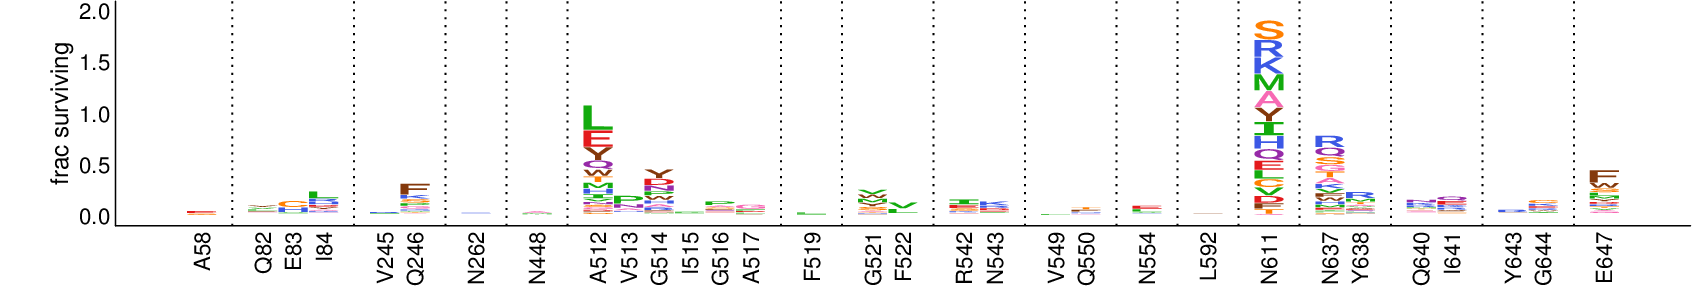

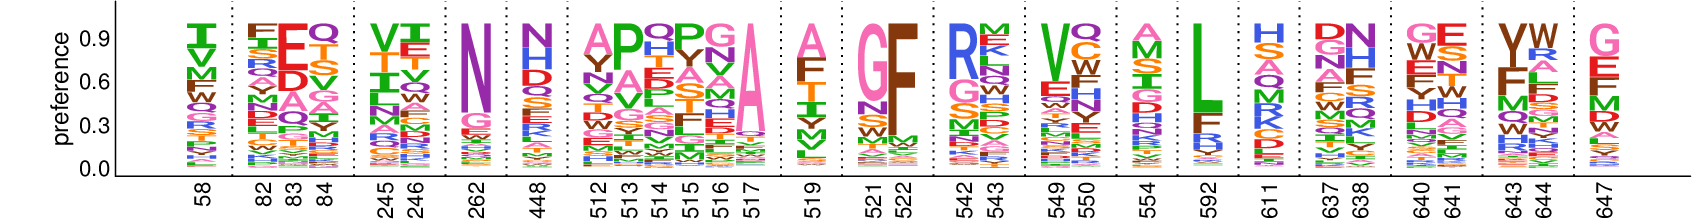

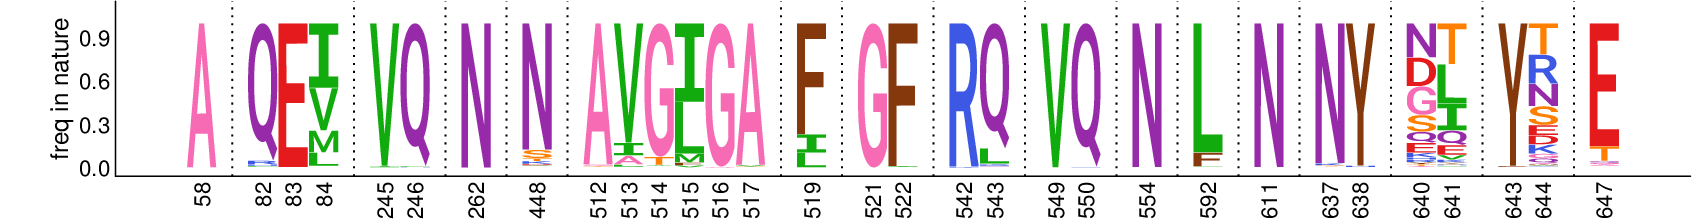

VRC34
Here are the fraction surviving, preferences, and frequency in nature of VRC34 at sites within 4 angstroms of VRC34


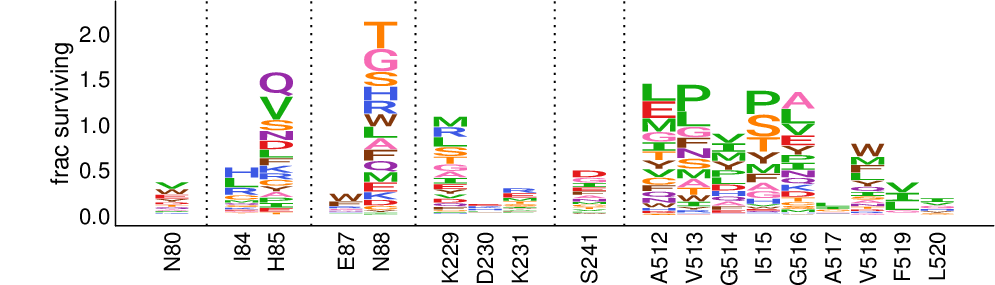

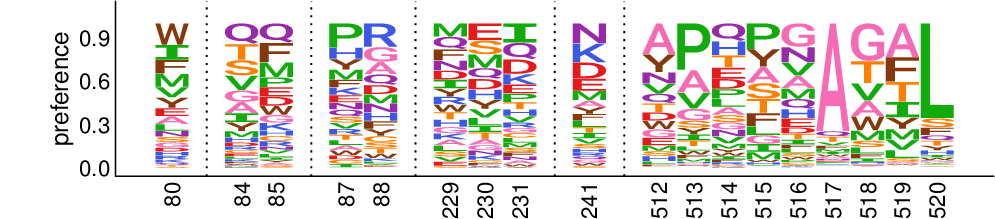

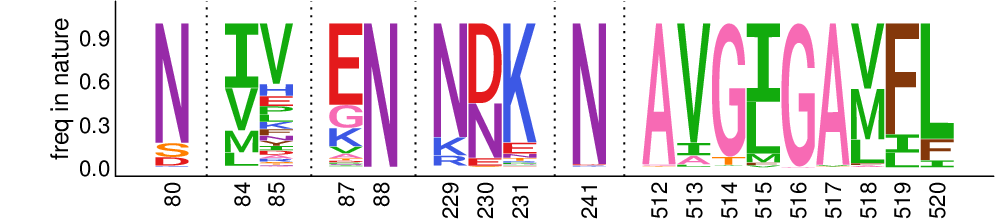

10E8
Here are the fraction surviving, preferences, and frequency in nature of 10E8 at sites within 4 angstroms of 10E8


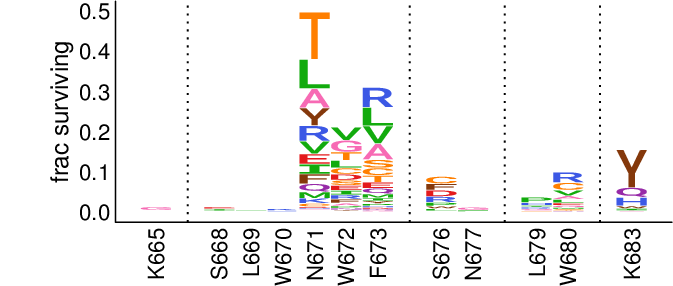

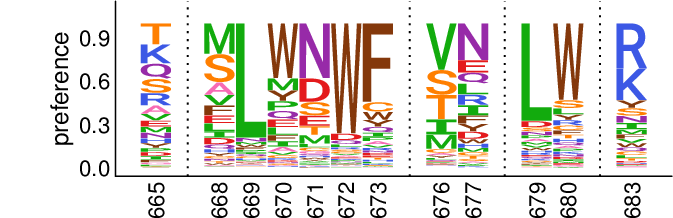

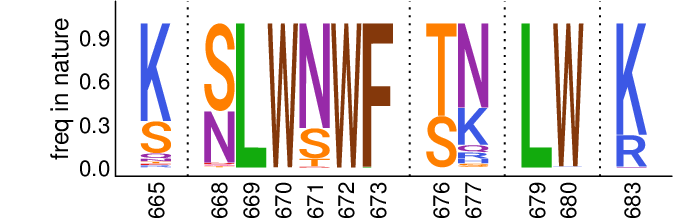

In [69]:

epitopekeys = epitope_site_dict.keys()
#note that the preffile below was manually aligned to conform to our new alignment, where insertion relative to LAI is at 322a rather than 317a.
preffile = "./data/BG505-avg-rescaled-prefs_ADrealigned.csv" 

natseq_df = AnnotatedAlignment_DropInserts_df.copy()

max_sitefracsurvive_dict = {}
max_sitefracsurvive_dict["VRC01"] = "0.11"
max_sitefracsurvive_dict["3BNC117"] = "0.2"
max_sitefracsurvive_dict["PGT121"]  = "0.35"
max_sitefracsurvive_dict["101074"]  = "1.5"
max_sitefracsurvive_dict["PGT151"] = "2"
max_sitefracsurvive_dict["VRC34"] = "2.25"
max_sitefracsurvive_dict["PG9"] = "2"
max_sitefracsurvive_dict["PGT145"] = "2.25"
max_sitefracsurvive_dict["10E8"] = "0.5"

#print(antibodies)
for ab in antibodies:
    epitopesites = epitope_site_dict[ab]

    fracsurvivefile= fracsurviveaboveavg_dict[ab]
    max_sitefracsurvive = max_sitefracsurvive_dict[ab]
    #print(fracsurvivefile)
    fs_outfile = "{0}{1}/{2}_epitope_fracsurviveaboveavg.pdf".format(epitopelogodir, ab, ab)
    pref_outfile = "{0}{1}/{2}_epitope_prefs.pdf".format(epitopelogodir, ab, ab)
    natseq_outfile = "{0}{1}/{2}_epitope_natseq.pdf".format(epitopelogodir, ab, ab)
    EpitopeFracsurviveLogoplot("{0}".format(fracsurvivefile), epitopesites, fs_outfile, max_sitefracsurvive)
    EpitopePrefLogoplot(preffile, epitopesites, pref_outfile)
    EpitopeNatSeqLogoplot(natseq_df, epitopesites, natseq_outfile)
    print(ab)
    print("Here are the fraction surviving, preferences, and frequency in nature of {0} at sites within 4 angstroms of {1}".format(ab, ab))
    pdflist = []
    showPDF(fs_outfile)
    showPDF(pref_outfile)
    showPDF(natseq_outfile)
    

Now, lets do the same as above, but have our arbitraily defined epitope sites.

PGT121
PGT121
Here is the fraction surviving PGT121 at sites of interest


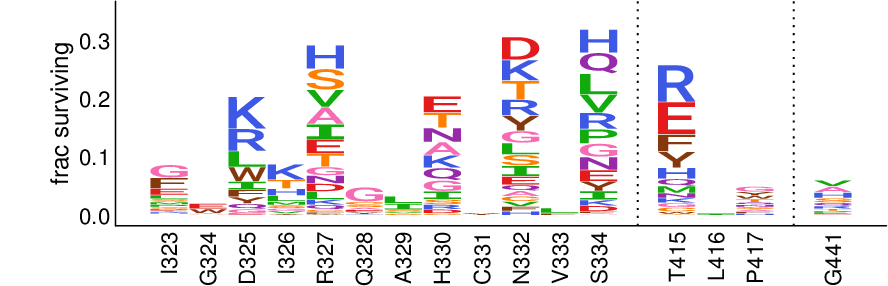

101074
101074
Here is the fraction surviving 101074 at sites of interest


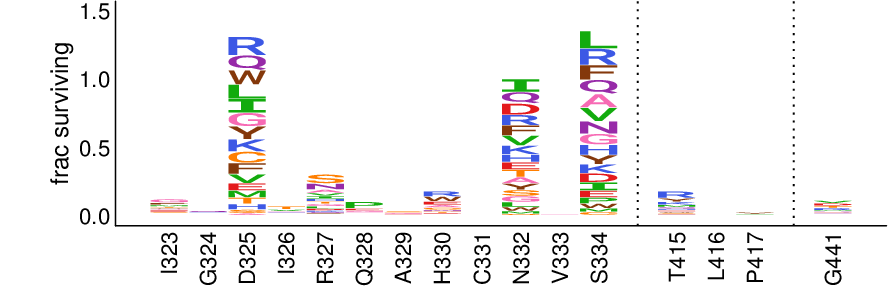

VRC01
VRC01
Here is the fraction surviving VRC01 at sites of interest


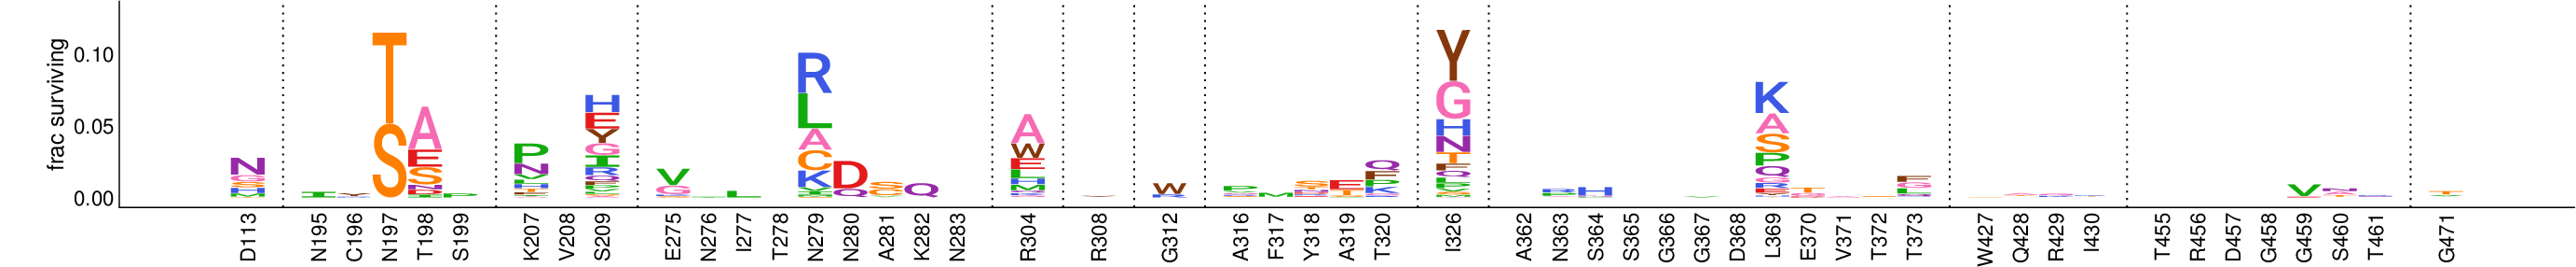

3BNC117
3BNC117
Here is the fraction surviving 3BNC117 at sites of interest


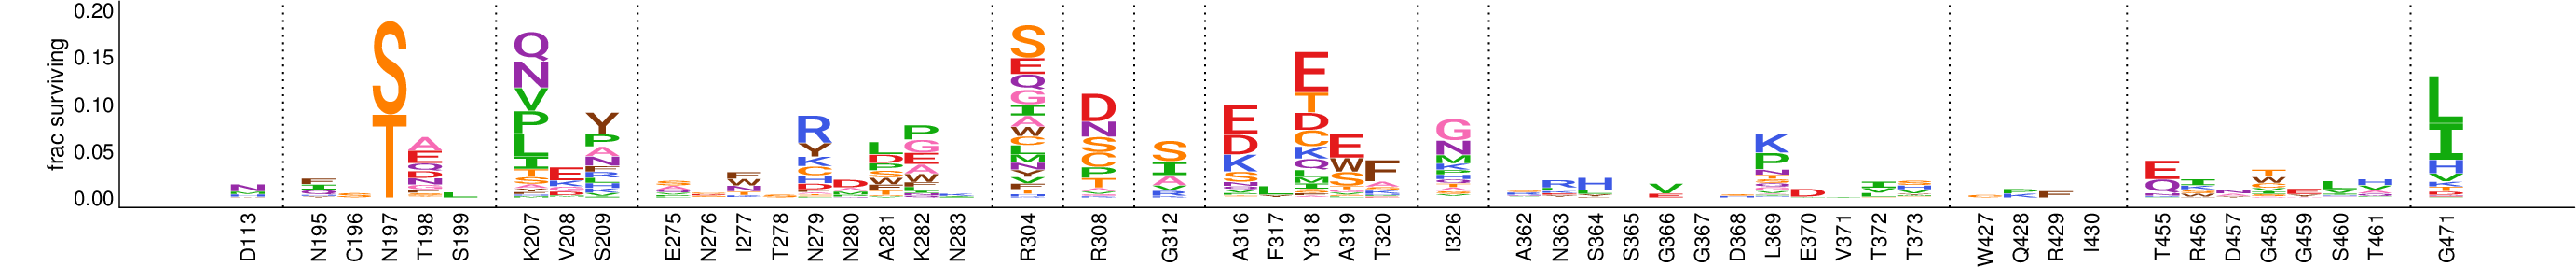

PGT145
PGT145
Here is the fraction surviving PGT145 at sites of interest


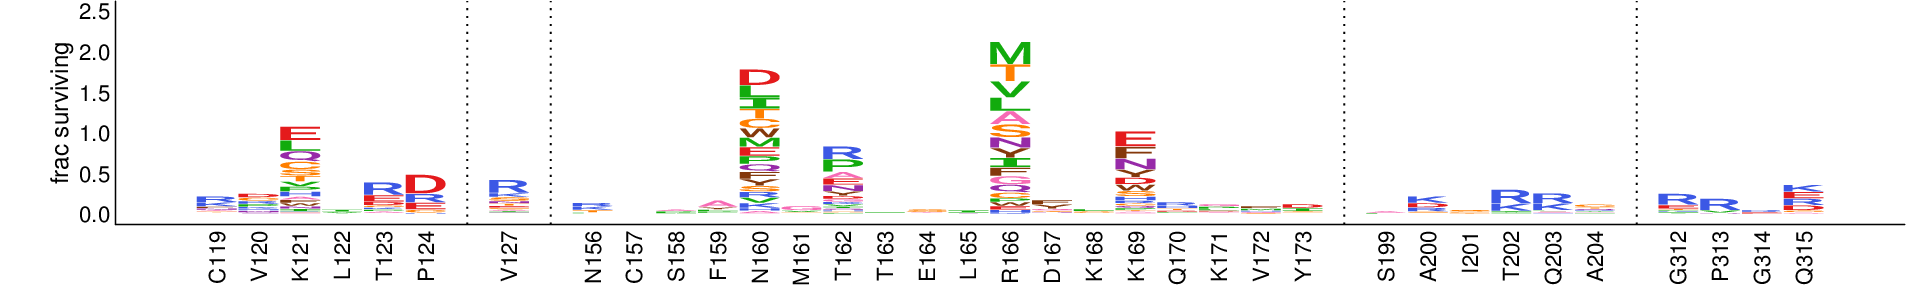

PG9
PG9
Here is the fraction surviving PG9 at sites of interest


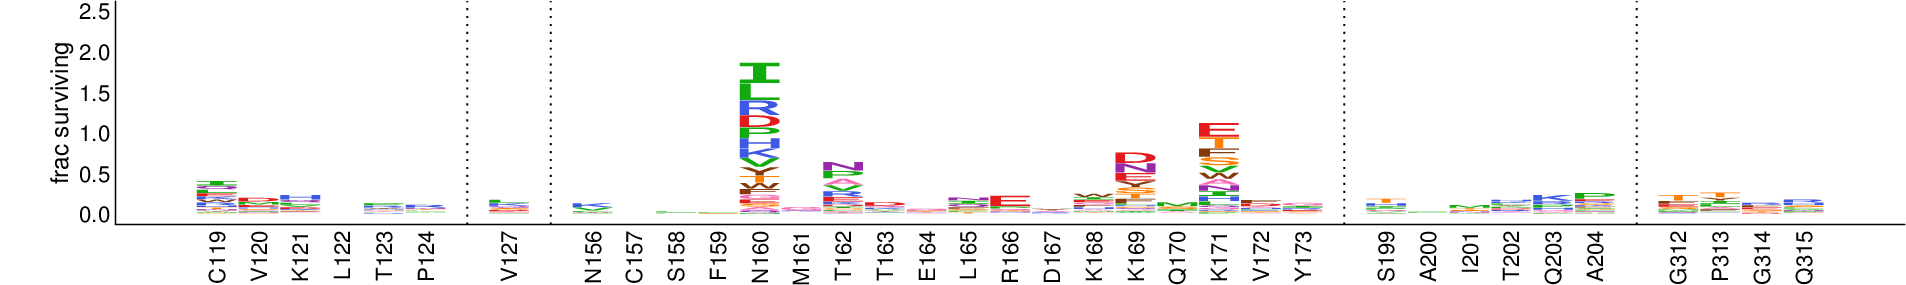

PGT151
PGT151
Here is the fraction surviving PGT151 at sites of interest


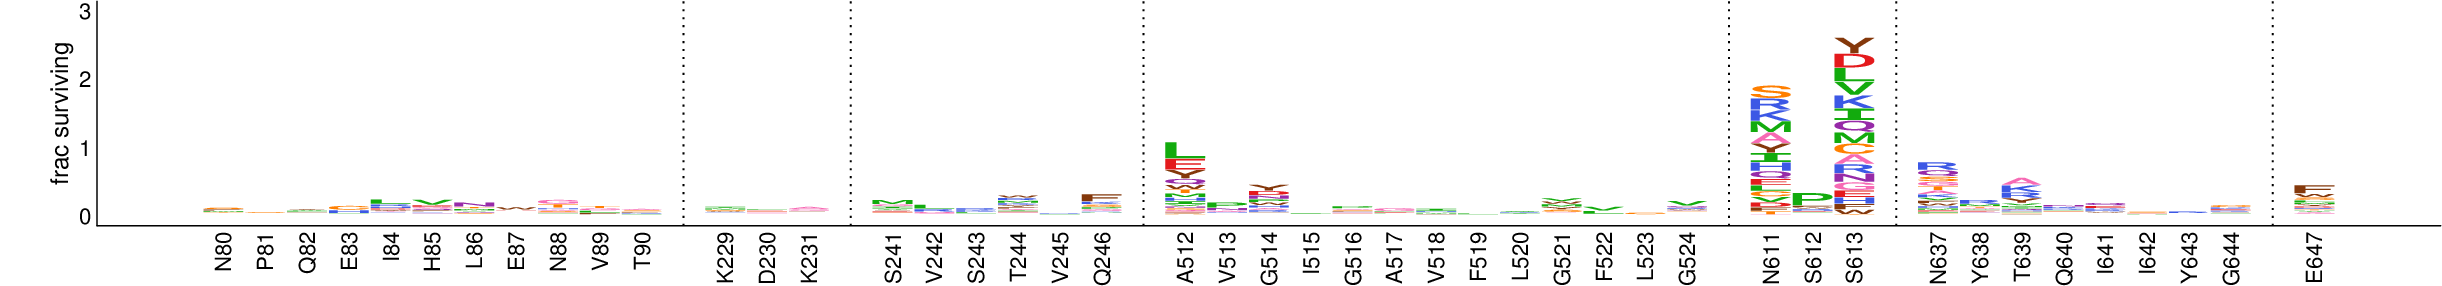

VRC34
VRC34
Here is the fraction surviving VRC34 at sites of interest


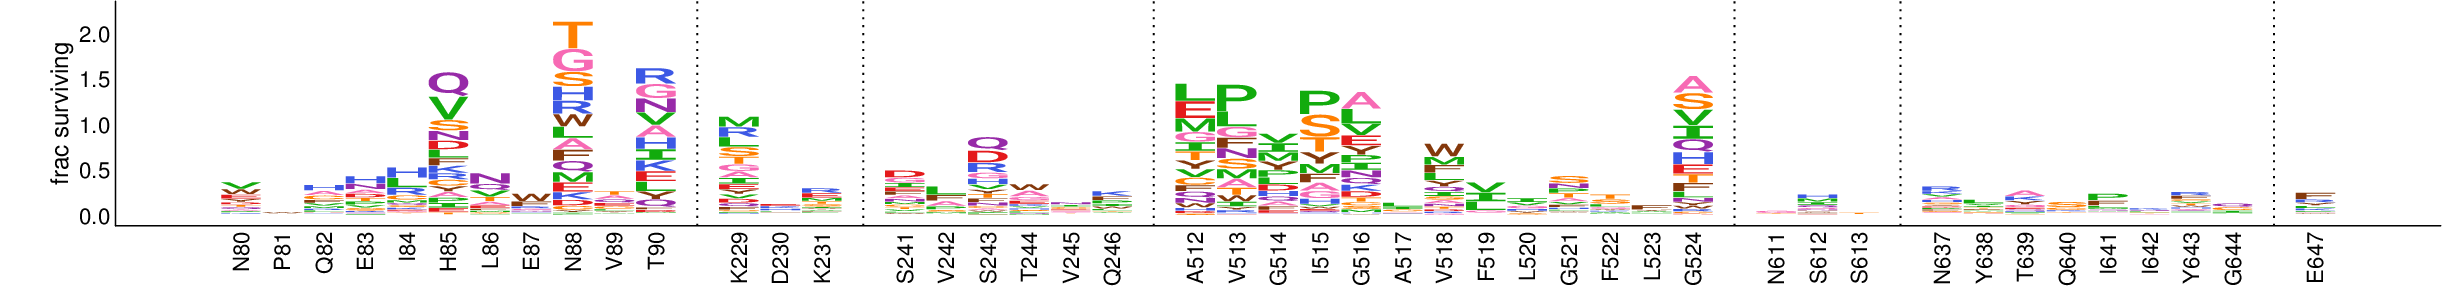

10E8
10E8
Here is the fraction surviving 10E8 at sites of interest


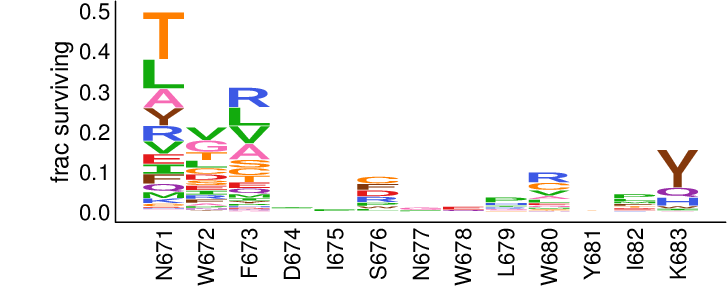

In [70]:
epitopelogodir = os.path.join(resultsdir, 'fracsurviveaboveavg/concavg_wtDNA_ctrl/EpitopeLogoplots/SitesOfInterest/')
if not os.path.isdir(epitopelogodir):
    os.mkdir(epitopelogodir)
    
fracsurviveaboveavg_dict_ug = {}
wtDNActrldict = "./results/fracsurviveaboveavg/concavg_wtDNA_ctrl"
fracsurviveaboveavg_dict_ug["VRC01"] = "{0}/summary_VRC01-medianmutfracsurvive.csv".format(wtDNActrldict) 
fracsurviveaboveavg_dict_ug["3BNC117"] = "{0}/summary_3BNC117-medianmutfracsurvive.csv".format(wtDNActrldict) 
fracsurviveaboveavg_dict_ug["PGT121"] = "{0}/summary_PGT121-medianmutfracsurvive.csv".format(wtDNActrldict) 
fracsurviveaboveavg_dict_ug["10E8"] = "{0}/summary_10E8-medianmutfracsurvive.csv".format(wtDNActrldict) 
fracsurviveaboveavg_dict_ug["PG9"] = "{0}/summary_PG9-medianmutfracsurvive.csv".format(wtDNActrldict) 
fracsurviveaboveavg_dict_ug["PGT151"] = "{0}/summary_PGT151-medianmutfracsurvive.csv".format(wtDNActrldict) 
fracsurviveaboveavg_dict_ug["VRC34"] = "{0}/summary_VRC34-medianmutfracsurvive.csv".format(wtDNActrldict) 
fracsurviveaboveavg_dict_ug["101074"] = "{0}/summary_101074-medianmutfracsurvive.csv".format(wtDNActrldict) 
fracsurviveaboveavg_dict_ug["PGT145"] = "{0}/summary_PGT145-medianmutfracsurvive.csv".format(wtDNActrldict) 

max_sitefracsurvive_dict = {}
max_sitefracsurvive_dict["VRC01"] = "0.13"
max_sitefracsurvive_dict["3BNC117"] = "0.2"
max_sitefracsurvive_dict["PGT121"]  = "0.35"
max_sitefracsurvive_dict["101074"]  = "1.5"
max_sitefracsurvive_dict["PGT151"] = "3.0"
max_sitefracsurvive_dict["VRC34"] = "2.25"
max_sitefracsurvive_dict["PG9"] = "2.5"
max_sitefracsurvive_dict["PGT145"] = "2.5"
max_sitefracsurvive_dict["10E8"] = "0.5"


natseq_df = AnnotatedAlignment_DropInserts_df.copy()
for ab in antibodies:
    epitopesites = epitope_sites_of_interest[ab]
    print(ab)
    max_sitefracsurvive = max_sitefracsurvive_dict[ab]
    fracsurvivefile= fracsurviveaboveavg_dict_ug[ab]
    fs_outfile = "{0}/{1}_epitope_fracsurviveaboveavg.pdf".format(epitopelogodir, ab)
    pref_outfile = "{0}/{1}_epitope_prefs.pdf".format(epitopelogodir, ab)
    natseq_outfile = "{0}/{1}_NatSeq.pdf".format(epitopelogodir, ab)
    EpitopeFracsurviveLogoplot("{0}".format(fracsurvivefile), epitopesites, fs_outfile, max_sitefracsurvive)
    EpitopePrefLogoplot(preffile, epitopesites, pref_outfile)
    EpitopeNatSeqLogoplot(natseq_df, epitopesites, natseq_outfile)
    print(ab)
    print("Here is the fraction surviving {0} at sites of interest".format(ab, ab))
    pdflist = []
    showPDF(fs_outfile)



## Pooled 3BNC117 and 10-1074 analyses
Here, we will analyze and plot escape from the pooled antibodies. We also model how escape would appear based on escape porfile of each antibody in isolation. 

In [71]:
poolsummplotdir = "./results/fracsurviveaboveavg/concavg_SummaryPlots/pooled/"
if not os.path.isdir(poolsummplotdir):
    os.mkdir(poolsummplotdir)

First, we will generate simulated data by mulitplying together each antibody's `mutation fraction surviving above average` values. I do this for both the mean and median datasets. 

In [72]:
AAsimulatedpooldir = os.path.join( './results/fracsurviveaboveavg/concavg_wtDNA_ctrl/Simulated_Pool/')
if not os.path.isdir(AAsimulatedpooldir):
    os.mkdir(AAsimulatedpooldir)

In [73]:
def MultiplyMFS(MFS1, MFS2, output_file_name):
    mfs1_df = pd.read_csv(MFS1)
    mfs2_df = pd.read_csv(MFS2)
    mfs1_df["name"] = mfs1_df["wildtype"] + "_" + mfs1_df["site"] + "_" +  mfs1_df["mutation"]
    mfs1_df = mfs1_df.rename(columns={'mutfracsurvive': 'mutfracsurvive_1'})
    mfs2_df["name"] = mfs2_df["wildtype"] + "_" + mfs2_df["site"] + "_" +  mfs2_df["mutation"]
    mfs2_df = mfs2_df.rename(columns={'mutfracsurvive': 'mutfracsurvive_2'})
    mfs2_df.drop('site', axis=1, inplace=True)
    mfs2_df.drop('wildtype', axis=1, inplace=True)
    mfs2_df.drop('mutation', axis=1, inplace=True)
    merged_df = mfs1_df.merge(mfs2_df, on=['name'])
    merged_df["mutfracsurvive"] = merged_df['mutfracsurvive_1']*merged_df['mutfracsurvive_2']
    merged_df.drop('name', axis=1, inplace=True)
    merged_df.drop('mutfracsurvive_1', axis=1, inplace=True)
    merged_df.drop('mutfracsurvive_2', axis=1, inplace=True)

    merged_df = merged_df.sort_values('mutfracsurvive', ascending = False)
    merged_df.to_csv(output_file_name, index=False)


In [74]:
MFS1 = "./results/fracsurviveaboveavg/concavg_wtDNA_ctrl/summary_3BNC117-medianmutfracsurvive.csv"
MFS2 = "./results/fracsurviveaboveavg/concavg_wtDNA_ctrl/summary_101074-medianmutfracsurvive.csv"
output_file = "./results/fracsurviveaboveavg/concavg_wtDNA_ctrl/Simulated_Pool/Simulated_3BNC117median_101074median-aboveavg-medianmutfracsurvive.csv"
MultiplyMFS(MFS1, MFS2, output_file)

MFS1 = "./results/fracsurviveaboveavg/concavg_wtDNA_ctrl/summary_3BNC117-meanmutfracsurvive.csv"
MFS2 = "./results/fracsurviveaboveavg/concavg_wtDNA_ctrl/summary_101074-meanmutfracsurvive.csv"
output_file = "./results/fracsurviveaboveavg/concavg_wtDNA_ctrl/Simulated_Pool/Simulated_3BNC117mean_101074mean-aboveavg-meanmutfracsurvive.csv"
MultiplyMFS(MFS1, MFS2, output_file)

Now, lets look at the simulate data alongside the experimental data for sites in the epitope. 

3BNC117
Here is the fraction surviving 3BNC117 at sites of interest


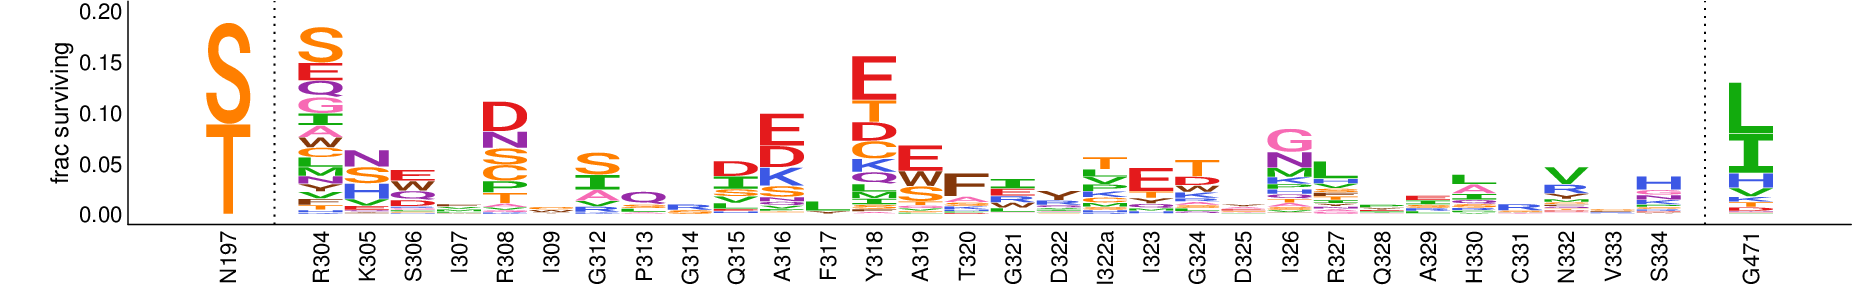

101074
Here is the fraction surviving 101074 at sites of interest


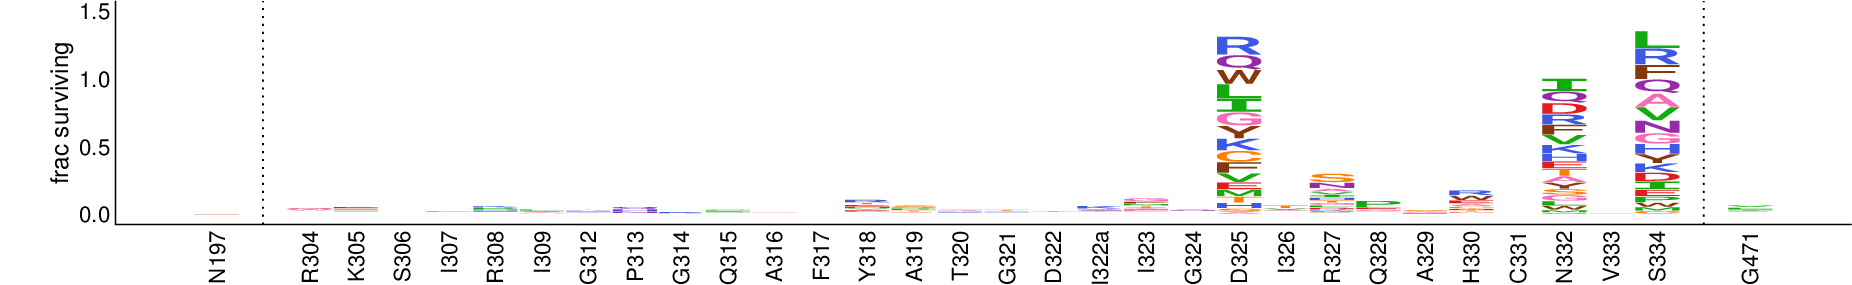

3BNC117-101074_mean
Here is the fraction surviving 3BNC117-101074_mean at sites of interest


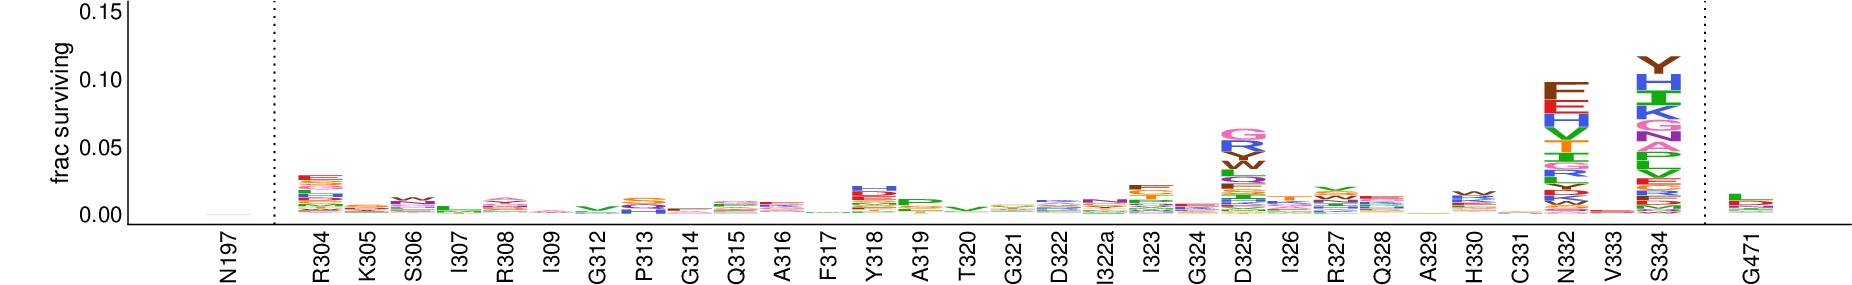

3BNC117-101074_median
Here is the fraction surviving 3BNC117-101074_median at sites of interest


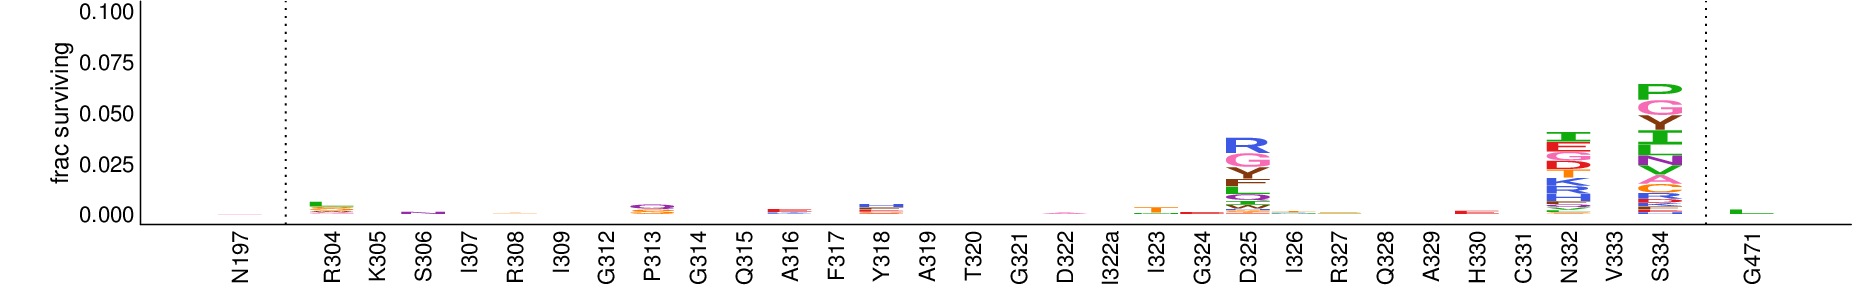

Simulated_3BNC117-101074_mean
Here is the fraction surviving Simulated_3BNC117-101074_mean at sites of interest


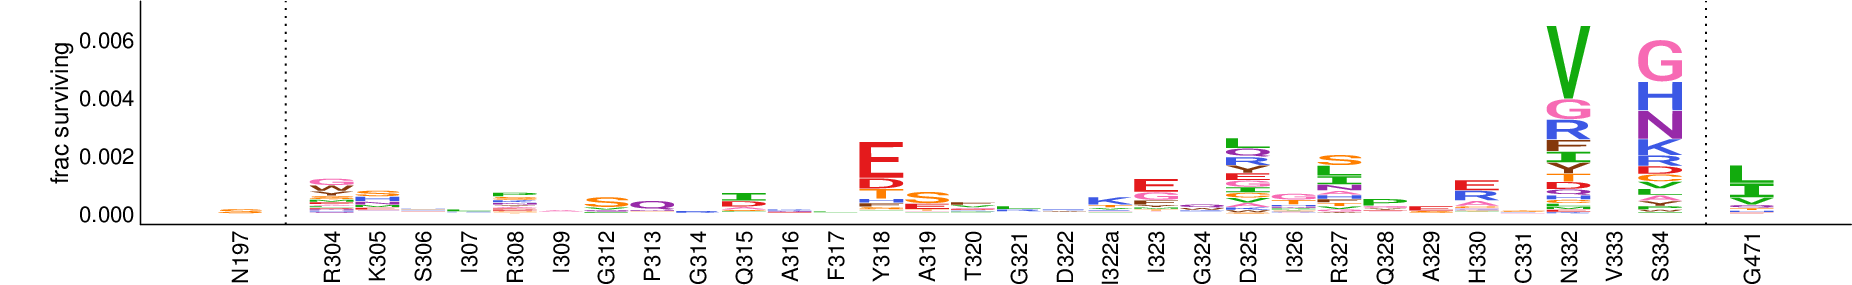

Simulated_3BNC117-101074_median
Here is the fraction surviving Simulated_3BNC117-101074_median at sites of interest


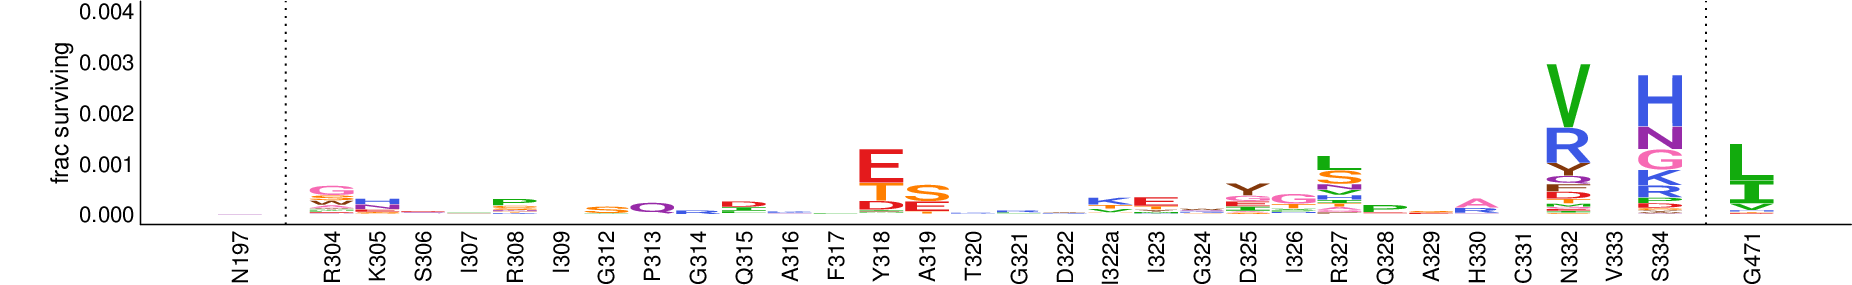

In [75]:
pooled_subset = ["3BNC117", "101074", "3BNC117-101074_mean", "3BNC117-101074_median", "Simulated_3BNC117-101074_mean", "Simulated_3BNC117-101074_median"]
pooled_epitope_sites_2  = list(range(304, 335))

# Env sites numbers are strings because some have trailing letters (e.g., 100A)
pooled_epitope_sites_2 = list(map(str, pooled_epitope_sites_2))
pooled_epitope_sites_2.append("197")
pooled_epitope_sites_2.append("322a")
pooled_epitope_sites_2.append("471")

fracsurvive_dict = {}
fracsurvive_dict["3BNC117"] = "./results/fracsurviveaboveavg/concavg_wtDNA_ctrl/summary_3BNC117-medianmutfracsurvive.csv"
fracsurvive_dict["101074"] = "./results/fracsurviveaboveavg/concavg_wtDNA_ctrl/summary_101074-medianmutfracsurvive.csv"
fracsurvive_dict["3BNC117-101074_mean"] = "./results/fracsurviveaboveavg/concavg_wtDNA_ctrl/summary_3BN-1074-pool-meanmutfracsurvive.csv"
fracsurvive_dict["3BNC117-101074_median"] = "./results/fracsurviveaboveavg/concavg_wtDNA_ctrl/summary_3BN-1074-pool-medianmutfracsurvive.csv"
fracsurvive_dict["Simulated_3BNC117-101074_mean"] = "./results/fracsurviveaboveavg/concavg_wtDNA_ctrl/Simulated_Pool/Simulated_3BNC117mean_101074mean-aboveavg-meanmutfracsurvive.csv"
fracsurvive_dict["Simulated_3BNC117-101074_median"] = "./results/fracsurviveaboveavg/concavg_wtDNA_ctrl/Simulated_Pool/Simulated_3BNC117median_101074median-aboveavg-medianmutfracsurvive.csv"

max_sitefracsurvive_dict = {}
max_sitefracsurvive_dict["3BNC117"] = "0.2"
max_sitefracsurvive_dict["101074"]  = "1.5"
max_sitefracsurvive_dict["3BNC117-101074_mean"]  = "0.15"
max_sitefracsurvive_dict["3BNC117-101074_median"]  = "0.1"
max_sitefracsurvive_dict["Simulated_3BNC117-101074_mean"]  = "0.007"
max_sitefracsurvive_dict["Simulated_3BNC117-101074_median"]  = "0.004"

for ab in pooled_subset:
    epitopesites = pooled_epitope_sites_2
    max_sitefracsurvive = max_sitefracsurvive_dict[ab]
    fracsurvivefile= fracsurvive_dict[ab]
    fs_outfile = "{0}/{1}_epitope_fracsurvive.pdf".format(AAsimulatedpooldir, ab)
    EpitopeFracsurviveLogoplot("{0}".format(fracsurvivefile), epitopesites, fs_outfile, max_sitefracsurvive)
    print(ab)
    print("Here is the fraction surviving {0} at sites of interest".format(ab, ab))
    pdflist = []
    showPDF(fs_outfile)


The simulated mean and median value are quite similar. In the end, I plot the simulated mean values in the paper because it appears more similar to the experimental data. Note that this is a very heurisitc analysis, and the use of mean or median does not affect the interpretation. Also note that more complex models may be able to better explain the data (such as weighting the effect of one antibody vs. the other).

Next, we plot the line plot for the simulated data. 

In [76]:
import dms_tools2.fracsurvive
SimPoolMean_mfs2 = pd.read_csv("./results/fracsurviveaboveavg/concavg_wtDNA_ctrl/Simulated_Pool/Simulated_3BNC117mean_101074mean-aboveavg-meanmutfracsurvive.csv")
SimPoolMean_sfs2 = dms_tools2.fracsurvive.mutToSiteFracSurvive(SimPoolMean_mfs2)
SimPoolMean_sfs2.to_csv("./results/fracsurviveaboveavg/concavg_wtDNA_ctrl/Simulated_Pool/Simulated_3BNC117mean_101074mean-aboveavg-meansitefracsurvive.csv", encoding='utf-8', index=False )


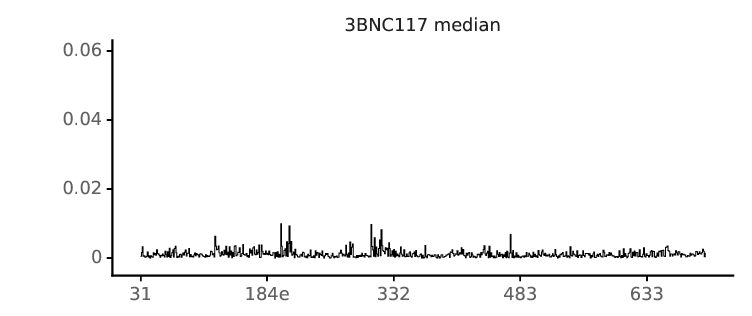

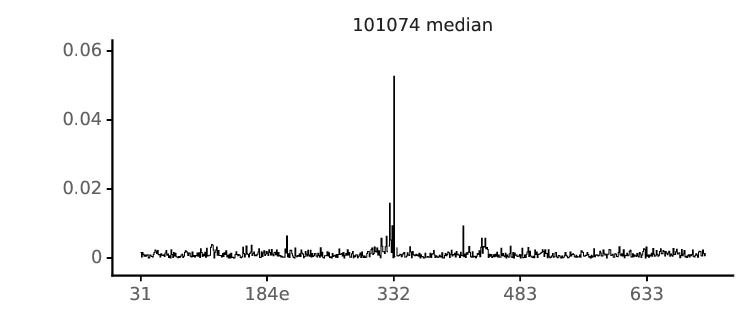

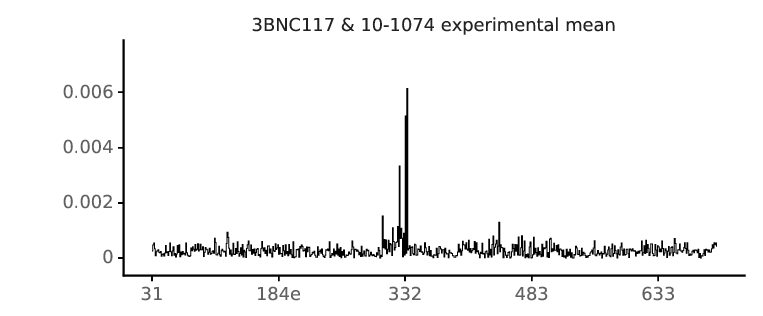

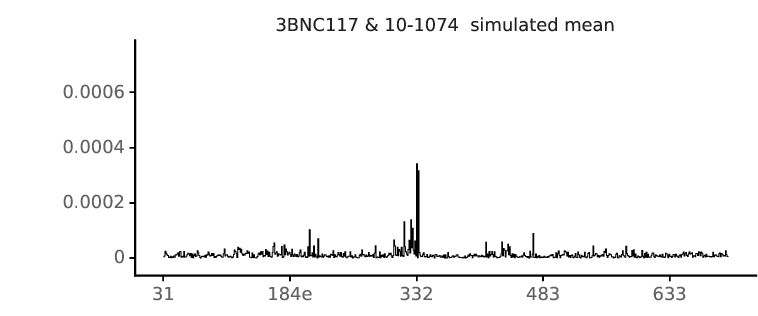

In [77]:
names = ["3BNC117 median", "101074 median", "3BNC117 & 10-1074 experimental mean", "3BNC117 & 10-1074  simulated mean"]

infiles = ["./results/fracsurviveaboveavg/concavg_wtDNA_ctrl/summary_3BNC117-mediansitefracsurvive.csv",
          "./results/fracsurviveaboveavg/concavg_wtDNA_ctrl/summary_101074-mediansitefracsurvive.csv",
          "./results/fracsurviveaboveavg/concavg_wtDNA_ctrl/summary_3BN-1074-pool-meansitefracsurvive.csv",
          "./results/fracsurviveaboveavg/concavg_wtDNA_ctrl/Simulated_Pool/Simulated_3BNC117mean_101074mean-aboveavg-meansitefracsurvive.csv"
          ]
diffseltype = "avgfracsurvive"




ylimdict = {}
ylimdict['3BNC117 median'] = 0.06
ylimdict['101074 median'] = 0.06
ylimdict['3BNC117 & 10-1074 experimental mean'] = 0.0075
ylimdict['3BNC117 & 10-1074  simulated mean'] = 0.00075
plots = []
diffseltype = "avgfracsurvive"
significant_sites = []
epitope_sites = []
highlighted_sites = pooled_epitope_sites_2
for antibody, file in zip(names, infiles):
    plotfile = "./results/fracsurviveaboveavg/concavg_wtDNA_ctrl/Simulated_Pool/{0}-FORPOOLCOMPARE-avgfracsurviveaboveavg.pdf".format(antibody)
    names = [antibody]
    ylimit = ylimdict[antibody]
    diffselfiles = [file]
    plotSiteDiffSel_YLimDiff(names, diffselfiles, plotfile, "avgfracsurvive", maxcol=1, underlay_1=epitope_sites, point=significant_sites, highlighted_sites=highlighted_sites, y_lim=ylimit, white_bg=True)
    
    plots.append(plotfile)
    showPDF(plotfile)

now, we plot the whole gene logoplot for both simulated datasets. 

./results/fracsurviveaboveavg/concavg_wtDNA_ctrl/Simulated_Pool/Simulated-3BNC117median-101074median-aboveavg_fracsurvive.pdf

Creating logo plot for Simulated-3BNC117median-101074median-aboveavg from ./results/fracsurviveaboveavg/concavg_wtDNA_ctrl/Simulated_Pool/Simulated_3BNC117median_101074median-aboveavg-medianmutfracsurvive.csv


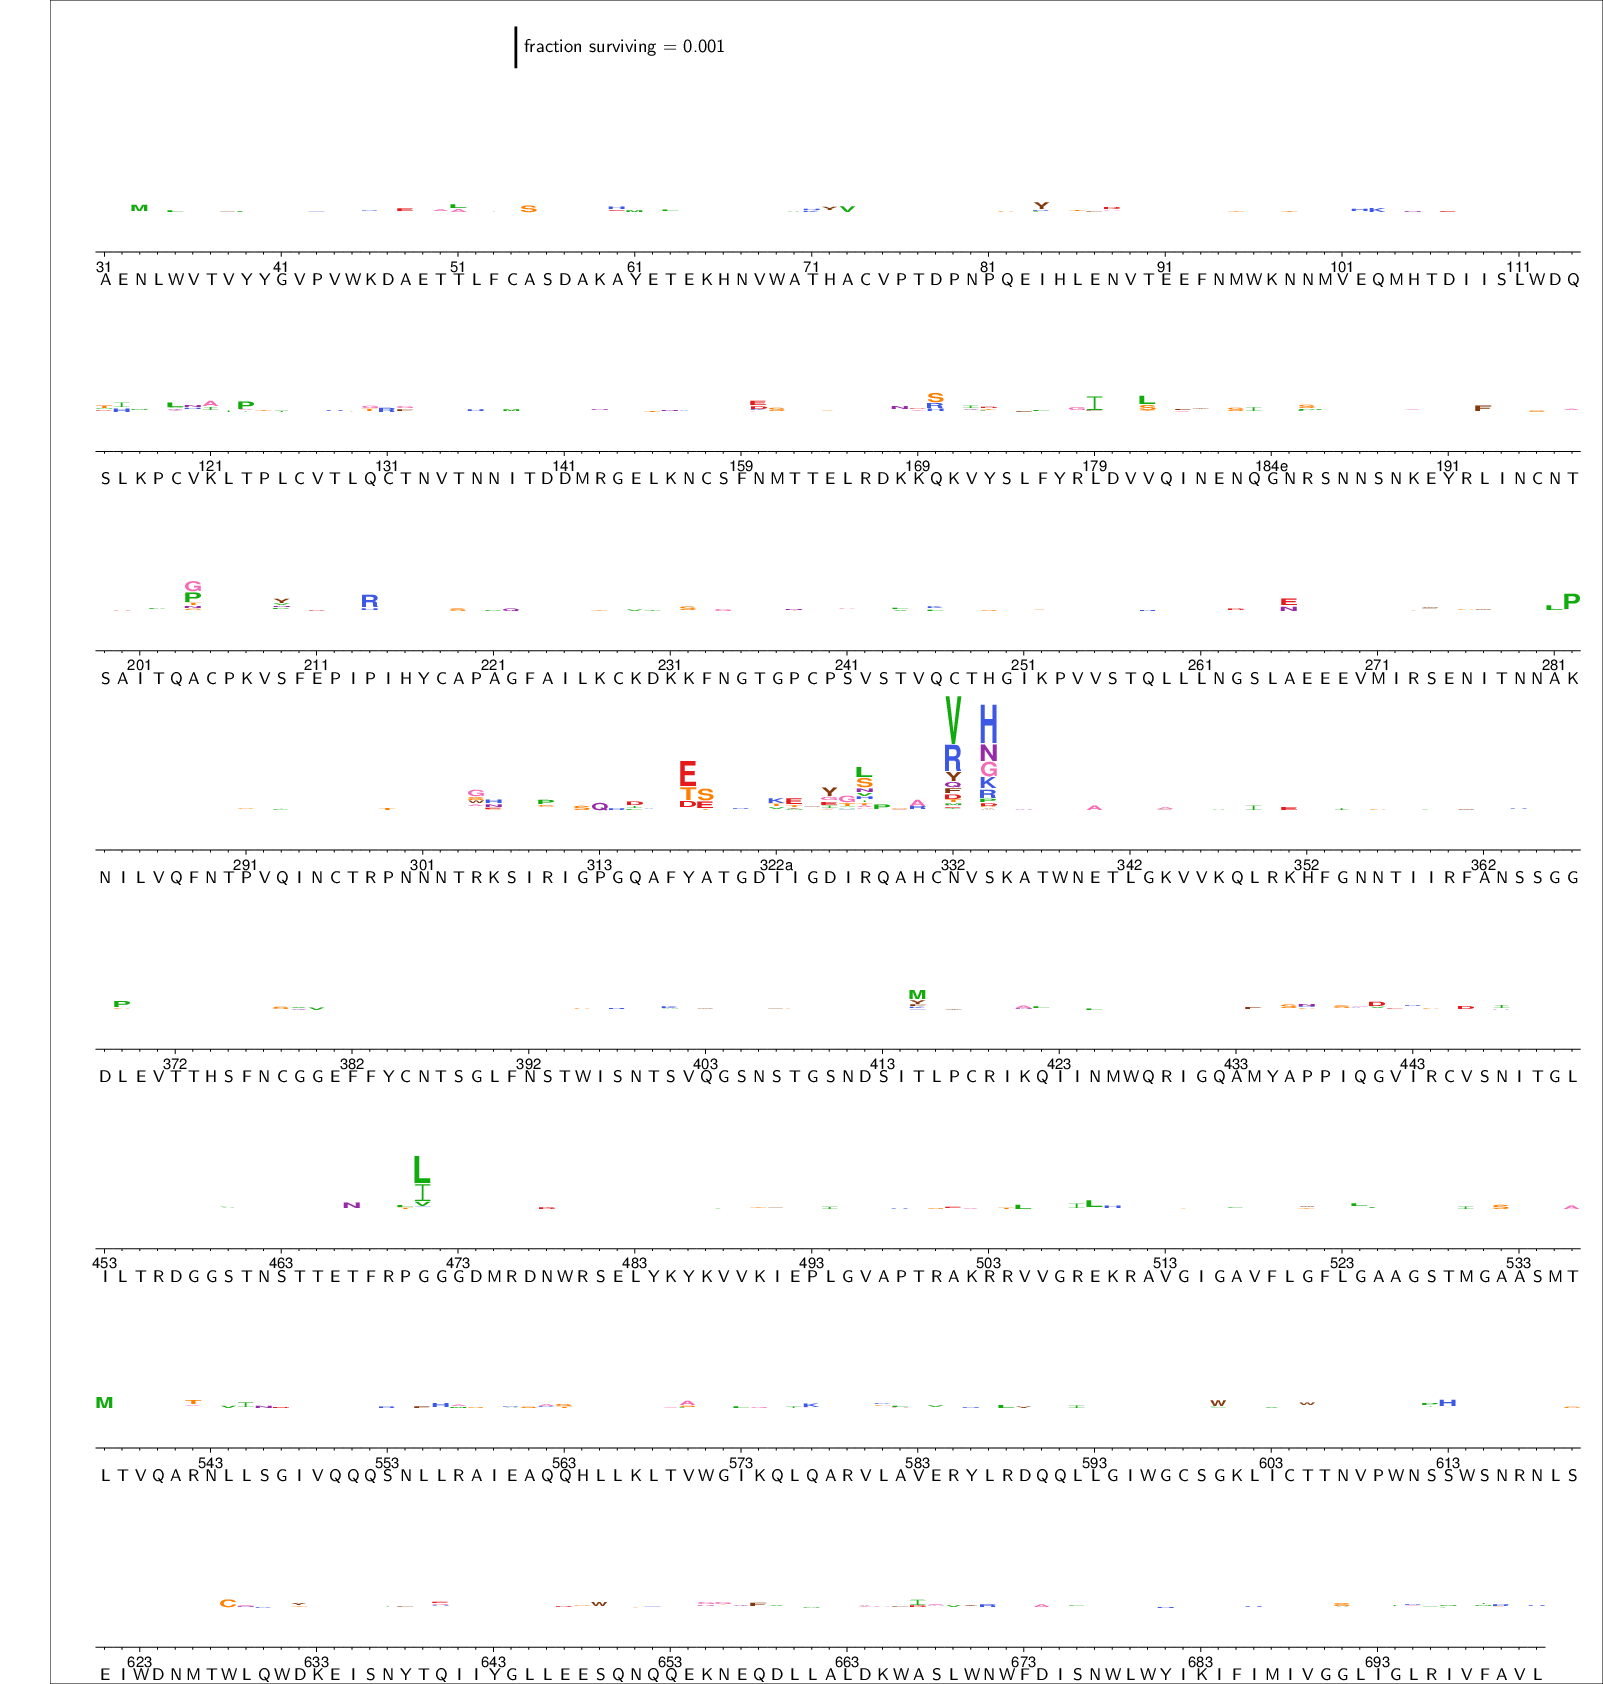

./results/fracsurviveaboveavg/concavg_wtDNA_ctrl/Simulated_Pool/Simulated-3BNC117mean-101074mean-aboveavg_fracsurvive.pdf

Creating logo plot for Simulated-3BNC117mean-101074mean-aboveavg from ./results/fracsurviveaboveavg/concavg_wtDNA_ctrl/Simulated_Pool/Simulated_3BNC117mean_101074mean-aboveavg-meanmutfracsurvive.csv


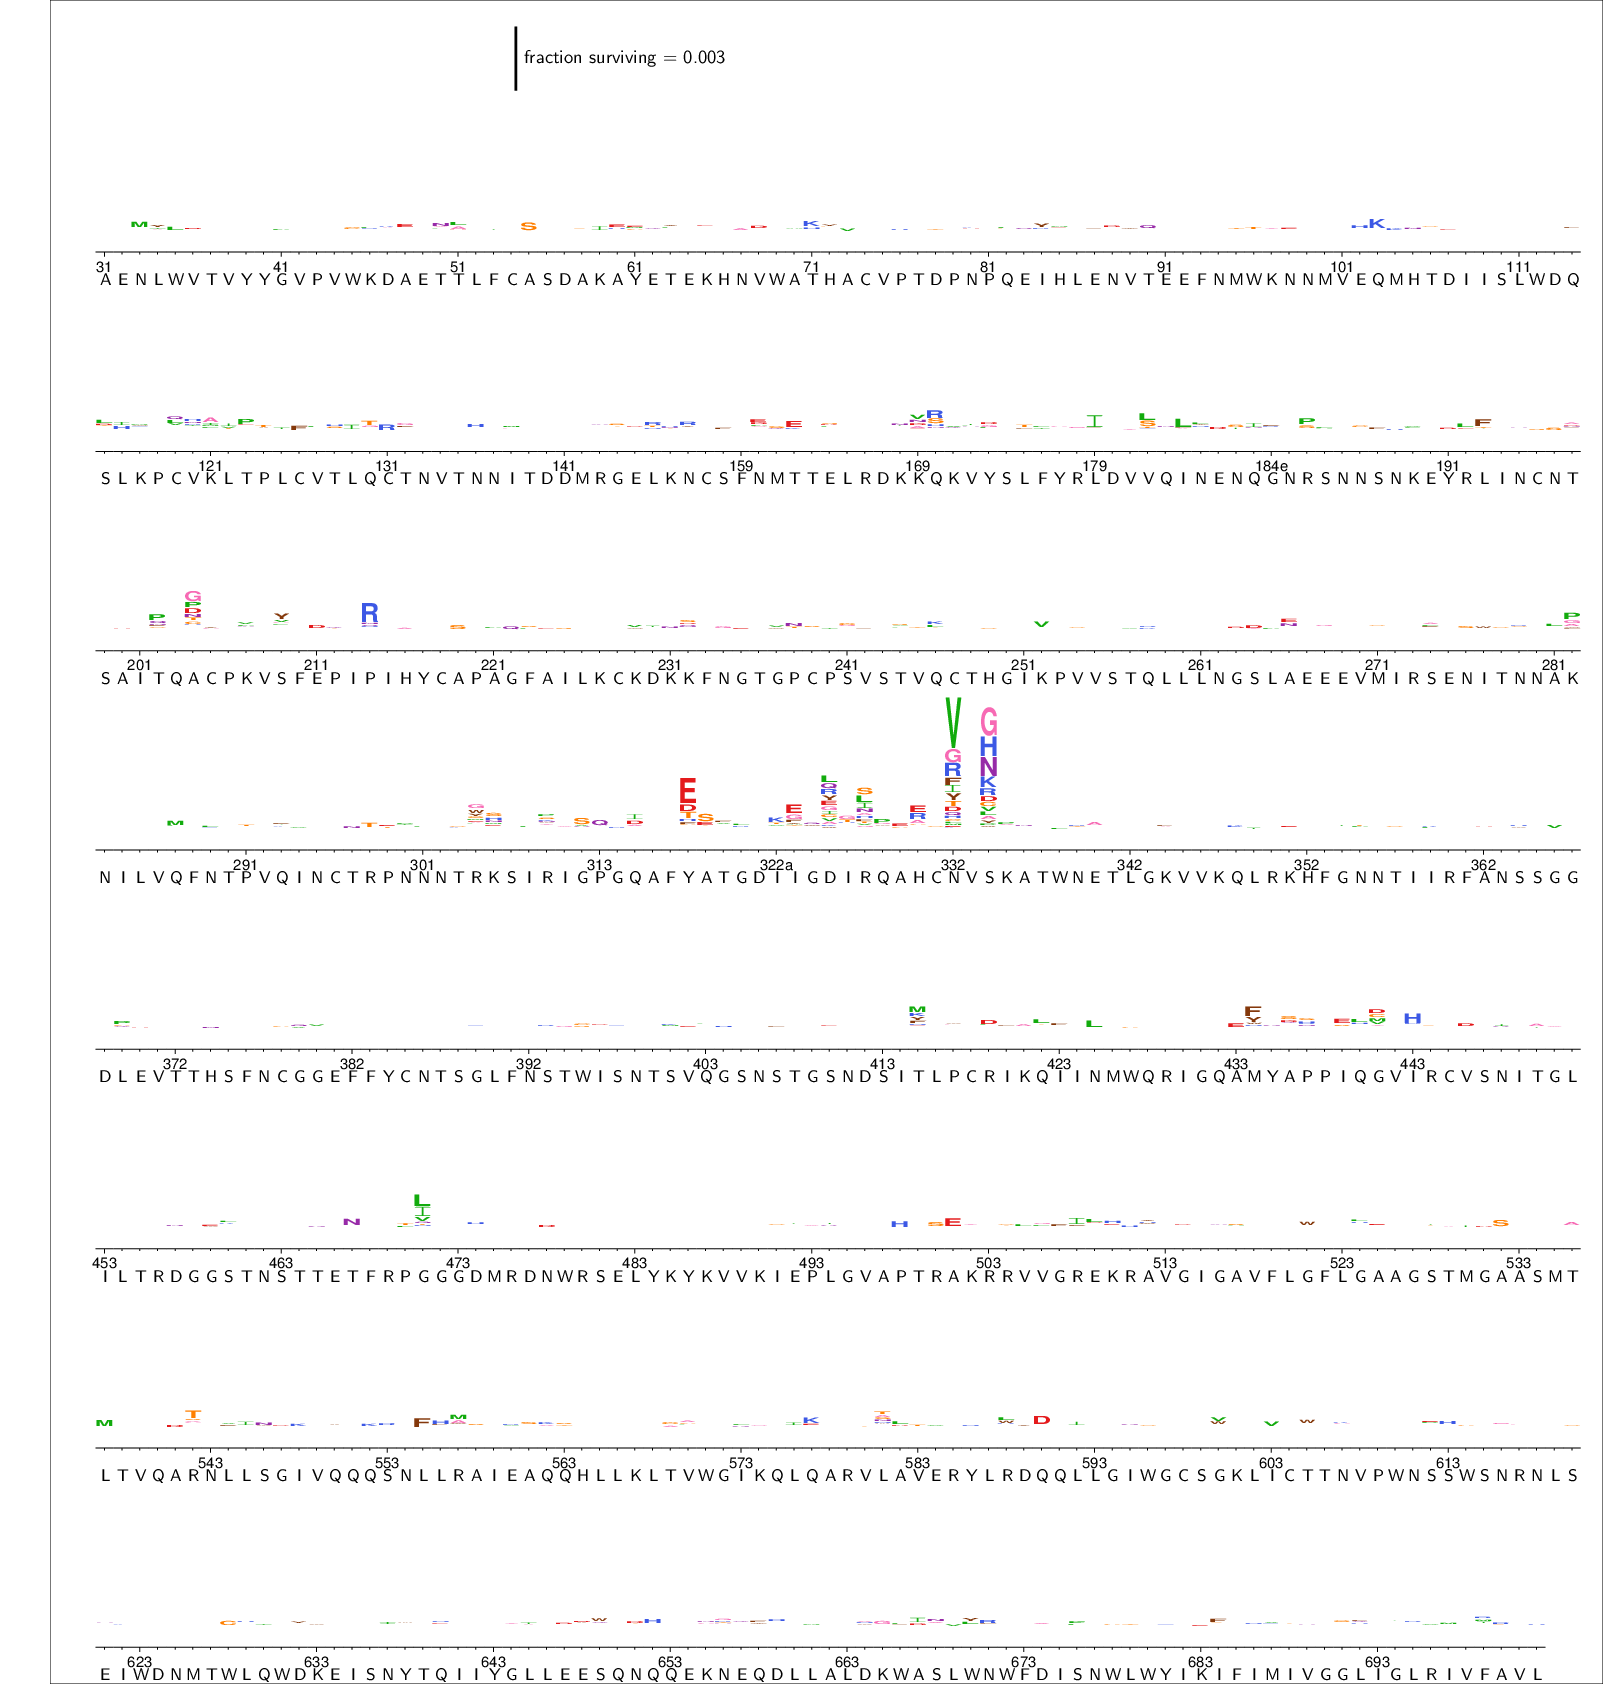

In [78]:
files = [ "./results/fracsurviveaboveavg/concavg_wtDNA_ctrl/Simulated_Pool/Simulated_3BNC117median_101074median-aboveavg-medianmutfracsurvive.csv", "./results/fracsurviveaboveavg/concavg_wtDNA_ctrl/Simulated_Pool/Simulated_3BNC117mean_101074mean-aboveavg-meanmutfracsurvive.csv"]
namesmatchedtofiles = ['Simulated-3BNC117median-101074median-aboveavg', 'Simulated-3BNC117mean-101074mean-aboveavg']
for antibody, file in zip(namesmatchedtofiles, files):
    # mutdiffsel in this file
    #mutdiffsel =  antibody + '_mutdiffsel.csv'
    mutdiffsel = file
        #scale bar unit is maximum effect
    mutdiffseldf = pd.read_csv(mutdiffsel)
    scaleunit = '{0:.1g}'.format(mutdiffseldf['mutfracsurvive'].max())
    scalelabel = '"fraction surviving = {0}"'.format(scaleunit)
    # now create the logo plot with the overlay
    logoplot = os.path.join(AAsimulatedpooldir, '{0}_fracsurvive.pdf'.format(antibody))
    print(logoplot)
    print("\nCreating logo plot for {0} from {1}".format(antibody, mutdiffsel))
    log = !dms2_logoplot \
            --fracsurvive {mutdiffsel} \
            --name {antibody} \
            --outdir {AAsimulatedpooldir} \
            --restrictdiffsel positive \
            --sepline no \
            --nperline 84 \
            --overlay1 {mutdiffsel} wildtype wildtype \
            --scalebar {scaleunit} {scalelabel} \
            --underlay yes \
            --use_existing {use_existing}
    showPDF(logoplot)

# Quantifying the "ease of escape"

Now, we will do some simple exploratory analyses. For example, how does an antibody's breadth relate to measures of its "ease of escape"?


I will very *crudely* define escapability in a number of ways.  

Not every antibody we would like to analyze has the same virus panel. I pulled the following breadth data from [CATNAP](https://www.hiv.lanl.gov/components/sequence/HIV/neutralization/main.comp):

For the 200 most commonly used viruses, the # of viruses tested and % where neutralization was detected is shown below:

10-1074 : 68% (135/200)
10E8 : 98% (196/199)
3BNC117 : 85% (169/198)
PG9 : 84% (168/200)
PGT121 : 66% (133/200)
PGT145 : 77% (150/196)
PGT151 : 72% (145/200)
VRC01 : 91% (178/196)
VRC34.01 : 48% (79/163) 

If we limit it to the 100 most commonly used viruses: 

10-1074 : 67% (67/100)
10E8 : 98% (98/100)
3BNC117 : 91% (91/100)
PG9 : 90% (90/100)
PGT121 : 69% (69/100)
PGT145 : 81% (81/100)
PGT151 : 78% (78/100)
VRC01 : 91% (91/100)
VRC34.01 : 49% (45/92)
PGT145 : 81% (81/100)

It is intriguing/alarming that the breadth of PG9 differs so much between the 100 and 200 virus panels. However, to ensure we have the most similar virus panel for each antibody as possible, I used  the 100 virus panel. 

In [79]:
breadth_dict = {}
breadth_dict["VRC01"] = 91
breadth_dict["3BNC117"] = 91
breadth_dict["PGT121"] = 69
breadth_dict["10E8"] = 98
breadth_dict["PG9"] = 90
breadth_dict["PGT151"] = 78  
breadth_dict["VRC34"] =  49
breadth_dict["101074"] = 67
breadth_dict["PGT145"] = 81
breadth_dict["3BNC117/101074"] = 91

# breadth is 91% for 3BNC117 and 10-1074 pooled. (75/82) of 100 most common viruses neutralized in CATNAP. 

In [80]:
breadth_df = pd.DataFrame.from_dict(breadth_dict, orient='index')   

breadth_df.columns = ['breadth']
print(breadth_df)
breadth_vs_epitope_muttol_df = breadth_df.copy()

                breadth
VRC01                91
3BNC117              91
PGT121               69
10E8                 98
PG9                  90
PGT151               78
VRC34                49
101074               67
PGT145               81
3BNC117/101074       91


In [81]:
epitope_site_dict["3BNC117/101074"] = ['197', '207', '276', '278', '279', '280', '281', '282', '306', '308', '316', '365', '366', '367', '368', '371', '392', '428', '430', '456', '457', '458', '459', '460', '461', '462', '463', '464', '465', '469', '135', '136', '137', '156', '301', '322', '322a', '324', '325', '326', '327', '328', '330', '332', '417'] 
fracsurviveaboveavg_dict["3BNC117/101074"] = './results/fracsurviveaboveavg/concavg_wtDNA_ctrl/summary_3BN-1074-pool-medianmutfracsurvive.csv'
sigsites["3BNC117/101074"] = ['325', '332', '334']
sitefracsurviveaboveavg_dict["3BNC117/101074"] = './results/fracsurviveaboveavg/concavg_wtDNA_ctrl/summary_3BN-1074-pool-mediansitefracsurvive.csv'

In [82]:
import statistics
contact_median_MFS = {}
contact_mean_MFS = {}
contact_sum_MFS = {}
SumTop100_MFS = {}
SumTop100_avgfracsurvive = {}

SumSigSites_MFS = {}
SumSigSites_avgfracsurvive = {}
antibodies = ["VRC01","3BNC117","PGT121", "101074", "10E8", "PG9", "PGT151", "VRC34", "PGT145", "3BNC117/101074"]
for antibody in antibodies:
    antibodycorroutfilelist = []
    epitopesites = epitope_site_dict[antibody]
    mutfracsurvive_df = pd.read_csv(fracsurviveaboveavg_dict[antibody])
    #annotate epitope sites in this df
    mutfracsurvive_df['epitopesite'] = mutfracsurvive_df['site'].isin(epitopesites)
    mutfracsurvive_df['contactsites']= np.where(mutfracsurvive_df['epitopesite']==True , mutfracsurvive_df['mutfracsurvive'], "NaN")
    
    
    
    #then, we get a list of the contact sites mutfracsurvive values
    contacts_mfs_list = mutfracsurvive_df["contactsites"].tolist()
    #Then, delete the NaNs and get statistics, then export to dictionaries for each (of dfs?)
    contacts_mfs_list = list(set(contacts_mfs_list))
    contacts_mfs_list.remove("NaN")
    #then, get mean and median entropy and neffective for sites that are in epitope
    contacts_mfs_list = [float(x) for x in contacts_mfs_list]

    contacts_median_mfs = statistics.median(contacts_mfs_list)
    contacts_mean_mfs = statistics.mean(contacts_mfs_list)
    contacts_sum_mfs = sum(contacts_mfs_list)
    contact_median_MFS[antibody] = contacts_median_mfs
    contact_mean_MFS[antibody] = contacts_mean_mfs
    contact_sum_MFS[antibody] = contacts_sum_mfs
    
    mfs_list = mutfracsurvive_df["mutfracsurvive"].tolist()
    mfs_list = [float(x) for x in mfs_list]
    top100_mfs_list = mfs_list[:100]    
    SumTop100_MFS_data = sum(top100_mfs_list)
    SumTop100_MFS[antibody] = SumTop100_MFS_data
    
    #now lets look at sig sites
    significantsites = sigsites[antibody]
    mutfracsurvive_df['significantsite'] = mutfracsurvive_df['site'].isin(significantsites)
    mutfracsurvive_df['significantsites']= np.where(mutfracsurvive_df['significantsite']==True , mutfracsurvive_df['mutfracsurvive'], "NaN")
    #then, we get a list of the contact sites mutfracsurvive values
    significant_mfs_list = mutfracsurvive_df["significantsites"].tolist()
    #Then, delete the NaNs and get statistics, then export to dictionaries for each (of dfs?)
    significant_mfs_list = list(set(significant_mfs_list))
    significant_mfs_list.remove("NaN")
    #then, get mean and median entropy and neffective for sites that are in epitope
    significant_mfs_list = [float(x) for x in significant_mfs_list]
    significant_sum_mfs = sum(significant_mfs_list)
    SumSigSites_MFS[antibody] = significant_sum_mfs
    
    #could also look at top sites. 
    sitefracsurvive_df = pd.read_csv(sitefracsurviveaboveavg_dict[antibody])
    #annotate epitope sites in this df
    sitefracsurvive_df['epitopesite'] = sitefracsurvive_df['site'].isin(epitopesites)
    sitefracsurvive_df['contactsite']= np.where(sitefracsurvive_df['epitopesite']==True , "contact", "non-contact")
    sfs_list = sitefracsurvive_df["avgfracsurvive"].tolist()
    sfs_list = [float(x) for x in sfs_list]
    sfs_list.sort(reverse=True)
    top100_sfs_list = sfs_list[:100]
    top100_sfs_data = sum(top100_sfs_list)
    SumTop100_avgfracsurvive[antibody] = top100_sfs_data
    #print(antibody, top100_sfs_list, top100_sfs_data) 
    
    sitefracsurvive_df['significantsite'] = sitefracsurvive_df['site'].isin(significantsites)
    sitefracsurvive_df['significantsites']= np.where(sitefracsurvive_df['significantsite']==True , sitefracsurvive_df["avgfracsurvive"], "NaN")
    significant_sfs_list = sitefracsurvive_df["significantsites"].tolist()
    #Then, delete the NaNs and get statistics, then export to dictionaries for each (of dfs?)
    significant_sfs_list = list(set(significant_sfs_list))
    significant_sfs_list.remove("NaN")
    #then, get mean and median entropy and neffective for sites that are in epitope
    significant_sfs_list = [float(x) for x in significant_sfs_list]
    significant_sum_sfs = sum(significant_sfs_list)
    SumSigSites_avgfracsurvive[antibody] = significant_sum_sfs


In [83]:
contact_median_MFS_df =pd.DataFrame.from_dict(contact_median_MFS, orient='index')
contact_median_MFS_df.columns = ['contact_median_MFS']

contact_mean_MFS_df =pd.DataFrame.from_dict(contact_mean_MFS, orient='index')
contact_mean_MFS_df.columns = ['contact_mean_MFS']

contact_sum_MFS_df =pd.DataFrame.from_dict(contact_sum_MFS, orient='index')
contact_sum_MFS_df.columns = ['contact_sum_MFS']

SumTop100_MFS_df =pd.DataFrame.from_dict(SumTop100_MFS, orient='index')
#print(SumTop100_MFS_df)

SumTop100_MFS_df.columns = ['SumTop100_MFS']
#print(SumTop100_MFS_df)

SumTop100_avgfracsurvive_df =pd.DataFrame.from_dict(SumTop100_avgfracsurvive, orient='index')
SumTop100_avgfracsurvive_df.columns = ['SumTop100_avgfracsurvive']

breadth_vs_epitope_muttol_df = breadth_vs_epitope_muttol_df.merge(contact_median_MFS_df, left_index=True, right_index=True)
breadth_vs_epitope_muttol_df = breadth_vs_epitope_muttol_df.merge(contact_mean_MFS_df, left_index=True, right_index=True)
breadth_vs_epitope_muttol_df = breadth_vs_epitope_muttol_df.merge(contact_sum_MFS_df, left_index=True, right_index=True)
breadth_vs_epitope_muttol_df = breadth_vs_epitope_muttol_df.merge(SumTop100_MFS_df, left_index=True, right_index=True)
breadth_vs_epitope_muttol_df = breadth_vs_epitope_muttol_df.merge(SumTop100_avgfracsurvive_df, left_index=True, right_index=True)

SumSigSites_MFS_df =pd.DataFrame.from_dict(SumSigSites_MFS, orient='index')
SumSigSites_MFS_df.columns = ['SumSigSites_MFS']

SumSigSites_avgfracsurvive_df =pd.DataFrame.from_dict(SumSigSites_avgfracsurvive, orient='index')
SumSigSites_avgfracsurvive_df.columns = ['SumSigSites_avgfracsurvive']

breadth_vs_epitope_muttol_df = breadth_vs_epitope_muttol_df.merge(SumSigSites_MFS_df, left_index=True, right_index=True)
breadth_vs_epitope_muttol_df = breadth_vs_epitope_muttol_df.merge(SumSigSites_avgfracsurvive_df, left_index=True, right_index=True)

subset_breadth_vs_epitope_muttol_df = breadth_vs_epitope_muttol_df.copy()

display(HTML(subset_breadth_vs_epitope_muttol_df.to_html(index=True)))

Below, I plot the correlation between breadth and a number of different "ease of escape" metrics. While only one is included in the paper (the sum of the fraction surviving values at significant sites of escape), each of the plots are quite similar. No matter how we quantify the "ease of escape" is is correlated with breadth, but distinct, with clear differences among the broadest antibodies. 

In [84]:
escapedir = './results/fracsurviveaboveavg/concavg_wtDNA_ctrl/escapability_plots/'
if not os.path.isdir(escapedir):
    os.mkdir(escapedir)

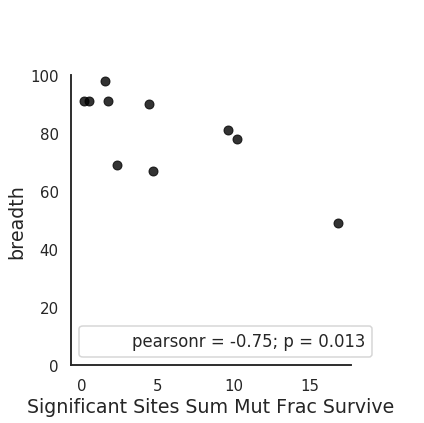

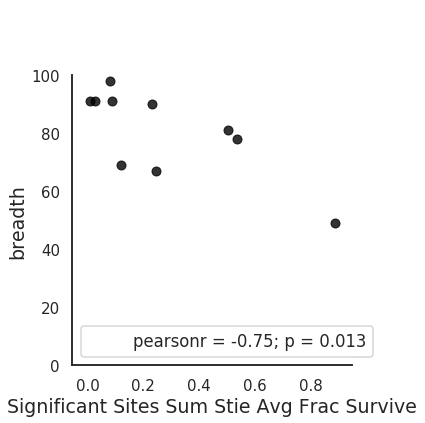

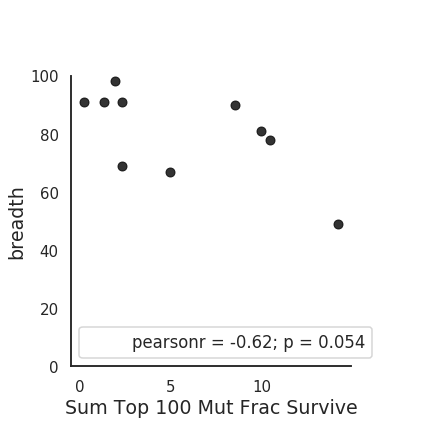

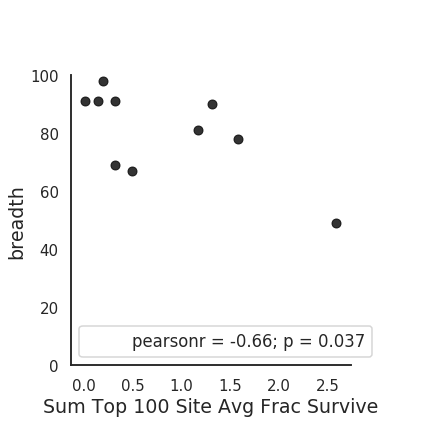

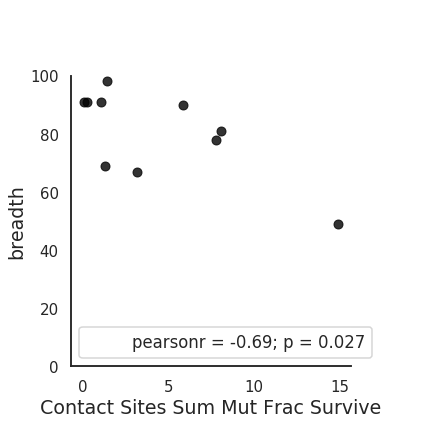

In [85]:
plot = sns.JointGrid(data=breadth_vs_epitope_muttol_df, x='SumSigSites_MFS', y='breadth', ylim=(0,100))  
plot.plot_joint(sns.regplot, color="black", fit_reg=False)
plot.annotate(stats.pearsonr)
plt.xlabel("Significant Sites Sum Mut Frac Survive")
plot.ax_marg_x.set_axis_off()
plot.ax_marg_y.set_axis_off()
plot.savefig("./results/fracsurviveaboveavg/concavg_wtDNA_ctrl/escapability_plots/BreadthVsSumSigSites.png")

plot = sns.JointGrid(data=breadth_vs_epitope_muttol_df, x='SumSigSites_avgfracsurvive', y='breadth', ylim=(0,100))  
plot.plot_joint(sns.regplot, color="black", fit_reg=False)
plot.annotate(stats.pearsonr)
plt.xlabel("Significant Sites Sum Stie Avg Frac Survive")
plot.ax_marg_x.set_axis_off()
plot.ax_marg_y.set_axis_off()

plot = sns.JointGrid(data=breadth_vs_epitope_muttol_df, x='SumTop100_MFS', y='breadth', ylim=(0,100))  
plot.plot_joint(sns.regplot, color="black", fit_reg=False)
plot.annotate(stats.pearsonr)
plt.xlabel("Sum Top 100 Mut Frac Survive")
plot.ax_marg_x.set_axis_off()
plot.ax_marg_y.set_axis_off()

plot = sns.JointGrid(data=breadth_vs_epitope_muttol_df, x='SumTop100_avgfracsurvive', y='breadth', ylim=(0,100))  
plot.plot_joint(sns.regplot, color="black", fit_reg=False)
plot.annotate(stats.pearsonr)
plt.xlabel("Sum Top 100 Site Avg Frac Survive")
plot.ax_marg_x.set_axis_off()
plot.ax_marg_y.set_axis_off()

plot = sns.JointGrid(data=breadth_vs_epitope_muttol_df, x='contact_sum_MFS', y='breadth', ylim=(0,100))  
plot.plot_joint(sns.regplot, color="black", fit_reg=False)
plot.annotate(stats.pearsonr)
plt.xlabel("Contact Sites Sum Mut Frac Survive")
plot.ax_marg_x.set_axis_off()
plot.ax_marg_y.set_axis_off()

Now, lets compare the largest effect size mutations across antibodies. For each antibody, I will just plot the effect size of the top 100 mutations...

all mutations, ranked phi:


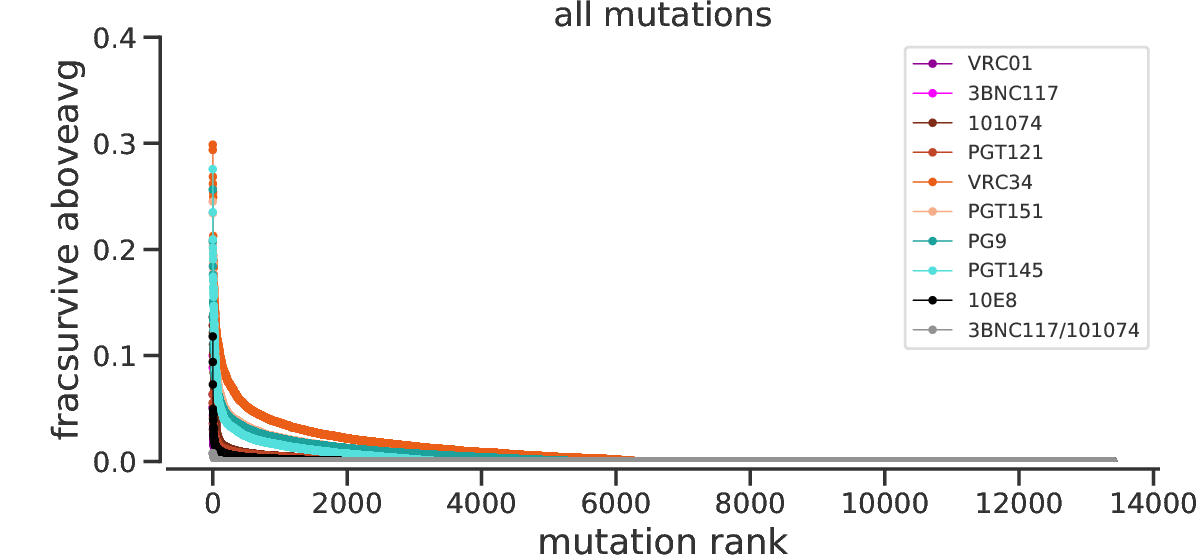

top 1000, ranked phi:
top 100, ranked phi:


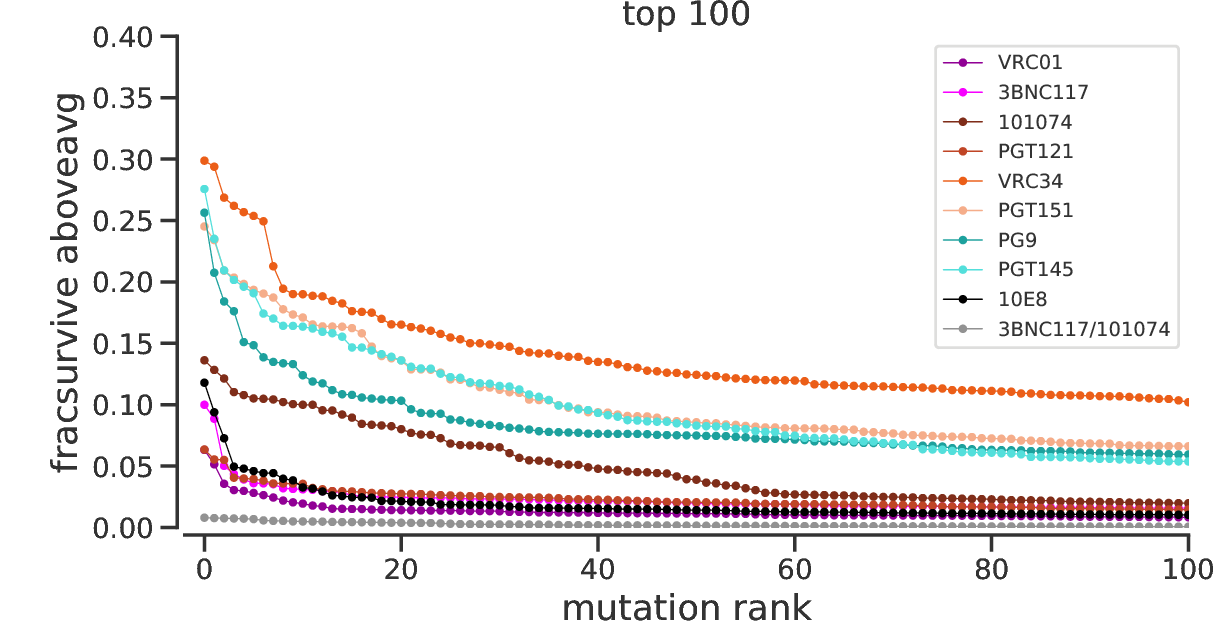

In [86]:
colorcycle = ["#910095", "#f700ff",
             "#7f2d19", "#c04526",
             "#eb5e18", "#f5ad8a",
             "#1da19d", "#53dfdb",
             "#000000", "#808080"]

    

def PlotRankedMutationsFrac(labels_files, outfileprefix, include_stdev=False, rank_lims=False, y_lims=False, title=False,  
                       colorcycle=colorcycle, alpha=0.6, make_legend=True, figsize=(5,4), ylabel='fraction surviving', convert_to_enrichment=False):
    '''labels_files is a list of tuples of (label, diffsel_file).
    Those diffsel_files must have a stdev column if include_stdev=True.
    
    To keep files friendly to existing dms_tools programs like dms_merge and dms_logoplot, phi files use the header `diffsel` for phi (but are named appropriately)
    
    the prefix in outfile will be saved in the plots directory with .pdf added.
    rank_lims sets the x-axis limit (mutation ranks)'''
    
    fig = plt.figure(figsize=figsize)
    
    for i, (difflabel, difffile) in enumerate(labels_files):
        df = pd.read_csv(difffile).dropna()
        if not convert_to_enrichment:
            plt.plot(df['mutfracsurvive'], marker='.', label = difflabel, linewidth=0.6, mew=0, color=colorcycle[i]) # i think this plots rank technically as 0, 1, 2 instead of 1, 2, 3...
        else:
            plt.plot(2**df['mutfracsurvive'], marker='.', label = difflabel, linewidth=0.6, mew=0, color=colorcycle[i]) # i think this plots rank technically as 0, 1, 2 instead of 1, 2, 3...

    plt.xlabel('mutation rank')
    plt.ylabel(ylabel) # default is differential selection, but can change to plot rank-ordered phis.
    
    spineOffset = {'left': 4, 'bottom': 4}    
    [spine.set_position(('outward',spineOffset[loc])) if loc in ['left','bottom'] else spine.set_color('none') for loc, spine in plt.gca().spines.items() ] 
    plt.gca().tick_params(axis='x', direction='out')
    plt.gca().tick_params(axis='y', direction='out')
    plt.gca().get_xaxis().tick_bottom()
    plt.gca().get_yaxis().tick_left()
    
    if rank_lims:
        plt.xlim(rank_lims)
    if y_lims:
        plt.ylim(y_lims)
    if title:
        plt.title(title)
    if make_legend:
        legend = plt.legend(fontsize=10.5, fancybox = True)
        
    if include_stdev:
        for i, (difflabel, difffile) in enumerate(labels_files):
            df = pd.read_csv(difffile).dropna()
            plt.gca().errorbar(range(0, len(df.index)),
                               df['diffsel'],
                               yerr=df['stdev'], 
                               marker=None, color=colorcycle[i], 
                               alpha=alpha, capsize=0, elinewidth=0.9)
    plt.tight_layout()
    plt.savefig(outfile)
    plt.close()
    

phiaboveavg_sub_tuple_mut = [('VRC01', './results/fracsurviveaboveavg/concavg_wtDNA_ctrl/summary_VRC01-medianmutfracsurvive.csv'),
    ('3BNC117', './results/fracsurviveaboveavg/concavg_wtDNA_ctrl/summary_3BNC117-medianmutfracsurvive.csv'),
    ('101074', './results/fracsurviveaboveavg/concavg_wtDNA_ctrl/summary_101074-medianmutfracsurvive.csv'),
    ('PGT121', './results/fracsurviveaboveavg/concavg_wtDNA_ctrl/summary_PGT121-medianmutfracsurvive.csv'),
    ('VRC34', './results/fracsurviveaboveavg/concavg_wtDNA_ctrl/summary_VRC34-medianmutfracsurvive.csv'),
    ('PGT151', './results/fracsurviveaboveavg/concavg_wtDNA_ctrl/summary_PGT151-medianmutfracsurvive.csv'),
    ('PG9', './results/fracsurviveaboveavg/concavg_wtDNA_ctrl/summary_PG9-medianmutfracsurvive.csv'),
    ('PGT145', './results/fracsurviveaboveavg/concavg_wtDNA_ctrl/summary_PGT145-medianmutfracsurvive.csv'),
    ('10E8', './results/fracsurviveaboveavg/concavg_wtDNA_ctrl/summary_10E8-medianmutfracsurvive.csv'),
    ('3BNC117/101074', './results/fracsurviveaboveavg/concavg_wtDNA_ctrl/summary_3BN-1074-pool-medianmutfracsurvive.csv')]


    
tempoutdir = './results/fracsurviveaboveavg/concavg_wtDNA_ctrl/escapability_plots/'
if not os.path.isdir(tempoutdir):
    os.mkdir(tempoutdir)

outfile = "./results/fracsurviveaboveavg/concavg_wtDNA_ctrl/escapability_plots/BG505_All_fracsurvive.pdf"
print("all mutations, ranked phi:")                           
PlotRankedMutationsFrac(phiaboveavg_sub_tuple_mut, outfile, title='all mutations', make_legend=True, y_lims=(0, .4), figsize=(9,4.5), ylabel='fracsurvive aboveavg', colorcycle=colorcycle)
showPDF([outfile], width=700)

outfile = "./results/fracsurviveaboveavg/concavg_wtDNA_ctrl/escapability_plots/BG505_top1000_fracsurvive.pdf"
print("top 1000, ranked phi:")                           
PlotRankedMutationsFrac(phiaboveavg_sub_tuple_mut, outfile, rank_lims=(-10, 1000), y_lims=(0, .4), title='top 1000', make_legend=True, figsize=(9,4.5), ylabel='fracsurvive aboveavg', colorcycle=colorcycle)
#showPDF([outfile], width=700)

outfile = "./results/fracsurviveaboveavg/concavg_wtDNA_ctrl/escapability_plots/BG505_top100_fracsurvive.pdf"
print("top 100, ranked phi:")                           
PlotRankedMutationsFrac(phiaboveavg_sub_tuple_mut, outfile, rank_lims=(-2, 100), y_lims=(0, .4), title='top 100', make_legend=True, figsize=(9,5), ylabel='fracsurvive aboveavg', colorcycle=colorcycle)
showPDF([outfile], width=700)

Now, lets color that plot by sequence accessible vs non accessible mutations

In [87]:
from dms_tools2.utils import codonEvolAccessibility
#below functions edited from Shirleen Soh, https://github.com/jbloomlab/computational_notebooks/blob/master/yqsoh/2018/PB2-DMS-full-A549-CCL141/AnalyzeAdaptiveSites.ipynb

def calc_accessibility(row):
    if row['min Subst']==0:
        return '0'
    elif row['min Subst']<=1.1: # Picked this cut off to accommodate values slightly >1 when considering many sequences
        return '1'
    else:
        return '>1'
def seqsToCodonAcc(filename, seqlen):
    allowed_chars = set('ATCG')
    seqs = []
    for seq_record in Bio.SeqIO.parse(filename, 'fasta'):
        if len(seq_record.seq)==seqlen:
            if set(seq_record.seq).issubset(allowed_chars):
                seqs.append(str(seq_record.seq))
    #         else:
    #             print('Invalid bases:', seq_record.id, len(seq_record.seq))
        else:
            print('Not full length:', seq_record.id, len(seq_record.seq))
    accessibilitydf = (codonEvolAccessibility(seqs)
                     .melt(id_vars='site', value_vars=dms_tools2.AAS_WITHSTOP, 
                           var_name='toAA', value_name='min Subst')
                    )
    accessibilitydf['accessibility'] = accessibilitydf.apply(lambda row: calc_accessibility(row), axis=1)
    return accessibilitydf

accessibilityBG505 = seqsToCodonAcc('./data/BG505.W6.C2.T332N_env.fasta', 2583)

#now, I need to convert to HXB2 numbering, and be able to merge into mutfracsurvive df. 
convert_df = pd.read_csv("./results/HXB2_numbering/BG505_to_HXB2.csv")
convert_df.drop('N-glycan', axis=1, inplace=True)
accessibilityBG505_convert = accessibilityBG505.merge(convert_df, left_on = "site", right_on = "original")
accessibilityBG505_convert = accessibilityBG505_convert.rename(columns={'new': 'HXB2_site'})
accessibilityBG505_convert["mut"] = accessibilityBG505_convert["wildtype"].astype(str) + accessibilityBG505_convert["HXB2_site"].astype(str) + accessibilityBG505_convert["toAA"].astype(str) 

In [88]:
def PlotRankedMutationsFracAccessible(labels_files, outfileprefix, include_stdev=False, rank_lims=False, y_lims=False, title=False,  
                       colorcycle=colorcycle, alpha=0.6, make_legend=True, figsize=(5,4), ylabel='fraction surviving', convert_to_enrichment=False):
    '''labels_files is a list of tuples of (label, diffsel_file).
    Those diffsel_files must have a stdev column if include_stdev=True.
    
    To keep files friendly to existing dms_tools programs like dms_merge and dms_logoplot, phi files use the header `diffsel` for phi (but are named appropriately)
    
    the prefix in outfile will be saved in the plots directory with .pdf added.
    rank_lims sets the x-axis limit (mutation ranks)'''
    
    fig = plt.figure(figsize=figsize)
    
    for i, (difflabel, difffile) in enumerate(labels_files):
        df = pd.read_csv(difffile).dropna()
        if not convert_to_enrichment:
            #merge in an drop!
            df["mut"] = df["wildtype"].astype(str) + df["site"].astype(str) + df["mutation"].astype(str) 
            accessibilityBG505_convert_copy = accessibilityBG505_convert.copy()
            df = df.merge(accessibilityBG505_convert_copy, left_on = "mut", right_on = "mut")
            
            #only plot if accesible! I will simply drop if not accessible
            dfaccess = df[df.accessibility != ">1"]
            dfnonaccess = df[df.accessibility == ">1"]
            
            plt.plot(df['mutfracsurvive'], marker=None, label = difflabel, linewidth=0.6, color=colorcycle[i]) # i think this plots rank technically as 0, 1, 2 instead of 1, 2, 3...
    
            plt.plot(dfnonaccess['mutfracsurvive'], marker='o', markersize=4, fillstyle="none", markerfacecolor="white", label = difflabel, linewidth=0, color=colorcycle[i]) # i think this plots rank technically as 0, 1, 2 instead of 1, 2, 3...
            plt.plot(dfaccess['mutfracsurvive'], marker='o', markersize=4,  label = difflabel, linewidth=0, color=colorcycle[i]) # i think this plots rank technically as 0, 1, 2 instead of 1, 2, 3...

            
        else:
            #merge in an drop!
            df["mut"] = df["wildtype"].astype(str) + df["site"].astype(str) + df["mutation"].astype(str) 
            accessibilityBG505_convert_copy = accessibilityBG505_convert.copy()
            df = df.merge(accessibilityBG505_convert_copy, left_on = "mut", right_on = "mut")
            #only plot if accesible! I will simply drop if not accessible
            df = df[df.accessibility != ">1"]
            print(df)
            plt.plot(2**df['mutfracsurvive'], marker='.', label = difflabel, linewidth=0.6, mew=0, color=colorcycle[i]) # i think this plots rank technically as 0, 1, 2 instead of 1, 2, 3...

    plt.xlabel('mutation rank')
    plt.ylabel(ylabel) # default is differential selection, but can change to plot rank-ordered phis.
    
    spineOffset = {'left': 4, 'bottom': 4}    
    [spine.set_position(('outward',spineOffset[loc])) if loc in ['left','bottom'] else spine.set_color('none') for loc, spine in plt.gca().spines.items() ] 
    plt.gca().tick_params(axis='x', direction='out')
    plt.gca().tick_params(axis='y', direction='out')
    plt.gca().get_xaxis().tick_bottom()
    plt.gca().get_yaxis().tick_left()
    
    if rank_lims:
        plt.xlim(rank_lims)
    if y_lims:
        plt.ylim(y_lims)
    if title:
        plt.title(title)
    if make_legend:
        legend = plt.legend(fontsize=10.5, fancybox = False)
        
    if include_stdev:
        for i, (difflabel, difffile) in enumerate(labels_files):
            df = pd.read_csv(difffile).dropna()
            plt.gca().errorbar(range(0, len(df.index)),
                               df['diffsel'],
                               yerr=df['stdev'], 
                               marker=None, color=colorcycle[i], 
                               alpha=alpha, capsize=0, elinewidth=0.9)

    plt.tight_layout()
    plt.savefig(outfile)
    plt.close()

top 100, ranked phi:


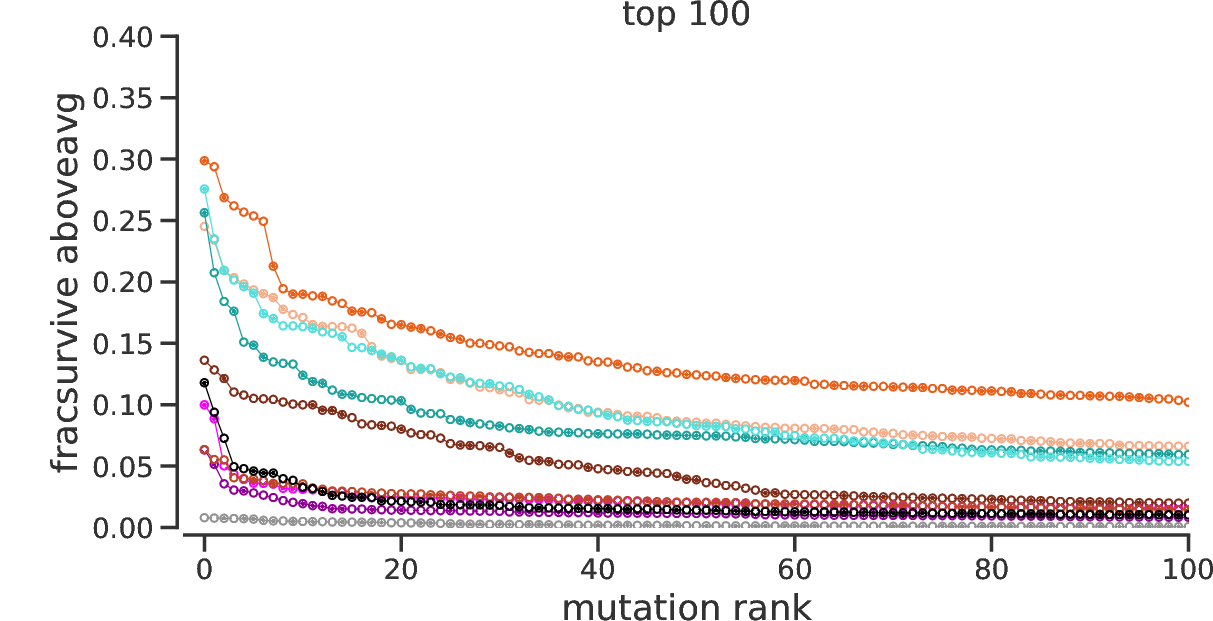

In [89]:
tempoutdir = './results/fracsurviveaboveavg/concavg_wtDNA_ctrl/escapability_plots/Accessible/'
if not os.path.isdir(tempoutdir):
    os.mkdir(tempoutdir)


outfile = "./results/fracsurviveaboveavg/concavg_wtDNA_ctrl/escapability_plots/Accessible/AccOnly_BG505_top100_fracsurvive.pdf"
print("top 100, ranked phi:")                           
PlotRankedMutationsFracAccessible(phiaboveavg_sub_tuple_mut, outfile, rank_lims=(-2, 100), y_lims=(0, .4), title='top 100', make_legend=False, figsize=(9,5), ylabel='fracsurvive aboveavg', colorcycle=colorcycle)
showPDF([outfile], width=700)